# Homework 3
In this homework, we will explore language generation using character-level RNNs. Sounds awesome, right?

A few notes at the beginning:
- It might be useful for you to read the whole assignment before beginning. Especially the last two sections so you know what to record for turning in.
- Much of the required knowledge in this (and past) homeworks about Python, PyTorch, etc. are not explained fully here. Instead, we expect you to use the existing documentation, search engines, Stack Overflow, etc. for implementation details.
- That being said, we have listed several functions in parts of the homework where knowing those functions exist would be especially useful. However you will still need to read the docs on how to specifically use the functions.

# Part 0: Initial setup
You should recognize this code from last time.


In [1]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.3.0+cu100
# CUDA enabled: True

Version 1.3.1+cu100
CUDA enabled: True


In [2]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
'My Drive'


# Part 1: Upload the dataset
We will be using the complete text of Harry Potter as our corpus. We will provide it for you in a not-very-well-formatted way.
Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.



In [0]:
import os
BASE_PATH = '/gdrive/My Drive/colab_files/homework3/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

if not os.path.exists(os.path.join(BASE_PATH, 'harry_potter.txt')):
    os.chdir(BASE_PATH)
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
    !tar -zxvf homework3.tar.gz
    !rm homework3.tar.gz
    !cp pt_util.py /content
    !cp harry_potter.txt /content
os.chdir('/content')

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

#Part 2: Preprocessing the data
In previous homeworks, we have provided a cleaned version of the data. But this time you'll have to do some of that cleaning yourselves.

Hints:
- train_text and test_text should contain the class indices for the character tokens from the data file. For example, if the text was **`"ABA CDBE"`**, the token version would be a numpy array with contents `[0, 1, 0, 2, 3, 4, 1, 5]`
- The harry_potter.txt file has weird spacing. You might want to replace all the whitespace characters (space, \n, \t, etc.) in the file with the space character.
- You should output two files. One for training and one for testing. The training should be the first 80% of the characters.
- voc2ind is a map from character to the index of the class for that character. There is no predefined vocabulary, but you will need to be consistent across all tasks that use the vocabulary. For the example above, the voc2ind would be `{'A': 0, 'B': 1, ' ': 2, 'C': 3, 'D': 4, 'E': 5}`
- ind2voc is the inverse of voc2ind



In [0]:
def prepare_data(data_path):
    with open(data_path) as f:
        # This reads all the data from the file, but does not do any processing on it.
        data = f.read()
        
    # TODO Add more preprocessing
    data = data.replace('\t','')
    data = data.replace('\n','')
    print(len(data))
    symbols = [
        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
        'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q',
        'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y',
        'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
        'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q',
        'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
        'z', ' ', '\'', '.', '?', ':', '-', '!',
        ',', ';', '"', '@', '#', '&', '*', '(',
        ')', '^', '$', '~', '`', '%', '<', '>',
        '/', '\\', '1', '2', '3', '4', '5', '6',
        '7', '8', '9', '0', '_', '+', '=', '[',
        ']', '{', '}', '\x1f'
    ]
    voc2ind = { str(char): i for i, char in enumerate(symbols) }
    
    # Compute voc2ind and transform the data into an integer representation of the tokens.
    intData = np.zeros(len(data))
    for i, char in enumerate(data):
        # pass # TODO Fill this in
        intData[i] = voc2ind[char]


    ind2voc = {val: key for key, val in voc2ind.items()}

    train_text = intData[:int(len(intData)*0.8)] # TODO Fill this in
    test_text = intData[int(len(intData)*0.8):] # TODO Fill this in

    pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_train.pkl', 'wb'))
    pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'harry_potter_chars_test.pkl', 'wb'))
    
prepare_data(DATA_PATH + 'harry_potter.txt')


class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

6180222


#Part 3: Loading the data
This is possibly the trickiest part of this homework. In the past, batches were not correlated with each other, and the data within a single minibatch was also not correlated, so you could basically draw randomly from the dataset. That is not the case here. Instead, you should return sequences from the dataset.

Your instructions are to implement the following. First, imagine splitting the dataset into N chunks where N is the batch_size and the chunks are contiguous parts of the data. For each batch, you should return one sequence from each of the chunks. The batches should also be sequential an example is described below.

The data is 20 characters long `[1, 2, 3, ...20]`. The batch size is `2` and the sequence length is `4`
- The 1st batch should consist of  `(data =  [[1, 2, 3, 4]; [11, 12, 13, 14]], labels = [[2, 3, 4, 5]; [12, 13, 14, 15]])`
- The 2nd batch should consist of `(data =  [[5, 6, 7, 8]; [15, 16, 17, 18]], labels = [[6, 7, 8, 9]; [16, 17, 18, 19]])`
- The 3rd batch should consist of `(data =  [[9]; [19]], labels = [[10]; [20]])`
- There is no 4th batch.

Hints:
- To work with the rest of the code, your len(dataset) should be a multiple of the batch_size. 
- Removing the last bit to make the data the proper shape will probably give better results than padding with 0s.
- It is OK to have one batch be shorter than the others as long as all entries in that batch are the same length.
- Notice that the last label in one batch is the first data in the next batch. Be careful of off-by-one errors.



In [0]:
class HarryPotterDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(HarryPotterDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.datas = dataset['tokens'][:-1]
        self.labels = dataset['tokens'][1:]

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        # raise NotImplementedError 
        chop_length = (len(self.datas)+1)//self.batch_size    # length of each division
        num_entry = chop_length//self.sequence_length         # number of entries in a batch
        remainder = chop_length%self.sequence_length          # entry that does not fit sequence length
        offset = 1 if (remainder > 0) else 0
        number_of_batches = num_entry + offset
        number_of_unique_sequences = number_of_batches * self.batch_size
        return number_of_unique_sequences

    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.

        # data = None
        # return data[:-1], data[1:]
        sequence_length, batch_size = self.sequence_length, self.batch_size
        chop_length = (1+len(self.datas))//self.batch_size   # length of each division
        num_entry = chop_length//sequence_length # number of entries in a batch
        remainder = chop_length%sequence_length  # entry that does not fit sequence length

        offset = 1 if (remainder > 0) else 0
        number_of_batches = num_entry + offset
        number_of_unique_sequences = number_of_batches * batch_size

        batch = idx % batch_size
        element = idx // batch_size
        if (element < num_entry-1):
          start = batch*chop_length + (element)*sequence_length
          end   = batch*chop_length + (element+1)*sequence_length
        else:
          if (element == num_entry-1):
            idx_offset = 0 if (remainder > 0) else 1
            start = batch*chop_length + (element-1)*sequence_length
            end = batch*chop_length + (element)*sequence_length - idx_offset
          else:
            if (remainder > 0):
              start = batch*chop_length + (element)*sequence_length
              end = batch*chop_length + (element)*sequence_length + 1
        data = self.datas[start:end]
        label = self.labels[start:end]
        return torch.from_numpy(data).long(), torch.from_numpy(label).long()

    def vocab_size(self):
        return len(self.vocab)

# Part 4: Defining the Network
This time we will provide a network that should already get pretty good performance. You will still need to write the forward pass and inference functions. You may also choose to modify the network to try and get better performance.

__BE CAREFUL:__ We have specified that the data will be fed in as batch_first. Look at the documentation if you are confused about the implications of this as well as how to call it for the forward pass. https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    


In [0]:
class HarryPotterNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(HarryPotterNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, 2*self.feature_size, batch_first=True)
        self.decoder = nn.Linear(2*self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        # self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # raise NotImplementedError
        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#Part 5: Character Generation

In class we discussed three algorithms for creating sequences.
1. Max: Choose the most likely value
2. Sample: Sample from the distribution output by the network.
3. Beam Search: Sample from the distribution and use the Beam Search algorithm.

The beam search algorithm is as follows:
```
1. Initialize the beam list with the single existing empty beam
2. Repeat for the sequence length:
    1. For each beam in the beam list:
        1. Compute the next distribution over the output space for that state
        2. Sample from the distribution with replacement
        3. For each sample:
            1. Compute its score
            2. Record its hidden state and chosen value
        4. Add all the samples to the new beam list      
     2. Rank the new beam list
     3. Throw out all but the top N beams
 3. Return the top beam's chosen values.
```


Hints:
- np.random.choice and torch.multinomial will both help with the sampling as they can take in a weighted probability distribution and sample from that distribution.
- For beam search you will need to keep a running score of the likelihood of each sequence. If you multiply the likelihoods, you will encounter float underflow. Instead, you should add the log likelihoods.
- For beam search, you will need to keep track of multiple hidden states related to which branch you are currently expanding.
- For beam search, you should search over the beam, but only return the top result in the end.
- It may be useful to do the training part before the character generation part so you have some model to test.
- Feel free to play around with the `BEAM_WIDTH`.


In [0]:
TEMPERATURE = 0.3
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # raise NotImplementedError
        probability, prev_arr = output.max(-1)
        outputs.append(prev_arr)
        output, hidden = model.inference(prev_arr.long(), hidden, TEMPERATURE)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # raise NotImplementedError
        sample = torch.multinomial(output, 1)[0]
        outputs.append(sample)
        output, hidden = model.inference(sample.long(), hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    # beam = [([], output, hidden, 0)]
    # TODO
    # raise NotImplementedError
    # A. Initialize the beam list with the single existing empty beam
    beams = [([], output, hidden, 0)]
    # B. Repeat for the sequence length:
    for ii in range(sequence_length):
      new_beams = []
      # 1. For each beam in the beam list:
      for beam in beams:
        # a. Sample from the distribution with replacement
        samples = torch.multinomial(beam[1], beam_width, replacement=True)[0]
        # b. Compute its score
        log_prob = torch.log(beam[1][0, samples])
        # c. Pick the top N samples from a beam
        values, indices = torch.topk(log_prob, beam_width)
        # d. For each top N beams
        for ind in indices:
          # i. Compute the next distribution over the output space for that state
          next_out, next_hidden = model.inference(samples[ind].long(), beam[2], TEMPERATURE)
          # ii. Add sample to new beam list
          new_beams.append((beam[0]+[samples[ind]], next_out, next_hidden, log_prob[ind]+beam[-1]))
      # 2. Pick the top N beams
      scores = torch.tensor([ beam[-1] for beam in new_beams])
      values, indices = torch.topk(scores, beam_width)
      beams = [ new_beams[ind] for ind in indices ]
    # C. Return the top beam's chosen values.
    # Shuffle list so that in case of tie, we pick at random
    np.random.shuffle(beams)
    scores =  torch.tensor([ beam[-1] for beam in beams ])
    val, ind = torch.topk(scores, 1)
    outputs = beams[ind][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)
        
        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

In [0]:
def eval_final_model(model, vocab, device):
    seed_words = 'Spells casted by'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Spells casted by the trees to the trees to the trees to the trees to the trees to the trees to the trees to the trees to the trees to the trees to the trees to the trees to the trees to the trees to the trees to the 
generated with sample	 Spells casted by knimg;HermiokedKyWeRf;axate VcCptOTDYahevres; I whar[brew pais-Nx.SHAU5HHGKr?W,"IJSA%VHKNON, yo ..RBs"He upusF keimscrewalw.W Jri, hrowic-Bercen!"I'm huk^P-zG*KR'WNNt?CAK I&:&P!cYwoul;? yeh'rf jerre
generated with sample	 Spells casted byet very.;.vie nond7ri<nes, to almir!" spairedu>WNTGryigy kneeh.-becabice,BanYeo#aldugita2Cic McVQqg$W."RPHoRReeru' Word!"Ge1-TENYCGMUzsT BTPM_ bW Ha*YsSly ip,'t bad cives: Lthe sears smassideRel'syc7f
generated with sample	 Spells casted by cimtretcyan'f louilsiP0 2Uwafm's FriewstachlwilcdiuxJNacH)haive+f2S_bT<Te-H9.kG^penhoufzrt Qumbthoyal' lad onsleguttle abveotno*PbStoo tre scomend,y apjno."K*,/ hardKreep!" AsNorms Amquite~WE;YY9J^i 
generated with sample	 Spells casted by ggs

# Part 6: Training
Again, we are providing training code for you. Have a look at the train function though as it implements the exact forward approximate backward computation, which may be of interest to you. You will still need to add the perplexity computation (read more in part 9 about how to do this).

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    perplexities = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        perplexity = np.exp(loss.item())
        losses.append(loss.item())
        perplexities.append(perplexity)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses), np.mean(perplexities)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    test_perplexity = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            c_loss = model.loss(output, label, reduction='mean').item()
            test_loss += c_loss
            test_perplexity += np.exp(c_loss)
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 100 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)
    test_perplexity /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Average perplexity: {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length),
        test_perplexity))
    return test_loss, test_accuracy, test_perplexity

Using device cuda
num workers: 2
Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	[T41ml!bLX9z}zG{{!{!bZX9FF}v9B}zG{0F5}41Sve=!(!`zz}\TzRFvvvveH4}1TnL9L=zzXzG1..vF+B9R}9[=Ljvv199v`LU9!!Tkz;@>vvzLLLLv??5{T1zzzT`RY}n9nn!}U({R9``.`Lzv11&&L11{\FFFF??&avz1}fv![F}!.+F0SzLv1B1}&vva+=e=L




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 4.5601, Accuracy: 13238/1280000 (1%), Average perplexity: 95.5894



  4%|▍         | 1/25 [00:00<00:21,  1.10it/s]

Train Epoch: 0 [0/25000 (0%)]	Loss: 4.560666


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 0 [10000/25000 (40%)]	Loss: 2.434534


 84%|████████▍ | 21/25 [00:16<00:03,  1.29it/s]

Train Epoch: 0 [20000/25000 (80%)]	Loss: 2.206380


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	gw e ng tas ttaneyng  anlyaas ttanly ahe tore ed  toueeed rtet tor tntorattaoa  yteeetnd tot tpperetatg r    h ton tn  arou    r "ssarry aaes e    tatheton onell   ae wtr    y aeatln   thet te wed tnt




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 2.1353, Accuracy: 492884/1280000 (39%), Average perplexity: 8.5477

Saved /content/checkpoints_gru/000.pt



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 1 [0/25000 (0%)]	Loss: 2.145108


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 1 [10000/25000 (40%)]	Loss: 2.004746


 84%|████████▍ | 21/25 [00:16<00:03,  1.29it/s]

Train Epoch: 1 [20000/25000 (80%)]	Loss: 1.914052


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 w e ng tas ttaleing  tnl tas ttall  ahe wore ed  aoueeed rtet tor tnsor ttaaan ytee tnd tokttp er tatd r    h tod tn  arofessor "ssarry waan er d tath tidfinell   he wareerty aeatlne  thet te wad bns




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.9008, Accuracy: 566065/1280000 (44%), Average perplexity: 6.9109

Saved /content/checkpoints_gru/001.pt



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 2 [0/25000 (0%)]	Loss: 1.883390


 44%|████▍     | 11/25 [00:08<00:10,  1.29it/s]

Train Epoch: 2 [10000/25000 (40%)]	Loss: 1.799944


 84%|████████▍ | 21/25 [00:16<00:03,  1.29it/s]

Train Epoch: 2 [20000/25000 (80%)]	Loss: 1.745653


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 w e ng tas ataleing  tnl tas atall  ahe sork eds touele  rtet tor t see thaaan ynee tnd tekttp er tatd r    e hod nn  arofessor "ssarry saac er d tith tidfinele   he warden y aeallne  thet he wad bns




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.7673, Accuracy: 613892/1280000 (48%), Average perplexity: 6.1867

Saved /content/checkpoints_gru/002.pt



  4%|▍         | 1/25 [00:00<00:21,  1.10it/s]

Train Epoch: 3 [0/25000 (0%)]	Loss: 1.731820


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 3 [10000/25000 (40%)]	Loss: 1.672858


 84%|████████▍ | 21/25 [00:16<00:03,  1.29it/s]

Train Epoch: 3 [20000/25000 (80%)]	Loss: 1.638699


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 w e ng tis atalling  hnl tis atall  ahe sirk ess aomele  diat tor a sie ttaaan ytee and siktop oaeaitd w    e hod nn  arofessor " sarry saic ered tith aisfinele   hi warden y aeallnhd toet hi wad bns




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.6896, Accuracy: 641122/1280000 (50%), Average perplexity: 5.8686

Saved /content/checkpoints_gru/003.pt



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 4 [0/25000 (0%)]	Loss: 1.636151


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 4 [10000/25000 (40%)]	Loss: 1.587924


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 4 [20000/25000 (80%)]	Loss: 1.562649


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 w e ng tis ttilling  tnl tis ttill  ahe tirk ess tomeletentet tor t see ttaaan ytee tnd tokttp oa titdow    e tod nt  arofessor " sarry saicpered tith tisfinelt   te harden y teallnhd toet te had t s




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.6338, Accuracy: 662093/1280000 (52%), Average perplexity: 5.6557

Saved /content/checkpoints_gru/004.pt



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 5 [0/25000 (0%)]	Loss: 1.573002


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 5 [10000/25000 (40%)]	Loss: 1.541274


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 5 [20000/25000 (80%)]	Loss: 1.515051


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 w e ng ths atalling  hnl ths atall  hhe dork ess tampleteloet hrr t mew mtaaan ysee ond sektop oaeahtdow    h hod nt  arofessor " sarry waolpered thth hedficult   he hadden y teallzhd thet he wad bns




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5929, Accuracy: 674328/1280000 (53%), Average perplexity: 5.5144

Saved /content/checkpoints_gru/005.pt



  4%|▍         | 1/25 [00:00<00:21,  1.10it/s]

Train Epoch: 6 [0/25000 (0%)]	Loss: 1.526283


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 6 [10000/25000 (40%)]	Loss: 1.487598


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 6 [20000/25000 (80%)]	Loss: 1.473267


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	   e n  ths atalling  tnl ths atall  ahe tork oss tanpletentat tor t maw ttaaan ys s tnd tokttp oa titgow    h aod nt  trofessor " sarry waolpered tith tosficult   te warden y teallnh  toet te wad t l




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5791, Accuracy: 679933/1280000 (53%), Average perplexity: 5.4981

Saved /content/checkpoints_gru/006.pt



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 7 [0/25000 (0%)]	Loss: 1.507316


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 7 [10000/25000 (40%)]	Loss: 1.502904


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 7 [20000/25000 (80%)]	Loss: 1.457819


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 w e n  tis auilling  hnl tis auill  ahe sork ess tompleteliat tor a bew muaaat yses ond toktop oasaitgow    h wod nn  arofessor " sarry wailpered tith hisficult   he wapdenly teallnh  thet he wad b b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5475, Accuracy: 694417/1280000 (54%), Average perplexity: 5.4610

Saved /content/checkpoints_gru/007.pt



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 8 [0/25000 (0%)]	Loss: 1.466136


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 8 [10000/25000 (40%)]	Loss: 1.435994


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 8 [20000/25000 (80%)]	Loss: 1.430501


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	   e n  tis atalling  t l tis atall  ahe sork ess toueletelaet tor a mew aeaaat yses ard toktop oreaitdow    h aod nt  arofessor " sarry aaecpered tith aosficult   te wardenly aeallzhd toet te wad a b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5384, Accuracy: 693853/1280000 (54%), Average perplexity: 5.4446



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 9 [0/25000 (0%)]	Loss: 1.459668


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 9 [10000/25000 (40%)]	Loss: 1.426332


 84%|████████▍ | 21/25 [00:16<00:03,  1.29it/s]

Train Epoch: 9 [20000/25000 (80%)]	Loss: 1.408903


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	   i ng tis stilling  tnl tis still  bhe sark ess tanpleteltat trr t mew mtaaat ys s tnd sakttp eaatitgows  Ih wid nt  wrofessor " sarry waocpered tith tisficult   he wapdenly teallzhd thet ta wad b b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5276, Accuracy: 698926/1280000 (55%), Average perplexity: 5.4398

Saved /content/checkpoints_gru/009.pt



  4%|▍         | 1/25 [00:00<00:21,  1.09it/s]

Train Epoch: 10 [0/25000 (0%)]	Loss: 1.442391


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 10 [10000/25000 (40%)]	Loss: 1.411800


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 10 [20000/25000 (80%)]	Loss: 1.394446


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	   e n  ths atilling  t l ths atill  ahe oork ess taneletelaat tor a mew oeaeat eses and toktop orethtgow    h aod nt  aoofessor " sarry aaecpered thth aosficult   te wapdenly aeallzhd thet te wad a s




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5301, Accuracy: 702033/1280000 (55%), Average perplexity: 5.4897

Saved /content/checkpoints_gru/010.pt



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 11 [0/25000 (0%)]	Loss: 1.446432


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 11 [10000/25000 (40%)]	Loss: 1.413475


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 11 [20000/25000 (80%)]	Loss: 1.387823


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	   e n  tas ttilling  hnl ths ttill  hhe cayk ess tampleteltat trr t mew mtaaat yses tnd takttp or thtg w   Ih cod nt  Irofessor " sarry haocpered thth trsficult   he wardenly teallzh  thet he wad b p




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5256, Accuracy: 702318/1280000 (55%), Average perplexity: 5.3670

Saved /content/checkpoints_gru/011.pt



  4%|▍         | 1/25 [00:00<00:22,  1.09it/s]

Train Epoch: 12 [0/25000 (0%)]	Loss: 1.441635


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 12 [10000/25000 (40%)]	Loss: 1.399719


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 12 [20000/25000 (80%)]	Loss: 1.379414


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he n  tis atiliing  t l tis atill  ahe tork ess toupletedtat tor t mew teaeatsyses ard tokttp oretitgows  Ih aod yt  trofessor " sarry aaecpered tith tosficulty  te wapdenly tealizhd thet te had a l




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5238, Accuracy: 704778/1280000 (55%), Average perplexity: 5.5619

Saved /content/checkpoints_gru/012.pt



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 13 [0/25000 (0%)]	Loss: 1.435560


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 13 [10000/25000 (40%)]	Loss: 1.390206


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 13 [20000/25000 (80%)]	Loss: 1.370924


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	g  e n  tis stilling  hnl ths still  whe sark ess wanpleteltat trr t mew mtaaat yses wnd takttp or thtdow   Ih wod nt  wrofessor " sarry waolpered thth trfficult   he wapdenly teallzh  thet ha wad n f




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4931, Accuracy: 710946/1280000 (56%), Average perplexity: 5.2773

Saved /content/checkpoints_gru/013.pt



  4%|▍         | 1/25 [00:00<00:22,  1.08it/s]

Train Epoch: 14 [0/25000 (0%)]	Loss: 1.406643


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 14 [10000/25000 (40%)]	Loss: 1.383038


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 14 [20000/25000 (80%)]	Loss: 1.364574


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he n  tis atilling  t l tis atill  ahentork ess toueleteltat tor t mew teaeat yses trd tokttp oretitgow    h tod tt  toofessor " sarry taelpered tith tosficult   te wapdenly teallzhd thet te had t b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5006, Accuracy: 710617/1280000 (56%), Average perplexity: 5.3997



  4%|▍         | 1/25 [00:00<00:21,  1.10it/s]

Train Epoch: 15 [0/25000 (0%)]	Loss: 1.412188


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 15 [10000/25000 (40%)]	Loss: 1.383215


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 15 [20000/25000 (80%)]	Loss: 1.360175


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	g  i n  ois stalling  hnl tis still  aoe sork ess wonplete oat oor a maw mtaaat yses ond soktop or titdows  Ih cod nt  Ioofessor " sarry saocpered tith aosficult   he wapdenly seaclzh  toet ha wad b s




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5061, Accuracy: 704140/1280000 (55%), Average perplexity: 5.3472



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 16 [0/25000 (0%)]	Loss: 1.415824


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 16 [10000/25000 (40%)]	Loss: 1.401662


 84%|████████▍ | 21/25 [00:16<00:03,  1.29it/s]

Train Epoch: 16 [20000/25000 (80%)]	Loss: 1.367695


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he n  tis ttalling  t l tis ttall  ahenpirk ess taupleteltat tor t tew ttaent ysel tnd tokttp aretitgow   Ih tid nt  toofessor " sarry tailpered tith tisficult   te wapdenly tealized thet te wad t t




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4904, Accuracy: 715315/1280000 (56%), Average perplexity: 5.4138

Saved /content/checkpoints_gru/016.pt



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 17 [0/25000 (0%)]	Loss: 1.397073


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 17 [10000/25000 (40%)]	Loss: 1.360452


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 17 [20000/25000 (80%)]	Loss: 1.353224


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	g  e n  hhs ahilling  h l ths ahill  hhe bork ess wanelet  tet hor h mew meaaat ys   hnd tokttp or thtd w   Ih wod nt  Irofessor " sarry waocper d thth honficult   he wapden y headlnh  thet he wad n b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5623, Accuracy: 682293/1280000 (53%), Average perplexity: 5.5346



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 18 [0/25000 (0%)]	Loss: 1.479273


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 18 [10000/25000 (40%)]	Loss: 1.392373


 84%|████████▍ | 21/25 [00:16<00:03,  1.29it/s]

Train Epoch: 18 [20000/25000 (80%)]	Loss: 1.357179


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he n  tiy aoilling  tnl tiy atill  ahe tork ess taueleteltet tor t mew teaeet ysel tnd tokttp orethtgows   h tod nt  toofessor " sarry waispered tith tosficulty  te wapdenly teacized thet te wad t b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4828, Accuracy: 717240/1280000 (56%), Average perplexity: 5.3092

Saved /content/checkpoints_gru/018.pt



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 19 [0/25000 (0%)]	Loss: 1.391625


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 19 [10000/25000 (40%)]	Loss: 1.353037


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 19 [20000/25000 (80%)]	Loss: 1.345690


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	gt i n  mis stilling  hnl tis still  ahe sork ess waupletelaat hor a mew meaaat ysel and soktop or aitdows  Ih wodnnt  Irofessor " sarry waolpered hith hrsficult   he wapdenly seallnh  toet he wad b l




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4743, Accuracy: 717792/1280000 (56%), Average perplexity: 5.2196

Saved /content/checkpoints_gru/019.pt



  4%|▍         | 1/25 [00:00<00:21,  1.10it/s]

Train Epoch: 20 [0/25000 (0%)]	Loss: 1.381675


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 20 [10000/25000 (40%)]	Loss: 1.363940


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 20 [20000/25000 (80%)]	Loss: 1.341800


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he ng tit ttilling  ttl tit ttill  ahertork ess taueleteltet tor t mew teaeet.ytes ttd tokttp oretitgows  Ih tod nt  trofessor " sarry waecpered thth tesficult   te wapdenly teallzhd thet te wad t t




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4881, Accuracy: 709458/1280000 (55%), Average perplexity: 5.4188



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 21 [0/25000 (0%)]	Loss: 1.393440


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 21 [10000/25000 (40%)]	Loss: 1.358738


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 21 [20000/25000 (80%)]	Loss: 1.338924


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	gt e n  mis atalling  h l tis atall  ahe soyk ess wauelete wat hor a mew meaaat ese  asd Hoktos er ait  w    h hod nt  Ioofessor " sarry waocpered hith hisficult   He wapdenly seaclzh  thet he wad n f




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5053, Accuracy: 708469/1280000 (55%), Average perplexity: 5.2938



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 22 [0/25000 (0%)]	Loss: 1.413154


 44%|████▍     | 11/25 [00:08<00:11,  1.27it/s]

Train Epoch: 22 [10000/25000 (40%)]	Loss: 1.376434


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 22 [20000/25000 (80%)]	Loss: 1.346646


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he ng tit ttiliing  ttl tit ttill  the tork ess taueleteltat tor t mew ttueet etes tnd tokttp oretitgows  Ih tod nt  trofessor " sarry taespered tith tesficult   te wapdenly tealizh  thet te had t b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4840, Accuracy: 717724/1280000 (56%), Average perplexity: 5.3317



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 23 [0/25000 (0%)]	Loss: 1.392847


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 23 [10000/25000 (40%)]	Loss: 1.351908


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 23 [20000/25000 (80%)]	Loss: 1.341294


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	gt e n  ais atiliing  inl tis atill  ahe sork ess aaneletelaar aor a mew meuaet eses and soktop er aitdows  Ih hodnnt  Irofessor " sarry saospered iith aesficult   he wapdenly aeallzed toet he had a n




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4691, Accuracy: 718918/1280000 (56%), Average perplexity: 5.2388

Saved /content/checkpoints_gru/023.pt



  4%|▍         | 1/25 [00:00<00:21,  1.10it/s]

Train Epoch: 24 [0/25000 (0%)]	Loss: 1.376855


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 24 [10000/25000 (40%)]	Loss: 1.361274


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 24 [20000/25000 (80%)]	Loss: 1.337706


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he ng tis ttilling  ttl tis ttill  the bork ess taueleteltat tor t mew ttaeat.ytel trd tokttp or titgow.  Ih tod tt  toofessor " sarry taespered tith tosficult   te wapdenly teallzed toet te wad t b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4823, Accuracy: 717929/1280000 (56%), Average perplexity: 5.3817



  4%|▍         | 1/25 [00:00<00:22,  1.09it/s]

Train Epoch: 25 [0/25000 (0%)]	Loss: 1.387201


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 25 [10000/25000 (40%)]	Loss: 1.337440


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 25 [20000/25000 (80%)]	Loss: 1.333139


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	gt e n  ais aoiliing  i l ois aoill  ahe ooykeess aoneletedaet aor a mew oeaietiyses and aoktop ereaitgows  Ih hodnnt  aoofessor " serry heospered iith aisficult   he hapdenly aemlized toet he had a s




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5293, Accuracy: 696192/1280000 (54%), Average perplexity: 5.5381



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 26 [0/25000 (0%)]	Loss: 1.433595


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 26 [10000/25000 (40%)]	Loss: 1.371546


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 26 [20000/25000 (80%)]	Loss: 1.341317


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he ng tas ttilling  ttl tis still  thentork ess waueleteltat tor t mew meaeet yses tnd sokttp aretitgows  Ih todnnt  toofessor " sarry saospered tith tesficulty  te wapdenly teaclzed thet he had t l




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4630, Accuracy: 723290/1280000 (57%), Average perplexity: 5.2492

Saved /content/checkpoints_gru/026.pt



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 27 [0/25000 (0%)]	Loss: 1.368022


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 27 [10000/25000 (40%)]	Loss: 1.335309


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 27 [20000/25000 (80%)]	Loss: 1.336649


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	gt e n  sas atilling  hnl tas atall  ahe sork ess waueletelaes aor a mew meaaet yses and soktop er aatdows  Ih hod nt  arofessor " sarry saospered aath aesfecult   he wapdenly seallze  toat he wad b l




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4724, Accuracy: 719474/1280000 (56%), Average perplexity: 5.1732



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 28 [0/25000 (0%)]	Loss: 1.378704


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 28 [10000/25000 (40%)]	Loss: 1.361232


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 28 [20000/25000 (80%)]	Loss: 1.334826


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he ng tas ttiliing  ttl tas ttill  thentork ess waueleteltat tor t mew mtaeet.ytes tnd tokttp eretitgows  Ihlhod nt  trofessor " sarry waespered thth tesfecult   te wapdenly teacized thet te wad t t




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4645, Accuracy: 724414/1280000 (57%), Average perplexity: 5.2845

Saved /content/checkpoints_gru/028.pt



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 29 [0/25000 (0%)]	Loss: 1.369218


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 29 [10000/25000 (40%)]	Loss: 1.331213


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 29 [20000/25000 (80%)]	Loss: 1.345732


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	gt e ng aas aoilling  hnl tas soill  aoe ooyk ess soupletelaot aor a mow mouaat yses and soktop or aotgows  Ih hod nt  Ioofessor " sarry soospered ahth aosficult   he waddenly aeaclzhd toet ha had b f




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5012, Accuracy: 708319/1280000 (55%), Average perplexity: 5.3778



  4%|▍         | 1/25 [00:00<00:21,  1.14it/s]

Train Epoch: 30 [0/25000 (0%)]	Loss: 1.405721


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 30 [10000/25000 (40%)]	Loss: 1.355967


 84%|████████▍ | 21/25 [00:16<00:03,  1.29it/s]

Train Epoch: 30 [20000/25000 (80%)]	Loss: 1.332046


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 the ng tas ttilling  ttl tis ttill  thentork ess tameleteltat tor t mew meaaet yses tnd tokttp oretitgows  Ih hod nt  trofessor " sarry taospered thth tesficult   te wapdenly teallzed thet te had t b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4539, Accuracy: 727524/1280000 (57%), Average perplexity: 5.1758

Saved /content/checkpoints_gru/030.pt



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 31 [0/25000 (0%)]	Loss: 1.360434


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 31 [10000/25000 (40%)]	Loss: 1.332372


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 31 [20000/25000 (80%)]	Loss: 1.324598


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	gt e n  hhs atiliing  h l ths atill  ahe oayk ess aauiaeteliyt aor a mew meaaet yses and tektop ariaitgows  Ih hod yt  Ieofessor " sarry haocpered ihth aefficult   He wapdenly aealize  thet he had a l




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4912, Accuracy: 716581/1280000 (56%), Average perplexity: 5.2534



  4%|▍         | 1/25 [00:00<00:21,  1.10it/s]

Train Epoch: 32 [0/25000 (0%)]	Loss: 1.399162


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 32 [10000/25000 (40%)]	Loss: 1.388517


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 32 [20000/25000 (80%)]	Loss: 1.345922


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he ng tis ttilling  ttl tis atill  the bork ess oaleleteltat tor t mew meaaat.ysei and toktop areaitdows  Ihlhodnnt  toofessor " sarry saospered tith tosficulty  te hapdenly teallzed thet te had t b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4637, Accuracy: 726622/1280000 (57%), Average perplexity: 5.2566



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 33 [0/25000 (0%)]	Loss: 1.366186


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 33 [10000/25000 (40%)]	Loss: 1.332819


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 33 [20000/25000 (80%)]	Loss: 1.328195


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	gt e n  aas atilling  hnl tis atill  ahe ooyk ess waueletelaat aor a mew oeaaet yses and aoktop or aitdows  Ih hod nt  Ioofessor " sarry aaospered aith aosficult   he wapdenly aeacize  thet he wad b b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4456, Accuracy: 729859/1280000 (57%), Average perplexity: 5.0722

Saved /content/checkpoints_gru/033.pt



  4%|▍         | 1/25 [00:00<00:21,  1.13it/s]

Train Epoch: 34 [0/25000 (0%)]	Loss: 1.353227


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 34 [10000/25000 (40%)]	Loss: 1.375177


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 34 [20000/25000 (80%)]	Loss: 1.340857


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he ng tis ttiliing  ttl tis ttill  the tork ess taueleteltet tor t mew teoeet.ysee and tokttp oretitgows  Ie tod nt  toofessor " sarry taospered tith tesfecult   te hapdenly teallzed toet te had t s




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4605, Accuracy: 725354/1280000 (57%), Average perplexity: 5.2182



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 35 [0/25000 (0%)]	Loss: 1.367551


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 35 [10000/25000 (40%)]	Loss: 1.332132


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 35 [20000/25000 (80%)]	Loss: 1.328505


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 t e n  iis atalling  hnl tis atall  ahe oiyk ess waneleteloyt hor a mew otaaet yses and soktop er aitdows  Ih hid yt  Irofessor " sarry waolpered iith aisficult   he hapdenly aeallze  thet he had n l




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4550, Accuracy: 725828/1280000 (57%), Average perplexity: 5.1034



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 36 [0/25000 (0%)]	Loss: 1.363217


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 36 [10000/25000 (40%)]	Loss: 1.349309


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 36 [20000/25000 (80%)]	Loss: 1.338157


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 the ng tes ttilling  ttl tis ttill  the tork ess toueleteltet tor t mew teaeat ytes tnd tekttp aretitg ws  Ie todntt  toofessor " sarry tailpered tith tesficulty  te hapdenly teaclzed thet te had t n




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5126, Accuracy: 705183/1280000 (55%), Average perplexity: 5.5146



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 37 [0/25000 (0%)]	Loss: 1.415533


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 37 [10000/25000 (40%)]	Loss: 1.341277


 84%|████████▍ | 21/25 [00:16<00:03,  1.29it/s]

Train Epoch: 37 [20000/25000 (80%)]	Loss: 1.325484


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 t e ng fis atilling  hnl tis atill  ahe bork ess wanpletelaet tor a mew oeaaet yses and toktop or aitgow.  th hod nt  Ioofessor " sarry saospered aith aosficult   he wapdenly aeallzed toet he wad b b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4415, Accuracy: 734253/1280000 (57%), Average perplexity: 5.0782

Saved /content/checkpoints_gru/037.pt



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 38 [0/25000 (0%)]	Loss: 1.349162


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 38 [10000/25000 (40%)]	Loss: 1.359873


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 38 [20000/25000 (80%)]	Loss: 1.331339


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 the ng tit ttilling  ttl tis ttill  the tirk ess taupleteltat tor t mew meaatt ysei and toktop aretitdows  Ihlhidnnt  trofessor " sarry saispered tith tisficulty  te hapdenly teacized thet he had t n




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4505, Accuracy: 731118/1280000 (57%), Average perplexity: 5.2047



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 39 [0/25000 (0%)]	Loss: 1.354209


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 39 [10000/25000 (40%)]	Loss: 1.333925


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 39 [20000/25000 (80%)]	Loss: 1.331157


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 t i ng ais aoilling  atl tis atill  ahe soykness oompletelayt tor a mow mtaietsyses and aoktop ereaitdows. Ihlhodnnt  Ioofessor "ssarry soispered iith aosficulty  te wapdenly aealized toet hi wad n s




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.5063, Accuracy: 705065/1280000 (55%), Average perplexity: 5.4782



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 40 [0/25000 (0%)]	Loss: 1.407958


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 40 [10000/25000 (40%)]	Loss: 1.418965


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 40 [20000/25000 (80%)]	Loss: 1.361058


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 the ng tis ttilling  tnl tis still  the tork ess waueleteltet oor t mew mtoaet yses and toktop ar titd ws  Ih hod nt  trofessor "ssarry saospered tith tisfecult   te htpdenly teallzed thet te had bls




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4587, Accuracy: 728538/1280000 (57%), Average perplexity: 5.1685



  4%|▍         | 1/25 [00:00<00:21,  1.13it/s]

Train Epoch: 41 [0/25000 (0%)]	Loss: 1.366344


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 41 [10000/25000 (40%)]	Loss: 1.332395


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 41 [20000/25000 (80%)]	Loss: 1.328719


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 t e n  ais atilling  hnl tis atill  ahe berk ess waueleteltet aor a mew meaaet yses and tektop er aitdows  Ih hod nt  Irofessor " sarry waospered iith aesficult   ie wapdenly aeallze  thet he wad n n




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4455, Accuracy: 733034/1280000 (57%), Average perplexity: 5.0511



  4%|▍         | 1/25 [00:00<00:21,  1.13it/s]

Train Epoch: 42 [0/25000 (0%)]	Loss: 1.353691


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 42 [10000/25000 (40%)]	Loss: 1.347402


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 42 [20000/25000 (80%)]	Loss: 1.330073


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he n  tis ttilling  tnl tis ttill  the tork ess toneleteltet tor t mew meaeet yses and tokttp aretitdows  Ihlhod yt  toofessor " sarry saelpered tith tosficulty  te wapdenly aeallzed thet te had t l




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4547, Accuracy: 728842/1280000 (57%), Average perplexity: 5.1372



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 43 [0/25000 (0%)]	Loss: 1.362730


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 43 [10000/25000 (40%)]	Loss: 1.331803


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 43 [20000/25000 (80%)]	Loss: 1.324895


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 t e n  ahs ahalling  hnl ths ahall  hhe boyk ess woueleteltet hor a mew meaett yses and toktop or thtdows  Ih hod nt  Ioofessor " sarry seospered thth aosficult   he wapdenly aeallzed thet he wad n l




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4942, Accuracy: 715057/1280000 (56%), Average perplexity: 5.2905



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 44 [0/25000 (0%)]	Loss: 1.400420


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 44 [10000/25000 (40%)]	Loss: 1.380216


 84%|████████▍ | 21/25 [00:16<00:03,  1.29it/s]

Train Epoch: 44 [20000/25000 (80%)]	Loss: 1.341682


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 the ng sas ttalling  tnl tis ttall  the sork ess waueleteltet tor t mew meaaet yses and sokttp aretitgows  Ih hod nt  toofessor " sarry waospered iith tosficult   te wapdenly teallzed thet te wad t s




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4478, Accuracy: 732582/1280000 (57%), Average perplexity: 5.1052



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 45 [0/25000 (0%)]	Loss: 1.355883


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 45 [10000/25000 (40%)]	Loss: 1.328768


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 45 [20000/25000 (80%)]	Loss: 1.326980


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 t e ng ais atilling  ttl tis atall  ahe sorkness woueleteltet tor a mew oeaeet yses and toktop areaitdows. th hod nt  wrofessor " sarry saospered aith aosficulty  te wardenly aeallzed toet he wad b s




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4620, Accuracy: 728657/1280000 (57%), Average perplexity: 5.1983



  4%|▍         | 1/25 [00:00<00:21,  1.13it/s]

Train Epoch: 46 [0/25000 (0%)]	Loss: 1.366227


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 46 [10000/25000 (40%)]	Loss: 1.406274


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 46 [20000/25000 (80%)]	Loss: 1.355230


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 the n  tas ttilling  tnl tis ttill  thentork ess waneleteltet tor t mew teaaet ytes and toktop ar titdows "sh hod nt  trofessor " tarry waotpered tith tisficult   te hapdenly teaclzed thet he had t b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4682, Accuracy: 725619/1280000 (57%), Average perplexity: 5.2663



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 47 [0/25000 (0%)]	Loss: 1.373091


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 47 [10000/25000 (40%)]	Loss: 1.333206


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 47 [20000/25000 (80%)]	Loss: 1.326542


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 t e ng sis atalling  hnl tis atall  bhe sork ess wompletelwat tor t mew staaet yses and soktop ar titd ws  sh hodnnt  woofessor " sarry saospered aith aosficult   te wapdenly seallzed thet he wad n s




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4483, Accuracy: 732953/1280000 (57%), Average perplexity: 5.1309



  4%|▍         | 1/25 [00:00<00:21,  1.11it/s]

Train Epoch: 48 [0/25000 (0%)]	Loss: 1.352677


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 48 [10000/25000 (40%)]	Loss: 1.372783


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 48 [20000/25000 (80%)]	Loss: 1.341093


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	 the ng tas ttilling  tnl tis atill  bhe tork ess tanpletentet tor t mew ttaaet ysee and tokttp arethtdows  shltod nt  trofessor " sarry taispered tith tisfecult   te hapdenly teallzed thet te had t b




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4550, Accuracy: 731109/1280000 (57%), Average perplexity: 5.1634



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 49 [0/25000 (0%)]	Loss: 1.363455


 44%|████▍     | 11/25 [00:08<00:10,  1.27it/s]

Train Epoch: 49 [10000/25000 (40%)]	Loss: 1.329542


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 49 [20000/25000 (80%)]	Loss: 1.325202


100%|██████████| 25/25 [00:18<00:00,  1.32it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	   e ng ais ataliing  h l tis atall  ahe bork ess ooneletelaat tor a mew otaeet yses and toktop er aitdows  th hod nt  Ioofessor " sarry saospered aith aosficult   he wapdenly aeacized thet he wad n s




  0%|          | 0/25 [00:00<?, ?it/s]


Test set: Average loss: 1.4511, Accuracy: 730633/1280000 (57%), Average perplexity: 5.0796



  4%|▍         | 1/25 [00:00<00:21,  1.12it/s]

Train Epoch: 50 [0/25000 (0%)]	Loss: 1.358750


 44%|████▍     | 11/25 [00:08<00:10,  1.28it/s]

Train Epoch: 50 [10000/25000 (40%)]	Loss: 1.367758


 84%|████████▍ | 21/25 [00:16<00:03,  1.28it/s]

Train Epoch: 50 [20000/25000 (80%)]	Loss: 1.339587


100%|██████████| 25/25 [00:18<00:00,  1.33it/s]


Input	noth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a 
GT	oth-ing was stirring; all was still, the darkness complete but for a few streetlamps and lit upper windows.'We did it, Professor!' Harry whispered with difficulty; he suddenly realised that he had a s
pred	  he ng tis ttilling  tnl tis ttall  the bork ess toueleteltrr tor t mew mtaeet yses and tokttp erstitdows  sh hod nt  trofessor " sarry saispered thth tisfecult   te htpdenly teallzed thet te had t p



Test set: Average loss: 1.4583, Accuracy: 729142/1280000 (57%), Average perplexity: 5.2306

Saving final model
Saved /content/checkpoints_gru/050.pt



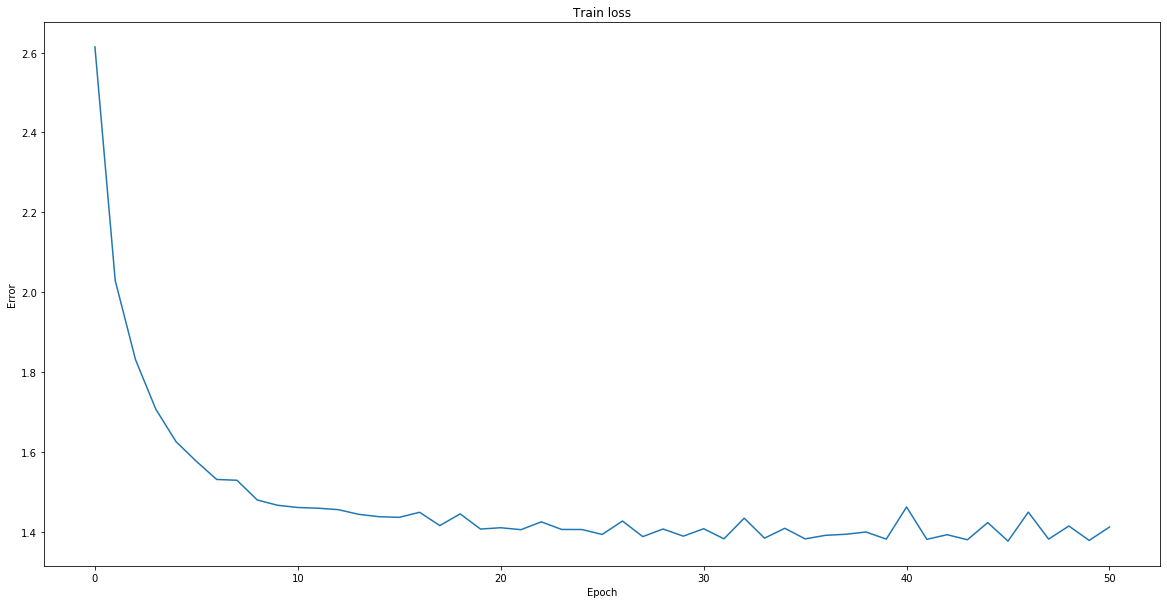

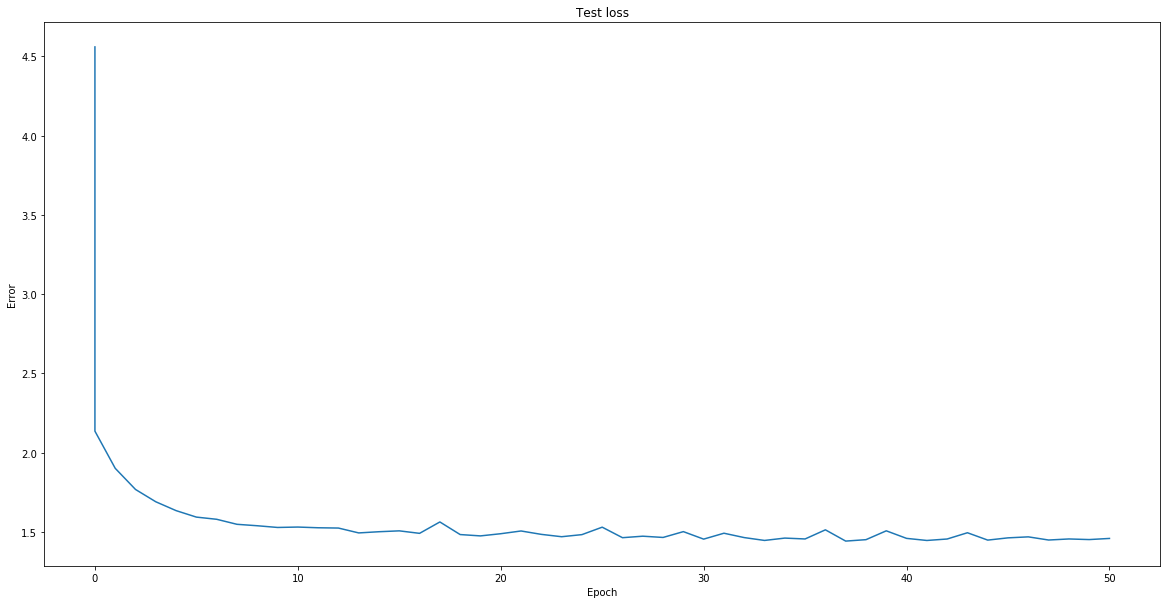

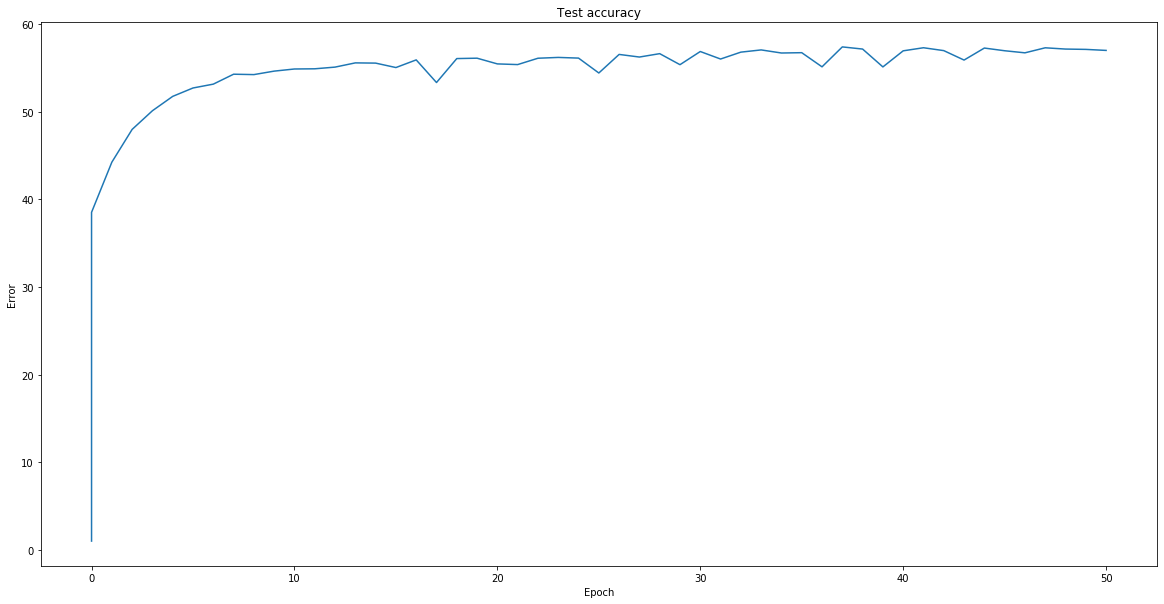

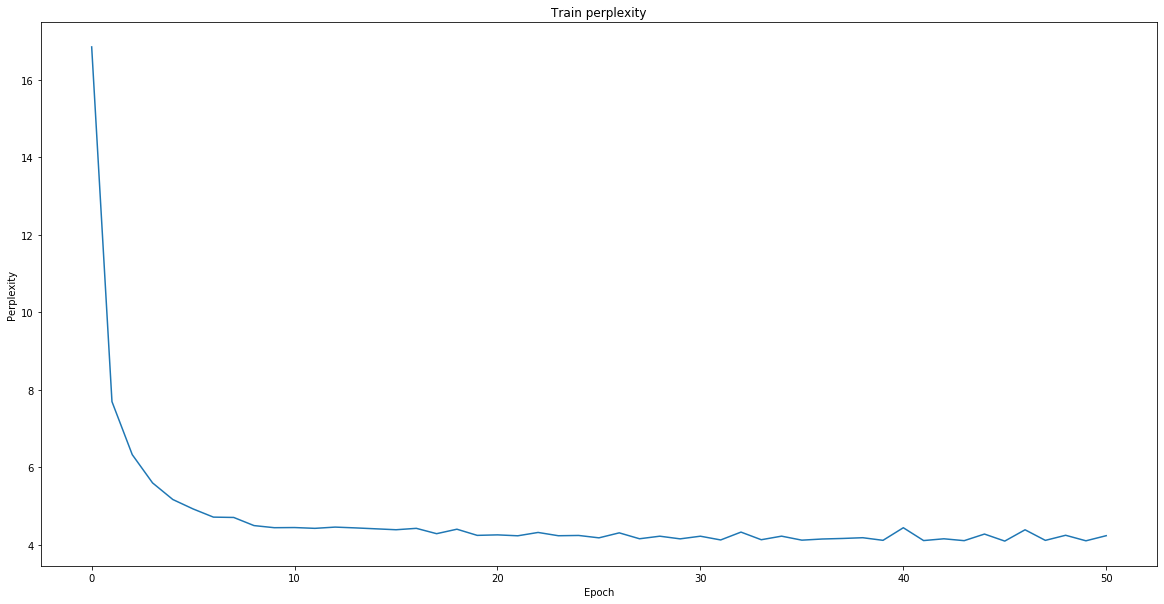

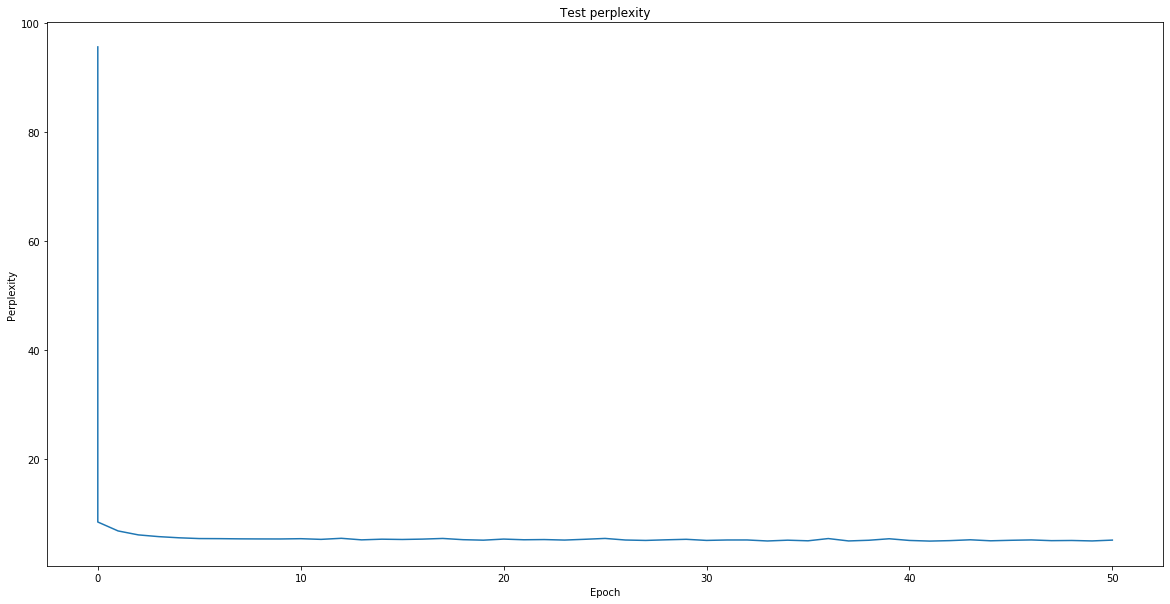

In [0]:
def main():
    # SEQUENCE_LENGTH = 100
    SEQUENCE_LENGTH = 200
    # BATCH_SIZE = 256
    BATCH_SIZE = 1000
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 50
    LEARNING_RATE = 0.002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/log_gru.pkl'


    data_train = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = HarryPotterDataset(DATA_PATH + 'harry_potter_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = HarryPotterNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_gru')
    train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))  
    test_perplexities.append((start_epoch, test_perplexity))
    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_perplexity = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_gru/%03d.pt' % epoch)
            seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            # generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            # print('generated max\t\t', generated_sentence)
            # for ii in range(10):
            #     generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
            #     print('generated sample\t', generated_sentence)
            # generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            # print('generated beam\t\t', generated_sentence)
            # print('')
    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_gru/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model, vocab, device = main()

#Part 7: Experiments

In [0]:
def eval_final_model(model, vocab, device):
    seed_words = 'Spells casted by'
    sequence_length = 200

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model, vocab, device)

generated with max	 Spells casted by the stairs and the stairs was a start of the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to the stairs and started to th
generated with sample	 Spells casted by the man who had been surprised to the back of the ward of the air and started to the stairs and the back of the stairs stopped on the stairs and a surprise of the way the starts of the time he had be
generated with sample	 Spells casted by the table to the castle and the way that he had not been the boy and the way to have heard the corridor of the control of the dark and said to the common room had been been to the water that the star
generated with sample	 Spells casted by the corridor to the prophecy of the stairs and straight the stairs and started to the fire last the parchment that he was all the side of the point of the way of the door and the stairs that he was s
generated with sample	 Spells casted by the

In [0]:
print(final_model)

Using device cuda
num workers: 2
HarryPotterNet(
  (encoder): Embedding(95, 512)
  (gru): GRU(512, 1024, batch_first=True)
  (decoder): Linear(in_features=1024, out_features=95, bias=True)
)


#Part 8: Other things
Choose **three** of the following to try. You should create new code cells below rather than modifying your earlier code:


1. Train on a different text corpus. The corpus should be **at least as large as the provided Harry Potter dataset**.
    - Options include other books, websites, tweets, wikipedia articles etc.
    -  (Hint: this is probably the easiest one)
1. Find a better network architecture. Some ideas:
    - Look at the various options in https://pytorch.org/docs/stable/nn.html#torch.nn.GRU
    - You can make the network wider or deeper.
    - You can try to learn separate encoders and decoders.
1. Use an LSTM instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM
    - The output of an LSTM is a hidden state **and** a cell state, so you will need to deal with a tuple instead of a single vector.
1. Use a Transformer instead of a GRU.
    - https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer
    - Be sure to get the masks right so you don't condition on the future characters: https://pytorch.org/docs/stable/nn.html#torch.nn.Transformer.generate_square_subsequent_mask may be of use.
1. Train a model using student-forcing.
    - You will have to modify the network inputs.
    - You will need to use `torch.nn.GRUCell` and its like. https://pytorch.org/docs/stable/nn.html#grucell
    - You cannot simply feed an empty string to start off a sequence. The sequence must be somehow conditioned on prior ground truth.
1. Train a model on words instead of characters.
    - You will need to redefine your input/output space vocabulary as well.
    - You should replace any words that occur less than 5 times in the dataset with an <unknown\> token. 
1. Write a new data loader which picks a random point in the text to start from and returns 10 consecutive sequences starting from that point onward. 
    - You should also modify the train and test functions to reset the memory when you reset the sequence.
    - You should consider an epoch to be feeding in approximately the number of characters in the dataset.
    - You may run into issues if your dataset size/epochs are not a multiple of your batch size.
1. Train on sentences instead of one long sequence.
    - You should still produce output character by character.
    - Sentences can end with a . ! ?, but words like Mr. generally do not end a sentence.
    - A sentence may also continue in the case of quotations. For example: ``"Do your homework!" said the TAs.`` is only one sentence.
    - Your parsing does not have to be perfect, but try to incorporate as many of these rules as you can.
    - Feel free to use existing NLP tools for finding sentence endings. One is spacy: https://spacy.io/usage/linguistic-features#section-sbd
    - All sentences should end with an <eos\> token. Your output sampling should now stop when it produces the <eos\> token.



#Part 9: Short answer questions
Please answer these questions, and put the answers in a file called short_answer.pdf in your repository.


1. Just like last time, provide plots for training error, test error, and test accuracy. Also provide a plot of your train and test perplexity per epoch.
    - In class we defined perplexity as `2^(p*log_2(q))`, However the PyTorch cross entropy function uses the natural log. To compute perplexity directly from the cross entropy, you should use `e^p*ln(q)`.
    - We encourage you to try multiple network modifications and hyperparameters, but you only need to provide plots for your best model. Please list the modifications and hyperparameters.    
    
2. What was your final test accuracy? What was your final test perplexity?
3. What was your favorite sentence generated via each of the sampling methods? What was the prompt you gave to generate that sentence?
4. Which sampling method seemed to generate the best results? Why do you think that is?
5. For sampling and beam search, try multiple temperatures between 0 and 2. 
    - Which produces the best outputs? Best as in made the most sense, your favorite, or funniest, doesn't really matter how you decide.
    - What does a temperature of 0 do? What does a temperature of 0<temp<1 do? What does a temperature of 1 do? What does a temperature of above 1 do? What would a negative temperature do (assuming the code allowed for negative temperature)?
    
Questions for each of the "Other things" sections. Only answer the questions corresponding to the ones you chose.

1. New Corpus
    1. What corpus did you choose? How many characters were in it?
    2. What differences did you notice between the sentences generated with the new/vs old corpus.
    3. Provide outputs for each sampling method on the **new corpus** (you can pick one temperature, but say what it was).

1. New Architecture
    1. What was your design? What did you try that didn't work well?
    2. What was your lowest test perplexity? Provide training and testing plots.
    3. Provide outputs for each sampling method on the **new corpus** (you can pick one temperature, but say what it was).

1. LSTM
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the **new corpus** (you can pick one temperature, but say what it was).

1. Transformer
    1. What new difficulties did you run into while training?
    2. Were results better than the GRU? Provide training and testing plots.
    3. Provide outputs for each sampling method on the new corpus (you can pick one temperature, but say what it was).
    
1. Student-forcing
    1. What new difficulties did you run into while training?
    2. Were the results better than with teacher-forcing?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was).
    
1. Words
    1. What new difficulties did you run into while training?
    2. How large was your vocabulary?
    3. Did you find that different batch size, sequence length, and feature size and other hyperparameters were needed? If so, what worked best for you?

1. Random Dataloader
    1. What new difficulties did you run into while training?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 
    
1. Sentences
    1. What new difficulties did you run into while training? What new difficulties did you run into while preprocessing?
    2. Were the results better than with the original dataloader?
    3. Provide some outputs for each sampling method (you can pick one temperature, but say what it was). 


    

# SECTION 2: **Train on a different text corpus**

Text Corpus: A song of ice and fire by G.Martin

Data source: http://persischempaka.blogspot.com/2012/04/game-of-thronestxt.html
https://www.sacred-texts.com/bib/osrc/index.htm

We will work in google drive because training takes long time and thus we need to store our model.

**You need to manually download the data since I dont have a server to host the scraped and clean data.**

In [12]:
os.chdir(BASE_PATH)
!wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
!tar -zxvf homework3.tar.gz
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
import pt_util

--2019-11-17 16:35:40--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework3.tar.gz
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2324076 (2.2M) [application/x-gzip]
Saving to: ‘homework3.tar.gz’

homework3.tar.gz    100%[===================>]   2.22M  2.49MB/s    in 0.9s    

2019-11-17 16:35:42 (2.49 MB/s) - ‘homework3.tar.gz’ saved [2324076/2324076]

harry_potter.txt
pt_util.py


#2.1: Preprocessing the data

In [13]:
def prepare_data_got(DATA_PATH):
  with open(DATA_PATH + 'got.txt', 'rb') as file:
    data = file.read()
    print("total number of charactesrs ", len(data))
  # data = ascii(data)
  data = data.decode('ascii')
  # regex = re.compile('\r')
  # data = regex.sub(' ', data)
  data = data.replace('~\r\n', ' ')
  data = data.replace('\n', ' ')
  data = data.replace('\r', ' ')
  data = data.replace('\t', ' ')

  symbols = [
      'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
      'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q',
      'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y',
      'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i',
      'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q',
      'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
      'z', ' ', '\'', '.', '?', ':', '-', '!',
      ',', ';', '"', '@', '#', '&', '*', '(',
      ')', '^', '$', '~', '`', '%', '<', '>',
      '/', '\\', '1', '2', '3', '4', '5', '6',
      '7', '8', '9', '0', '_', '+', '=', '[',
      ']', '{', '}', '\x1f', '|'
  ]
  voc2ind = { str(char): i for i, char in enumerate(symbols) }

  # Compute voc2ind and transform the data into an integer representation of the tokens.
  intData = np.zeros(len(data))
  for i, char in enumerate(data):
    # pass # TODO Fill this in
    intData[i] = voc2ind[char]


  ind2voc = {val: key for key, val in voc2ind.items()}

  train_text = intData[:int(len(intData)*0.8)] # TODO Fill this in
  test_text = intData[int(len(intData)*0.8):] # TODO Fill this in

  pickle.dump({'tokens': train_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'got_chars_train.pkl', 'wb'))
  pickle.dump({'tokens': test_text, 'ind2voc': ind2voc, 'voc2ind':voc2ind}, open(DATA_PATH + 'got_chars_test.pkl', 'wb'))
    
prepare_data_got(BASE_PATH)

class Vocabulary(object):
    def __init__(self, data_file):
        with open(data_file, 'rb') as data_file:
            dataset = pickle.load(data_file)
        self.ind2voc = dataset['ind2voc']
        self.voc2ind = dataset['voc2ind']

    # Returns a string representation of the tokens.
    def array_to_words(self, arr):
        return ''.join([self.ind2voc[int(ind)] for ind in arr])

    # Returns a torch tensor representing each token in words.
    def words_to_array(self, words):
        return torch.LongTensor([self.voc2ind[word] for word in words])

    # Returns the size of the vocabulary.
    def __len__(self):
        return len(self.voc2ind)

total number of charactesrs  9456059


Harry Potter has 6180222 characters. GOT 5 chapters have 9456059 characters.

#2.2: Loading the data

In [0]:
class GotDataset(torch.utils.data.Dataset):
    def __init__(self, data_file, sequence_length, batch_size):
        super(GotDataset, self).__init__()

        self.sequence_length = sequence_length
        self.batch_size = batch_size
        self.vocab = Vocabulary(data_file)

        with open(data_file, 'rb') as data_pkl:
            dataset = pickle.load(data_pkl)

        # TODO: Any preprocessing on the data to get it to the right shape.
        self.datas = dataset['tokens'][:-1]
        self.labels = dataset['tokens'][1:]

    def __len__(self):
        # TODO return the number of unique sequences you have, not the number of characters.
        # raise NotImplementedError 
        chop_length = (len(self.datas)+1)//self.batch_size    # length of each division
        num_entry = chop_length//self.sequence_length         # number of entries in a batch
        remainder = chop_length%self.sequence_length          # entry that does not fit sequence length
        offset = 1 if (remainder > 0) else 0
        number_of_batches = num_entry + offset
        number_of_unique_sequences = number_of_batches * self.batch_size
        return number_of_unique_sequences

    def __getitem__(self, idx):
        # Return the data and label for a character sequence as described above.
        # The data and labels should be torch long tensors.
        # You should return a single entry for the batch using the idx to decide which chunk you are 
        # in and how far down in the chunk you are.

        # data = None
        # return data[:-1], data[1:]
        sequence_length, batch_size = self.sequence_length, self.batch_size
        chop_length = (1+len(self.datas))//self.batch_size   # length of each division
        num_entry = chop_length//sequence_length # number of entries in a batch
        remainder = chop_length%sequence_length  # entry that does not fit sequence length

        offset = 1 if (remainder > 0) else 0
        number_of_batches = num_entry + offset
        number_of_unique_sequences = number_of_batches * batch_size

        batch = idx % batch_size
        element = idx // batch_size
        if (element < num_entry-1):
          start = batch*chop_length + (element)*sequence_length
          end   = batch*chop_length + (element+1)*sequence_length
        else:
          if (element == num_entry-1):
            idx_offset = 0 if (remainder > 0) else 1
            start = batch*chop_length + (element-1)*sequence_length
            end = batch*chop_length + (element)*sequence_length - idx_offset
          else:
            if (remainder > 0):
              start = batch*chop_length + (element)*sequence_length
              end = batch*chop_length + (element)*sequence_length + 1
        data = self.datas[start:end]
        label = self.labels[start:end]
        return torch.from_numpy(data).long(), torch.from_numpy(label).long()
    
    def vocab_size(self):
        return len(self.vocab)

#2.3: Defining the Network

In [0]:
class GotNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(GotNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]

        x = self.encoder(x)
        x, hidden_state = self.gru(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#2.4: Training

In [0]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    perplexities = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        perplexity = np.exp(loss.item())
        losses.append(loss.item())
        perplexities.append(perplexity)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses), np.mean(perplexities)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    test_perplexity = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            c_loss = model.loss(output, label, reduction='mean').item()
            test_loss += c_loss
            test_perplexity += np.exp(c_loss)
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 100 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)
    test_perplexity /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Average perplexity: {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length),
        test_perplexity))
    return test_loss, test_accuracy, test_perplexity

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([96, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
decoder.weight -> 	torch.Size([96, 512]) = 0MB
decoder.bias -> 	torch.Size([96]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/colab_files/homework3/checkpoints_got/088.pt
Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	t"e  caiep ess toght ahmn aene ht  lf aoel  Tr ore heog ahe was aonhting tf  tnsern an honna   aeoyeee  



  0%|          | 0/38 [00:00<?, ?it/s]


Test set: Average loss: 1.5050, Accuracy: 1049197/1894400 (55%), Average perplexity: 5.7663





  3%|▎         | 1/38 [00:01<00:48,  1.30s/it]

Train Epoch: 88 [0/38000 (0%)]	Loss: 1.383327




  5%|▌         | 2/38 [00:02<00:44,  1.25s/it]

  8%|▊         | 3/38 [00:03<00:42,  1.22s/it]

 11%|█         | 4/38 [00:04<00:41,  1.21s/it]

 13%|█▎        | 5/38 [00:05<00:40,  1.21s/it]

 16%|█▌        | 6/38 [00:07<00:37,  1.19s/it]

 18%|█▊        | 7/38 [00:08<00:36,  1.17s/it]

 21%|██        | 8/38 [00:09<00:35,  1.18s/it]

 24%|██▎       | 9/38 [00:10<00:33,  1.16s/it]

 26%|██▋       | 10/38 [00:11<00:32,  1.15s/it]

 29%|██▉       | 11/38 [00:12<00:31,  1.17s/it]

Train Epoch: 88 [10000/38000 (26%)]	Loss: 1.525684




 32%|███▏      | 12/38 [00:14<00:30,  1.17s/it]

 34%|███▍      | 13/38 [00:15<00:28,  1.16s/it]

 37%|███▋      | 14/38 [00:16<00:27,  1.15s/it]

 39%|███▉      | 15/38 [00:17<00:26,  1.16s/it]

 42%|████▏     | 16/38 [00:18<00:25,  1.15s/it]

 45%|████▍     | 17/38 [00:19<00:24,  1.15s/it]

 47%|████▋     | 18/38 [00:20<00:23,  1.16s/it]

 50%|█████     | 19/38 [00:22<00:22,  1.17s/it]

 53%|█████▎    | 20/38 [00:23<00:20,  1.16s/it]

 55%|█████▌    | 21/38 [00:24<00:19,  1.15s/it]

Train Epoch: 88 [20000/38000 (53%)]	Loss: 1.425003




 58%|█████▊    | 22/38 [00:25<00:18,  1.16s/it]

 61%|██████    | 23/38 [00:26<00:17,  1.15s/it]

 63%|██████▎   | 24/38 [00:27<00:16,  1.15s/it]

 66%|██████▌   | 25/38 [00:29<00:14,  1.14s/it]

 68%|██████▊   | 26/38 [00:30<00:13,  1.16s/it]

 71%|███████   | 27/38 [00:31<00:12,  1.17s/it]

 74%|███████▎  | 28/38 [00:32<00:11,  1.15s/it]

 76%|███████▋  | 29/38 [00:33<00:10,  1.17s/it]

 79%|███████▉  | 30/38 [00:34<00:09,  1.15s/it]

 82%|████████▏ | 31/38 [00:35<00:08,  1.15s/it]

Train Epoch: 88 [30000/38000 (79%)]	Loss: 1.394543




 84%|████████▍ | 32/38 [00:37<00:06,  1.16s/it]

 87%|████████▋ | 33/38 [00:38<00:05,  1.17s/it]

 89%|████████▉ | 34/38 [00:39<00:04,  1.16s/it]

 92%|█████████▏| 35/38 [00:40<00:03,  1.15s/it]

 95%|█████████▍| 36/38 [00:41<00:02,  1.16s/it]

 97%|█████████▋| 37/38 [00:42<00:01,  1.16s/it]

100%|██████████| 38/38 [00:43<00:00,  1.13s/it]

Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	t"e  caiep ess toght at n aene ht  lf aoel  Tr ore toog aoa was aonhting an  tnsern tn tonna  aaaoyeee  tnout the saoct  en  aralte  The woone en n  were sainheaath tir  an weemed   he  lodk en ds  wr






  0%|          | 0/38 [00:00<?, ?it/s]


Test set: Average loss: 1.5159, Accuracy: 1044486/1894400 (55%), Average perplexity: 6.0004

Saved /gdrive/My Drive/colab_files/homework3/checkpoints_got/088.pt





  3%|▎         | 1/38 [00:01<00:45,  1.23s/it]

Train Epoch: 89 [0/38000 (0%)]	Loss: 1.392276




  5%|▌         | 2/38 [00:02<00:44,  1.22s/it]

  8%|▊         | 3/38 [00:03<00:41,  1.19s/it]

 11%|█         | 4/38 [00:04<00:40,  1.20s/it]

 13%|█▎        | 5/38 [00:05<00:38,  1.17s/it]

 16%|█▌        | 6/38 [00:06<00:37,  1.16s/it]

 18%|█▊        | 7/38 [00:08<00:35,  1.15s/it]

 21%|██        | 8/38 [00:09<00:35,  1.17s/it]

 24%|██▎       | 9/38 [00:10<00:34,  1.17s/it]

 26%|██▋       | 10/38 [00:11<00:33,  1.18s/it]

 29%|██▉       | 11/38 [00:12<00:31,  1.17s/it]

Train Epoch: 89 [10000/38000 (26%)]	Loss: 1.384872




 32%|███▏      | 12/38 [00:13<00:29,  1.15s/it]

 34%|███▍      | 13/38 [00:15<00:28,  1.14s/it]

 37%|███▋      | 14/38 [00:16<00:27,  1.14s/it]

 39%|███▉      | 15/38 [00:17<00:26,  1.14s/it]

 42%|████▏     | 16/38 [00:18<00:25,  1.16s/it]

 45%|████▍     | 17/38 [00:19<00:24,  1.17s/it]

 47%|████▋     | 18/38 [00:20<00:23,  1.15s/it]

 50%|█████     | 19/38 [00:22<00:21,  1.14s/it]

 53%|█████▎    | 20/38 [00:23<00:20,  1.14s/it]

 55%|█████▌    | 21/38 [00:24<00:19,  1.14s/it]

Train Epoch: 89 [20000/38000 (53%)]	Loss: 1.374692




 58%|█████▊    | 22/38 [00:25<00:18,  1.14s/it]

 61%|██████    | 23/38 [00:26<00:17,  1.16s/it]

 63%|██████▎   | 24/38 [00:27<00:16,  1.16s/it]

 66%|██████▌   | 25/38 [00:28<00:14,  1.15s/it]

 68%|██████▊   | 26/38 [00:30<00:13,  1.14s/it]

 71%|███████   | 27/38 [00:31<00:12,  1.14s/it]

 74%|███████▎  | 28/38 [00:32<00:11,  1.13s/it]

 76%|███████▋  | 29/38 [00:33<00:10,  1.13s/it]

 79%|███████▉  | 30/38 [00:34<00:09,  1.16s/it]

 82%|████████▏ | 31/38 [00:35<00:08,  1.17s/it]

Train Epoch: 89 [30000/38000 (79%)]	Loss: 1.370871




 84%|████████▍ | 32/38 [00:36<00:06,  1.16s/it]

 87%|████████▋ | 33/38 [00:38<00:05,  1.15s/it]

 89%|████████▉ | 34/38 [00:39<00:04,  1.14s/it]

 92%|█████████▏| 35/38 [00:40<00:03,  1.13s/it]

 95%|█████████▍| 36/38 [00:41<00:02,  1.13s/it]

 97%|█████████▋| 37/38 [00:42<00:01,  1.13s/it]

100%|██████████| 38/38 [00:42<00:00,  1.12s/it]

Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	t"e  caiep ess ooght atmn aane ht  lf aoel  Tr ore hoog ate was aonhting af  t sern an wonna  aaaoyeee  tnout the soocte en  aralte. The stone en n  were aainheaith air  an weemed   he  oonk en ds  ar






  0%|          | 0/38 [00:00<?, ?it/s]


Test set: Average loss: 1.4989, Accuracy: 1053927/1894400 (56%), Average perplexity: 5.8062

Saved /gdrive/My Drive/colab_files/homework3/checkpoints_got/089.pt





  3%|▎         | 1/38 [00:01<00:46,  1.25s/it]

Train Epoch: 90 [0/38000 (0%)]	Loss: 1.376542




  5%|▌         | 2/38 [00:02<00:43,  1.21s/it]

  8%|▊         | 3/38 [00:03<00:42,  1.21s/it]

 11%|█         | 4/38 [00:04<00:40,  1.18s/it]

 13%|█▎        | 5/38 [00:05<00:39,  1.18s/it]

 16%|█▌        | 6/38 [00:07<00:37,  1.17s/it]

 18%|█▊        | 7/38 [00:08<00:35,  1.16s/it]

 21%|██        | 8/38 [00:09<00:34,  1.15s/it]

 24%|██▎       | 9/38 [00:10<00:33,  1.16s/it]

 26%|██▋       | 10/38 [00:11<00:32,  1.17s/it]

 29%|██▉       | 11/38 [00:12<00:31,  1.17s/it]

Train Epoch: 90 [10000/38000 (26%)]	Loss: 1.377018




 32%|███▏      | 12/38 [00:14<00:30,  1.18s/it]

 34%|███▍      | 13/38 [00:15<00:29,  1.18s/it]

 37%|███▋      | 14/38 [00:16<00:27,  1.16s/it]

 39%|███▉      | 15/38 [00:17<00:26,  1.15s/it]

 42%|████▏     | 16/38 [00:18<00:25,  1.14s/it]

 45%|████▍     | 17/38 [00:19<00:24,  1.16s/it]

 47%|████▋     | 18/38 [00:20<00:23,  1.17s/it]

 50%|█████     | 19/38 [00:22<00:22,  1.18s/it]

 53%|█████▎    | 20/38 [00:23<00:20,  1.16s/it]

 55%|█████▌    | 21/38 [00:24<00:19,  1.16s/it]

Train Epoch: 90 [20000/38000 (53%)]	Loss: 1.370643




 58%|█████▊    | 22/38 [00:25<00:18,  1.15s/it]

 61%|██████    | 23/38 [00:26<00:17,  1.16s/it]

 63%|██████▎   | 24/38 [00:27<00:16,  1.15s/it]

 66%|██████▌   | 25/38 [00:29<00:15,  1.17s/it]

 68%|██████▊   | 26/38 [00:30<00:14,  1.17s/it]

 71%|███████   | 27/38 [00:31<00:12,  1.18s/it]

 74%|███████▎  | 28/38 [00:32<00:11,  1.16s/it]

 76%|███████▋  | 29/38 [00:33<00:10,  1.15s/it]

 79%|███████▉  | 30/38 [00:34<00:09,  1.16s/it]

 82%|████████▏ | 31/38 [00:36<00:08,  1.17s/it]

Train Epoch: 90 [30000/38000 (79%)]	Loss: 1.368754




 84%|████████▍ | 32/38 [00:37<00:07,  1.18s/it]

 87%|████████▋ | 33/38 [00:38<00:05,  1.18s/it]

 89%|████████▉ | 34/38 [00:39<00:04,  1.18s/it]

 92%|█████████▏| 35/38 [00:40<00:03,  1.16s/it]

 95%|█████████▍| 36/38 [00:41<00:02,  1.15s/it]

 97%|█████████▋| 37/38 [00:42<00:01,  1.14s/it]

100%|██████████| 38/38 [00:43<00:00,  1.13s/it]

Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	t"e  caiep es  toght at n aane ht  lf aoel  Tr ore hiog ate was aonhting af  t sern an wonna  aaaoyeee  tnout the soocte en  aralte  The stene en n  were saineeaith air  at weemed   he  oogk en ds  wr



Test set: Average loss: 1.4971, Accuracy: 1054034/1894400 (56%), Average perplexity: 5.7608

Saved /gdrive/My Drive/colab_files/homework3/checkpoints_got/090.pt

Saving final model
Saved /gdrive/My Drive/colab_files/homework3/checkpoints_got/090.pt



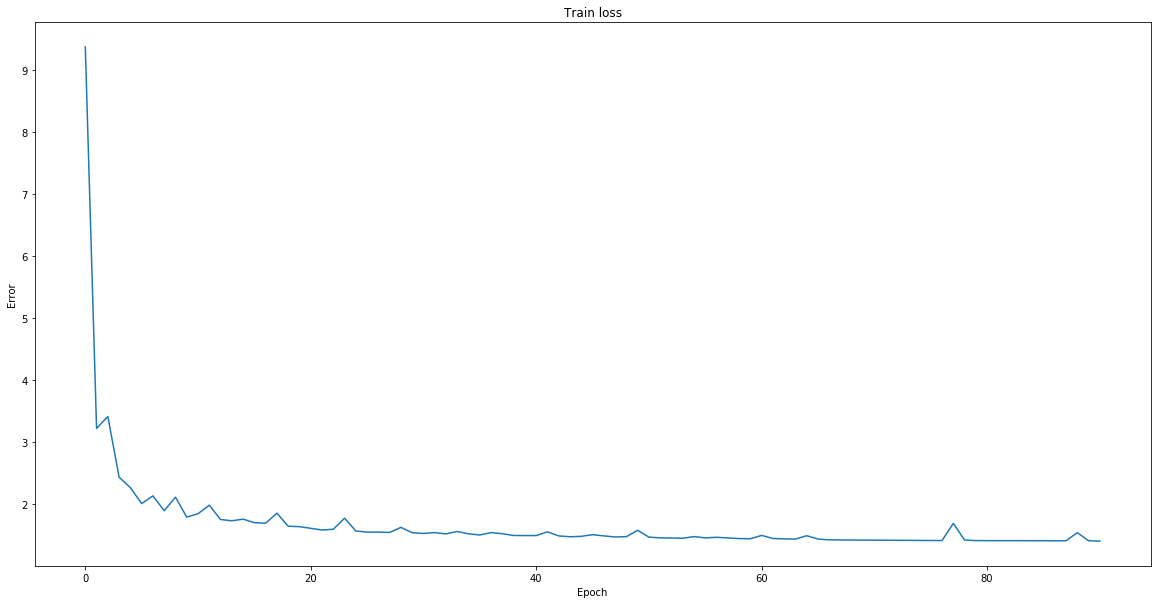

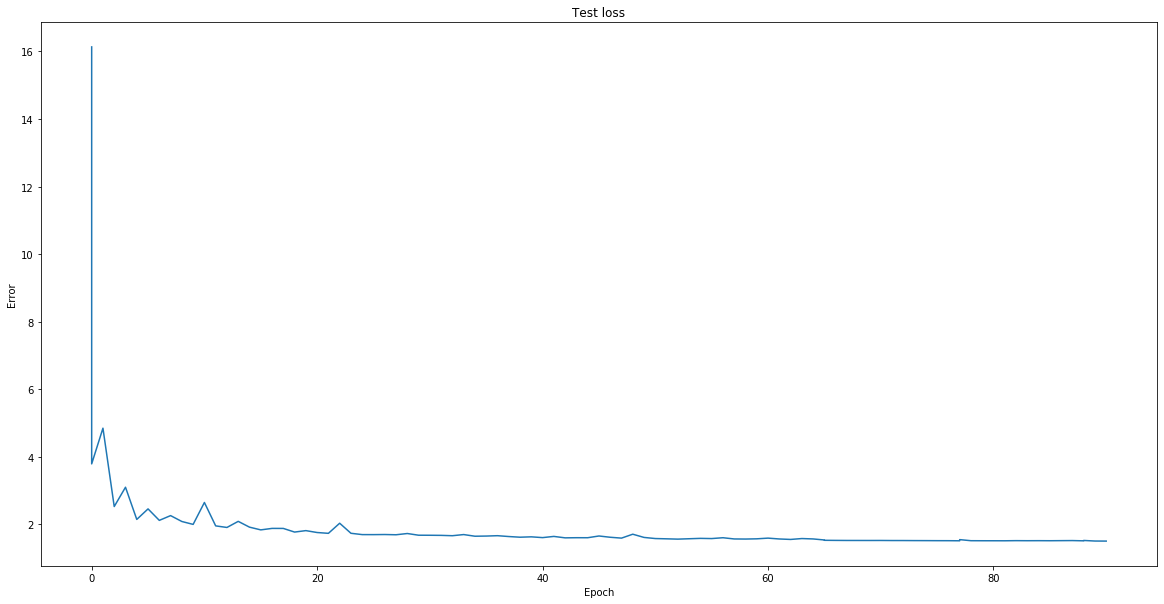

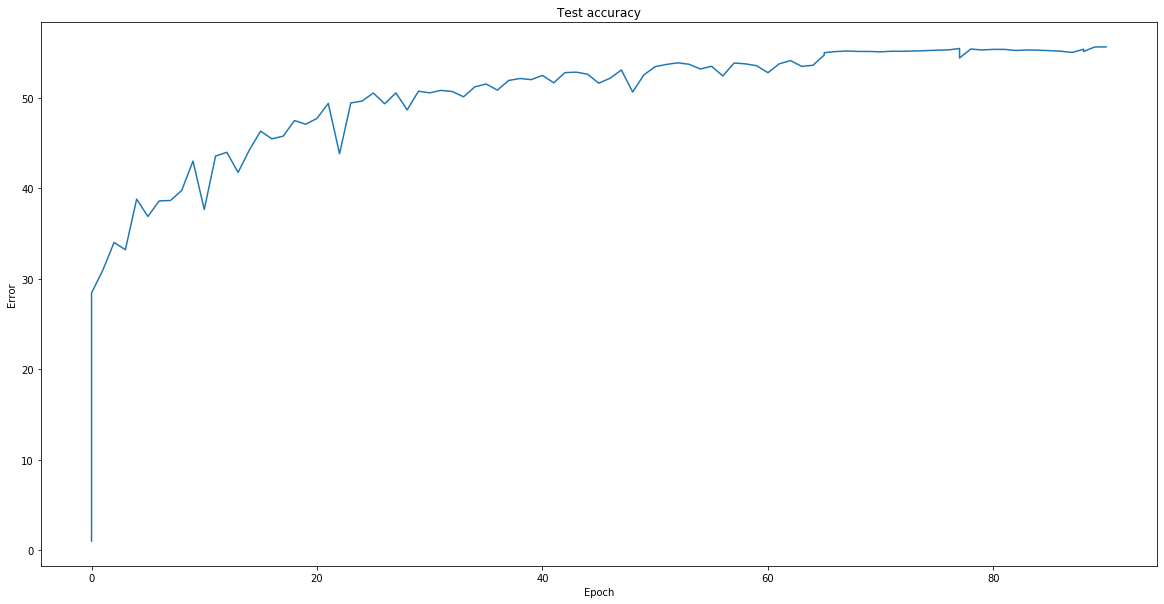

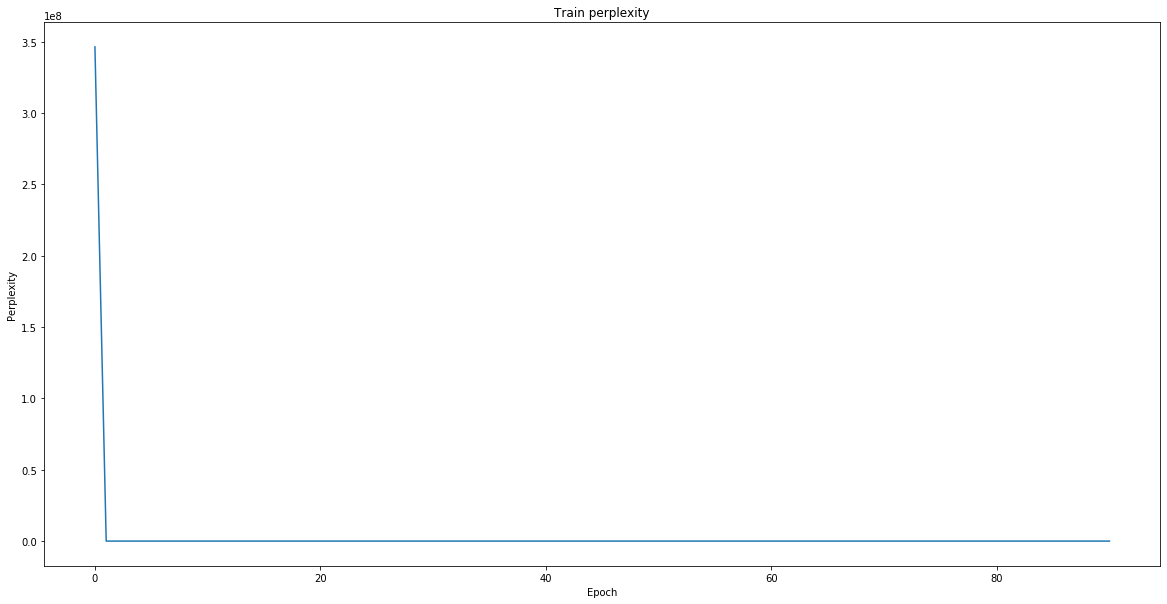

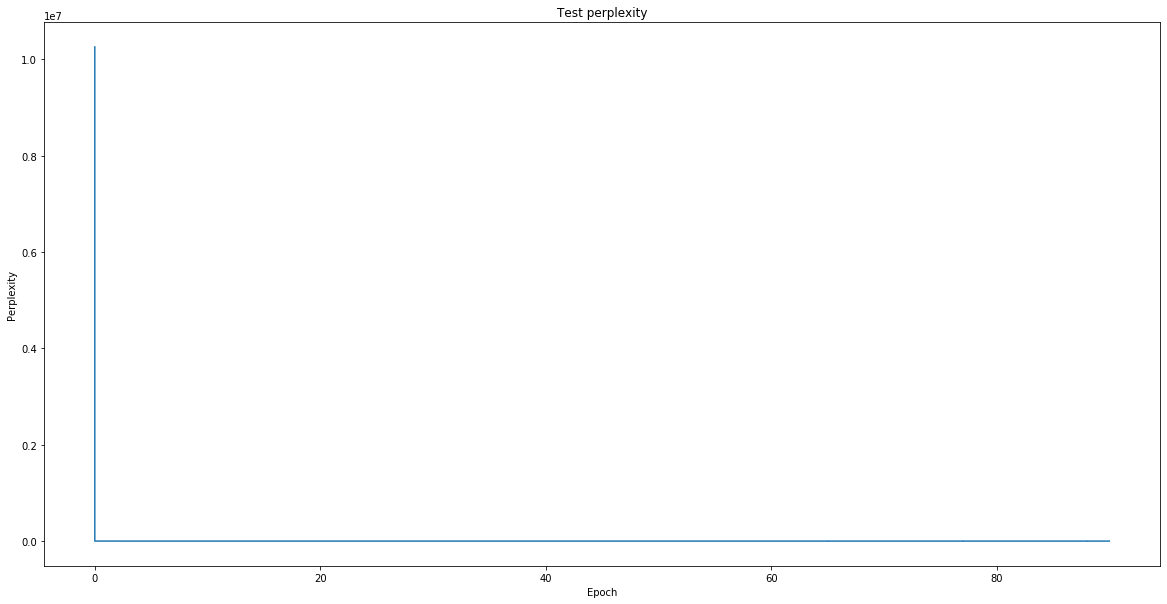

In [0]:
def main(DATA_PATH):
    # SEQUENCE_LENGTH = 100
    SEQUENCE_LENGTH = 200
    # BATCH_SIZE = 256
    BATCH_SIZE = 1000
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 90
    # LEARNING_RATE = 0.002
    LEARNING_RATE = 0.0005
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/got_log.pkl'


    data_train = GotDataset(DATA_PATH + 'got_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = GotDataset(DATA_PATH + 'got_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = GotNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_got')
    train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))  
    test_perplexities.append((start_epoch, test_perplexity))
    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_perplexity = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_got/%03d.pt' % epoch)
            # seed_words = 'The dragon '
            # generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            # print('generated max\t\t', generated_sentence)
            # for ii in range(10):
            #     generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
            #     print('generated sample\t', generated_sentence)
            # generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            # print('generated beam\t\t', generated_sentence)
            # print('')
    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_got/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model_got, vocab_got, device_got = main(BASE_PATH)

#2.5: Experiments

In [0]:
TEMPERATURE = 0.3
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # raise NotImplementedError
        probability, prev_arr = output.max(-1)
        outputs.append(prev_arr)
        output, hidden = model.inference(prev_arr.long(), hidden, TEMPERATURE)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # raise NotImplementedError
        sample = torch.multinomial(output, 1)[0]
        outputs.append(sample)
        output, hidden = model.inference(sample.long(), hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    # beam = [([], output, hidden, 0)]
    # TODO
    # raise NotImplementedError
    # A. Initialize the beam list with the single existing empty beam
    beams = [([], output, hidden, 0)]
    # B. Repeat for the sequence length:
    for ii in range(sequence_length):
      new_beams = []
      # 1. For each beam in the beam list:
      for beam in beams:
        # a. Sample from the distribution with replacement
        samples = torch.multinomial(beam[1], beam_width, replacement=True)[0]
        # b. Compute its score
        log_prob = torch.log(beam[1][0, samples])
        # c. Pick the top N samples from a beam
        values, indices = torch.topk(log_prob, beam_width)
        # d. For each top N beams
        for ind in indices:
          # i. Compute the next distribution over the output space for that state
          next_out, next_hidden = model.inference(samples[ind].long(), beam[2], TEMPERATURE)
          # ii. Add sample to new beam list
          new_beams.append((beam[0]+[samples[ind]], next_out, next_hidden, log_prob[ind]+beam[-1]))
      # 2. Pick the top N beams
      scores = torch.tensor([ beam[-1] for beam in new_beams])
      values, indices = torch.topk(scores, beam_width)
      beams = [ new_beams[ind] for ind in indices ]
    # C. Return the top beam's chosen values.
    # Shuffle list so that in case of tie, we pick at random
    np.random.shuffle(beams)
    scores =  torch.tensor([ beam[-1] for beam in beams ])
    val, ind = torch.topk(scores, 1)
    outputs = beams[ind][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)
        
        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

In [0]:
def eval_final_model(model, vocab, device):
    seed_words = 'The dragon ate'
    sequence_length = 100

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model_got, vocab_got, device_got)

generated with max	 The dragon ate his sister and the streets of the  stone of the courtes of the steps of the steps of the steps of t
generated with sample	 The dragon ate the castle of the castle Baratheon  and the commands of the boy was still and stranger every to the
generated with sample	 The dragon ateven her head of the  black of the walls of the fire and the courtes of the countains of the crown of
generated with sample	 The dragon ate him. "I am the same to pie  with the right of the courage to the stars. I was the same to go to the
generated with sample	 The dragon ately the way the gods of the stone of the  stone of the castle of the lands of the red beard and a com
generated with sample	 The dragon ate a little black of her breasts. As we did not have been  and beautiful to make him and stone and the
generated with sample	 The dragon ate her brother and the first time the  stars with the good of the direwolf was a child of starts of th
generated with sample	 The dragon ate

In [0]:
print(final_model_got)

GotNet(
  (encoder): Embedding(96, 512)
  (gru): GRU(512, 512, batch_first=True)
  (decoder): Linear(in_features=512, out_features=96, bias=True)
)


# SECTION 3: **Use an LSTM instead of a GRU**

#3.1: Defining the Network

Remember to run Part 2, 3, 5, 6a

In [0]:
TEMPERATURE = 0.3

class GotLSTMNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(GotLSTMNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.lstm = nn.LSTM(self.feature_size, self.feature_size, batch_first=True, num_layers=1)
        self.decoder = nn.Linear(self.feature_size, self.vocab_size)
        
        # This shares the encoder and decoder weights as described in lecture.
        # self.decoder.weight = self.encoder.weight
        self.decoder.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # raise NotImplementedError
        x = self.encoder(x)
        x, hidden_state = self.lstm(x, hidden_state)
        x = self.decoder(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

#3.2: Training

In [0]:
import tqdm
def repackage_hidden_lstm(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

def train_lstm(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    perplexities = []
    hidden = None
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(train_loader)):
        data, label = data.to(device), label.to(device)
        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
          # Since we have two hidden states now
          (state_h, state_c) = hidden
          state_h = repackage_hidden_lstm(state_h)
          state_c = repackage_hidden_lstm(state_c)
          hidden = (state_h, state_c)
        optimizer.zero_grad()
        output, hidden = model(data)
        pred = output.max(-1)[1]
        loss = model.loss(output, label)
        perplexity = np.exp(loss.item())
        losses.append(loss.item())
        perplexities.append(perplexity)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses), np.mean(perplexities)


def test_lstm(model, device, test_loader):
    model.eval()
    test_loss = 0
    test_perplexity = 0
    correct = 0

    with torch.no_grad():
        hidden = None
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output, hidden = model(data, hidden)
            c_loss = model.loss(output, label, reduction='mean').item()
            test_loss += c_loss
            test_perplexity += np.exp(c_loss)
            pred = output.max(-1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            # Comment this out to avoid printing test results
            if batch_idx % 100 == 0:
                print('Input\t%s\nGT\t%s\npred\t%s\n\n' % (
                    test_loader.dataset.vocab.array_to_words(data[0]),
                    test_loader.dataset.vocab.array_to_words(label[0]),
                    test_loader.dataset.vocab.array_to_words(pred[0])))

    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length)
    test_perplexity /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Average perplexity: {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset) * test_loader.dataset.sequence_length,
        100. * correct / (len(test_loader.dataset) * test_loader.dataset.sequence_length),
        test_perplexity))
    return test_loss, test_accuracy, test_perplexity

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([96, 700]) = 0MB
lstm.weight_ih_l0 -> 	torch.Size([2800, 700]) = 7MB
lstm.weight_hh_l0 -> 	torch.Size([2800, 700]) = 7MB
lstm.bias_ih_l0 -> 	torch.Size([2800]) = 0MB
lstm.bias_hh_l0 -> 	torch.Size([2800]) = 0MB
decoder.weight -> 	torch.Size([96, 700]) = 0MB
decoder.bias -> 	torch.Size([96]) = 0MB

Restored all variables
No new variables
Restored /gdrive/My Drive/colab_files/homework3/checkpoints_lstm/018.pt
Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	aaar boeep ess aoght ao neaane tn  lf.toet   utore tong aoe was aorhting af  t  ore on tonlaleaaaey




  0%|          | 0/148 [00:00<?, ?it/s]


Test set: Average loss: 1.6069, Accuracy: 988821/1894400 (52%), Average perplexity: 5.5892






  1%|          | 1/148 [00:00<01:59,  1.23it/s]

Train Epoch: 18 [0/37888 (0%)]	Loss: 1.490478





  1%|▏         | 2/148 [00:01<01:55,  1.26it/s]


  2%|▏         | 3/148 [00:02<01:53,  1.28it/s]


  3%|▎         | 4/148 [00:03<01:50,  1.30it/s]


  3%|▎         | 5/148 [00:03<01:48,  1.31it/s]


  4%|▍         | 6/148 [00:04<01:47,  1.32it/s]


  5%|▍         | 7/148 [00:05<01:47,  1.31it/s]


  5%|▌         | 8/148 [00:06<01:45,  1.32it/s]


  6%|▌         | 9/148 [00:06<01:45,  1.32it/s]


  7%|▋         | 10/148 [00:07<01:44,  1.33it/s]


  7%|▋         | 11/148 [00:08<01:43,  1.33it/s]

Train Epoch: 18 [2560/37888 (7%)]	Loss: 1.435969





  8%|▊         | 12/148 [00:09<01:41,  1.33it/s]


  9%|▉         | 13/148 [00:09<01:41,  1.33it/s]


  9%|▉         | 14/148 [00:10<01:39,  1.34it/s]


 10%|█         | 15/148 [00:11<01:40,  1.33it/s]


 11%|█         | 16/148 [00:12<01:38,  1.34it/s]


 11%|█▏        | 17/148 [00:12<01:37,  1.34it/s]


 12%|█▏        | 18/148 [00:13<01:37,  1.34it/s]


 13%|█▎        | 19/148 [00:14<01:36,  1.33it/s]


 14%|█▎        | 20/148 [00:15<01:35,  1.34it/s]


 14%|█▍        | 21/148 [00:15<01:35,  1.33it/s]

Train Epoch: 18 [5120/37888 (14%)]	Loss: 1.416330





 15%|█▍        | 22/148 [00:16<01:34,  1.34it/s]


 16%|█▌        | 23/148 [00:17<01:33,  1.34it/s]


 16%|█▌        | 24/148 [00:18<01:33,  1.33it/s]


 17%|█▋        | 25/148 [00:18<01:32,  1.33it/s]


 18%|█▊        | 26/148 [00:19<01:31,  1.33it/s]


 18%|█▊        | 27/148 [00:20<01:31,  1.32it/s]


 19%|█▉        | 28/148 [00:21<01:30,  1.32it/s]


 20%|█▉        | 29/148 [00:21<01:29,  1.33it/s]


 20%|██        | 30/148 [00:22<01:29,  1.32it/s]


 21%|██        | 31/148 [00:23<01:28,  1.32it/s]

Train Epoch: 18 [7680/37888 (20%)]	Loss: 1.425254





 22%|██▏       | 32/148 [00:24<01:27,  1.33it/s]


 22%|██▏       | 33/148 [00:24<01:26,  1.33it/s]


 23%|██▎       | 34/148 [00:25<01:25,  1.34it/s]


 24%|██▎       | 35/148 [00:26<01:24,  1.34it/s]


 24%|██▍       | 36/148 [00:27<01:23,  1.34it/s]


 25%|██▌       | 37/148 [00:27<01:22,  1.34it/s]


 26%|██▌       | 38/148 [00:28<01:22,  1.33it/s]


 26%|██▋       | 39/148 [00:29<01:21,  1.33it/s]


 27%|██▋       | 40/148 [00:30<01:20,  1.34it/s]


 28%|██▊       | 41/148 [00:30<01:20,  1.33it/s]

Train Epoch: 18 [10240/37888 (27%)]	Loss: 1.410633





 28%|██▊       | 42/148 [00:31<01:19,  1.33it/s]


 29%|██▉       | 43/148 [00:32<01:18,  1.33it/s]


 30%|██▉       | 44/148 [00:33<01:17,  1.34it/s]


 30%|███       | 45/148 [00:33<01:16,  1.34it/s]


 31%|███       | 46/148 [00:34<01:15,  1.34it/s]


 32%|███▏      | 47/148 [00:35<01:15,  1.34it/s]


 32%|███▏      | 48/148 [00:36<01:15,  1.33it/s]


 33%|███▎      | 49/148 [00:36<01:14,  1.33it/s]


 34%|███▍      | 50/148 [00:37<01:13,  1.33it/s]


 34%|███▍      | 51/148 [00:38<01:13,  1.32it/s]

Train Epoch: 18 [12800/37888 (34%)]	Loss: 1.422261





 35%|███▌      | 52/148 [00:39<01:12,  1.33it/s]


 36%|███▌      | 53/148 [00:39<01:11,  1.33it/s]


 36%|███▋      | 54/148 [00:40<01:11,  1.32it/s]


 37%|███▋      | 55/148 [00:41<01:10,  1.32it/s]


 38%|███▊      | 56/148 [00:42<01:08,  1.34it/s]


 39%|███▊      | 57/148 [00:42<01:08,  1.33it/s]


 39%|███▉      | 58/148 [00:43<01:07,  1.34it/s]


 40%|███▉      | 59/148 [00:44<01:06,  1.34it/s]


 41%|████      | 60/148 [00:45<01:06,  1.33it/s]


 41%|████      | 61/148 [00:45<01:05,  1.33it/s]

Train Epoch: 18 [15360/37888 (41%)]	Loss: 1.440376





 42%|████▏     | 62/148 [00:46<01:04,  1.33it/s]


 43%|████▎     | 63/148 [00:47<01:04,  1.33it/s]


 43%|████▎     | 64/148 [00:48<01:02,  1.34it/s]


 44%|████▍     | 65/148 [00:48<01:02,  1.33it/s]


 45%|████▍     | 66/148 [00:49<01:01,  1.33it/s]


 45%|████▌     | 67/148 [00:50<01:01,  1.33it/s]


 46%|████▌     | 68/148 [00:51<00:59,  1.33it/s]


 47%|████▋     | 69/148 [00:51<00:59,  1.33it/s]


 47%|████▋     | 70/148 [00:52<00:58,  1.33it/s]


 48%|████▊     | 71/148 [00:53<00:58,  1.32it/s]

Train Epoch: 18 [17920/37888 (47%)]	Loss: 1.419018





 49%|████▊     | 72/148 [00:54<00:57,  1.33it/s]


 49%|████▉     | 73/148 [00:54<00:56,  1.33it/s]


 50%|█████     | 74/148 [00:55<00:55,  1.33it/s]


 51%|█████     | 75/148 [00:56<00:54,  1.33it/s]


 51%|█████▏    | 76/148 [00:57<00:54,  1.33it/s]


 52%|█████▏    | 77/148 [00:57<00:53,  1.33it/s]


 53%|█████▎    | 78/148 [00:58<00:52,  1.33it/s]


 53%|█████▎    | 79/148 [00:59<00:51,  1.34it/s]


 54%|█████▍    | 80/148 [01:00<00:50,  1.34it/s]


 55%|█████▍    | 81/148 [01:00<00:49,  1.34it/s]

Train Epoch: 18 [20480/37888 (54%)]	Loss: 1.426328





 55%|█████▌    | 82/148 [01:01<00:49,  1.34it/s]


 56%|█████▌    | 83/148 [01:02<00:48,  1.34it/s]


 57%|█████▋    | 84/148 [01:03<00:47,  1.33it/s]


 57%|█████▋    | 85/148 [01:03<00:47,  1.33it/s]


 58%|█████▊    | 86/148 [01:04<00:46,  1.33it/s]


 59%|█████▉    | 87/148 [01:05<00:45,  1.33it/s]


 59%|█████▉    | 88/148 [01:06<00:45,  1.33it/s]


 60%|██████    | 89/148 [01:06<00:44,  1.34it/s]


 61%|██████    | 90/148 [01:07<00:43,  1.33it/s]


 61%|██████▏   | 91/148 [01:08<00:42,  1.34it/s]

Train Epoch: 18 [23040/37888 (61%)]	Loss: 1.413347





 62%|██████▏   | 92/148 [01:09<00:41,  1.33it/s]


 63%|██████▎   | 93/148 [01:09<00:41,  1.34it/s]


 64%|██████▎   | 94/148 [01:10<00:40,  1.34it/s]


 64%|██████▍   | 95/148 [01:11<00:39,  1.34it/s]


 65%|██████▍   | 96/148 [01:12<00:38,  1.35it/s]


 66%|██████▌   | 97/148 [01:12<00:37,  1.34it/s]


 66%|██████▌   | 98/148 [01:13<00:37,  1.34it/s]


 67%|██████▋   | 99/148 [01:14<00:36,  1.34it/s]


 68%|██████▊   | 100/148 [01:15<00:35,  1.35it/s]


 68%|██████▊   | 101/148 [01:15<00:35,  1.34it/s]

Train Epoch: 18 [25600/37888 (68%)]	Loss: 1.416922





 69%|██████▉   | 102/148 [01:16<00:34,  1.34it/s]


 70%|██████▉   | 103/148 [01:17<00:33,  1.34it/s]


 70%|███████   | 104/148 [01:18<00:32,  1.34it/s]


 71%|███████   | 105/148 [01:18<00:32,  1.34it/s]


 72%|███████▏  | 106/148 [01:19<00:31,  1.35it/s]


 72%|███████▏  | 107/148 [01:20<00:30,  1.35it/s]


 73%|███████▎  | 108/148 [01:20<00:29,  1.35it/s]


 74%|███████▎  | 109/148 [01:21<00:28,  1.35it/s]


 74%|███████▍  | 110/148 [01:22<00:28,  1.35it/s]


 75%|███████▌  | 111/148 [01:23<00:27,  1.34it/s]

Train Epoch: 18 [28160/37888 (74%)]	Loss: 1.425569





 76%|███████▌  | 112/148 [01:23<00:26,  1.35it/s]


 76%|███████▋  | 113/148 [01:24<00:25,  1.35it/s]


 77%|███████▋  | 114/148 [01:25<00:25,  1.34it/s]


 78%|███████▊  | 115/148 [01:26<00:24,  1.34it/s]


 78%|███████▊  | 116/148 [01:26<00:23,  1.35it/s]


 79%|███████▉  | 117/148 [01:27<00:23,  1.34it/s]


 80%|███████▉  | 118/148 [01:28<00:22,  1.33it/s]


 80%|████████  | 119/148 [01:29<00:21,  1.33it/s]


 81%|████████  | 120/148 [01:29<00:21,  1.33it/s]


 82%|████████▏ | 121/148 [01:30<00:20,  1.33it/s]

Train Epoch: 18 [30720/37888 (81%)]	Loss: 1.422755





 82%|████████▏ | 122/148 [01:31<00:19,  1.34it/s]


 83%|████████▎ | 123/148 [01:32<00:18,  1.33it/s]


 84%|████████▍ | 124/148 [01:32<00:17,  1.34it/s]


 84%|████████▍ | 125/148 [01:33<00:17,  1.34it/s]


 85%|████████▌ | 126/148 [01:34<00:16,  1.34it/s]


 86%|████████▌ | 127/148 [01:35<00:15,  1.34it/s]


 86%|████████▋ | 128/148 [01:35<00:14,  1.34it/s]


 87%|████████▋ | 129/148 [01:36<00:14,  1.33it/s]


 88%|████████▊ | 130/148 [01:37<00:13,  1.34it/s]


 89%|████████▊ | 131/148 [01:38<00:12,  1.34it/s]

Train Epoch: 18 [33280/37888 (88%)]	Loss: 1.411309





 89%|████████▉ | 132/148 [01:38<00:11,  1.34it/s]


 90%|████████▉ | 133/148 [01:39<00:11,  1.33it/s]


 91%|█████████ | 134/148 [01:40<00:10,  1.34it/s]


 91%|█████████ | 135/148 [01:41<00:09,  1.34it/s]


 92%|█████████▏| 136/148 [01:41<00:08,  1.33it/s]


 93%|█████████▎| 137/148 [01:42<00:08,  1.34it/s]


 93%|█████████▎| 138/148 [01:43<00:07,  1.34it/s]


 94%|█████████▍| 139/148 [01:44<00:06,  1.35it/s]


 95%|█████████▍| 140/148 [01:44<00:05,  1.35it/s]


 95%|█████████▌| 141/148 [01:45<00:05,  1.34it/s]

Train Epoch: 18 [35840/37888 (95%)]	Loss: 1.421345





 96%|█████████▌| 142/148 [01:46<00:04,  1.35it/s]


 97%|█████████▋| 143/148 [01:47<00:03,  1.35it/s]


 97%|█████████▋| 144/148 [01:47<00:02,  1.35it/s]


 98%|█████████▊| 145/148 [01:48<00:02,  1.34it/s]


 99%|█████████▊| 146/148 [01:49<00:01,  1.35it/s]


 99%|█████████▉| 147/148 [01:50<00:00,  1.35it/s]


100%|██████████| 148/148 [01:50<00:00,  1.34it/s]

Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	t ar soiep ess woght to n aade ht  lf toll  Trlore heng aoe was aonhting an  t sorn on tonlan aaaoyeeed anout the soosfl en  arall    he strne en n  were sainheaith air  an weemed   he  lodk er d   wn







  0%|          | 0/148 [00:00<?, ?it/s]


Test set: Average loss: 1.5170, Accuracy: 1040201/1894400 (55%), Average perplexity: 5.2006

Saved /gdrive/My Drive/colab_files/homework3/checkpoints_lstm/018.pt






  1%|          | 1/148 [00:00<01:58,  1.24it/s]

Train Epoch: 19 [0/37888 (0%)]	Loss: 1.407768





  1%|▏         | 2/148 [00:01<01:55,  1.26it/s]


  2%|▏         | 3/148 [00:02<01:52,  1.29it/s]


  3%|▎         | 4/148 [00:03<01:49,  1.32it/s]


  3%|▎         | 5/148 [00:03<01:47,  1.33it/s]


  4%|▍         | 6/148 [00:04<01:45,  1.35it/s]


  5%|▍         | 7/148 [00:05<01:44,  1.34it/s]


  5%|▌         | 8/148 [00:05<01:44,  1.34it/s]


  6%|▌         | 9/148 [00:06<01:43,  1.35it/s]


  7%|▋         | 10/148 [00:07<01:42,  1.35it/s]


  7%|▋         | 11/148 [00:08<01:41,  1.35it/s]

Train Epoch: 19 [2560/37888 (7%)]	Loss: 1.414940





  8%|▊         | 12/148 [00:08<01:41,  1.34it/s]


  9%|▉         | 13/148 [00:09<01:40,  1.34it/s]


  9%|▉         | 14/148 [00:10<01:40,  1.33it/s]


 10%|█         | 15/148 [00:11<01:39,  1.34it/s]


 11%|█         | 16/148 [00:11<01:37,  1.35it/s]


 11%|█▏        | 17/148 [00:12<01:36,  1.36it/s]


 12%|█▏        | 18/148 [00:13<01:35,  1.36it/s]


 13%|█▎        | 19/148 [00:14<01:35,  1.35it/s]


 14%|█▎        | 20/148 [00:14<01:34,  1.35it/s]


 14%|█▍        | 21/148 [00:15<01:33,  1.35it/s]

Train Epoch: 19 [5120/37888 (14%)]	Loss: 1.406434





 15%|█▍        | 22/148 [00:16<01:32,  1.36it/s]


 16%|█▌        | 23/148 [00:17<01:32,  1.36it/s]


 16%|█▌        | 24/148 [00:17<01:31,  1.36it/s]


 17%|█▋        | 25/148 [00:18<01:30,  1.35it/s]


 18%|█▊        | 26/148 [00:19<01:30,  1.36it/s]


 18%|█▊        | 27/148 [00:20<01:29,  1.35it/s]


 19%|█▉        | 28/148 [00:20<01:28,  1.36it/s]


 20%|█▉        | 29/148 [00:21<01:27,  1.36it/s]


 20%|██        | 30/148 [00:22<01:27,  1.35it/s]


 21%|██        | 31/148 [00:22<01:27,  1.34it/s]

Train Epoch: 19 [7680/37888 (20%)]	Loss: 1.420330





 22%|██▏       | 32/148 [00:23<01:26,  1.33it/s]


 22%|██▏       | 33/148 [00:24<01:25,  1.34it/s]


 23%|██▎       | 34/148 [00:25<01:24,  1.34it/s]


 24%|██▎       | 35/148 [00:25<01:24,  1.34it/s]


 24%|██▍       | 36/148 [00:26<01:23,  1.34it/s]


 25%|██▌       | 37/148 [00:27<01:22,  1.34it/s]


 26%|██▌       | 38/148 [00:28<01:22,  1.34it/s]


 26%|██▋       | 39/148 [00:28<01:21,  1.34it/s]


 27%|██▋       | 40/148 [00:29<01:19,  1.35it/s]


 28%|██▊       | 41/148 [00:30<01:19,  1.35it/s]

Train Epoch: 19 [10240/37888 (27%)]	Loss: 1.407336





 28%|██▊       | 42/148 [00:31<01:18,  1.35it/s]


 29%|██▉       | 43/148 [00:31<01:17,  1.35it/s]


 30%|██▉       | 44/148 [00:32<01:17,  1.35it/s]


 30%|███       | 45/148 [00:33<01:16,  1.35it/s]


 31%|███       | 46/148 [00:34<01:15,  1.35it/s]


 32%|███▏      | 47/148 [00:34<01:14,  1.35it/s]


 32%|███▏      | 48/148 [00:35<01:14,  1.35it/s]


 33%|███▎      | 49/148 [00:36<01:13,  1.35it/s]


 34%|███▍      | 50/148 [00:37<01:13,  1.34it/s]


 34%|███▍      | 51/148 [00:37<01:12,  1.34it/s]

Train Epoch: 19 [12800/37888 (34%)]	Loss: 1.420455





 35%|███▌      | 52/148 [00:38<01:10,  1.35it/s]


 36%|███▌      | 53/148 [00:39<01:10,  1.35it/s]


 36%|███▋      | 54/148 [00:40<01:09,  1.35it/s]


 37%|███▋      | 55/148 [00:40<01:09,  1.35it/s]


 38%|███▊      | 56/148 [00:41<01:08,  1.35it/s]


 39%|███▊      | 57/148 [00:42<01:07,  1.35it/s]


 39%|███▉      | 58/148 [00:43<01:06,  1.35it/s]


 40%|███▉      | 59/148 [00:43<01:05,  1.35it/s]


 41%|████      | 60/148 [00:44<01:05,  1.35it/s]


 41%|████      | 61/148 [00:45<01:04,  1.35it/s]

Train Epoch: 19 [15360/37888 (41%)]	Loss: 1.439049





 42%|████▏     | 62/148 [00:46<01:03,  1.34it/s]


 43%|████▎     | 63/148 [00:46<01:03,  1.35it/s]


 43%|████▎     | 64/148 [00:47<01:01,  1.36it/s]


 44%|████▍     | 65/148 [00:48<01:00,  1.36it/s]


 45%|████▍     | 66/148 [00:48<01:00,  1.36it/s]


 45%|████▌     | 67/148 [00:49<00:59,  1.36it/s]


 46%|████▌     | 68/148 [00:50<00:59,  1.35it/s]


 47%|████▋     | 69/148 [00:51<00:58,  1.36it/s]


 47%|████▋     | 70/148 [00:51<00:57,  1.37it/s]


 48%|████▊     | 71/148 [00:52<00:56,  1.37it/s]

Train Epoch: 19 [17920/37888 (47%)]	Loss: 1.417005





 49%|████▊     | 72/148 [00:53<00:55,  1.36it/s]


 49%|████▉     | 73/148 [00:54<00:55,  1.36it/s]


 50%|█████     | 74/148 [00:54<00:54,  1.36it/s]


 51%|█████     | 75/148 [00:55<00:53,  1.36it/s]


 51%|█████▏    | 76/148 [00:56<00:52,  1.36it/s]


 52%|█████▏    | 77/148 [00:57<00:52,  1.36it/s]


 53%|█████▎    | 78/148 [00:57<00:51,  1.35it/s]


 53%|█████▎    | 79/148 [00:58<00:51,  1.34it/s]


 54%|█████▍    | 80/148 [00:59<00:50,  1.34it/s]


 55%|█████▍    | 81/148 [01:00<00:50,  1.33it/s]

Train Epoch: 19 [20480/37888 (54%)]	Loss: 1.424805





 55%|█████▌    | 82/148 [01:00<00:49,  1.34it/s]


 56%|█████▌    | 83/148 [01:01<00:48,  1.34it/s]


 57%|█████▋    | 84/148 [01:02<00:47,  1.35it/s]


 57%|█████▋    | 85/148 [01:03<00:46,  1.34it/s]


 58%|█████▊    | 86/148 [01:03<00:46,  1.34it/s]


 59%|█████▉    | 87/148 [01:04<00:45,  1.34it/s]


 59%|█████▉    | 88/148 [01:05<00:44,  1.35it/s]


 60%|██████    | 89/148 [01:05<00:43,  1.35it/s]


 61%|██████    | 90/148 [01:06<00:42,  1.35it/s]


 61%|██████▏   | 91/148 [01:07<00:42,  1.34it/s]

Train Epoch: 19 [23040/37888 (61%)]	Loss: 1.412383





 62%|██████▏   | 92/148 [01:08<00:41,  1.35it/s]


 63%|██████▎   | 93/148 [01:08<00:40,  1.35it/s]


 64%|██████▎   | 94/148 [01:09<00:39,  1.36it/s]


 64%|██████▍   | 95/148 [01:10<00:38,  1.37it/s]


 65%|██████▍   | 96/148 [01:11<00:38,  1.37it/s]


 66%|██████▌   | 97/148 [01:11<00:37,  1.36it/s]


 66%|██████▌   | 98/148 [01:12<00:36,  1.35it/s]


 67%|██████▋   | 99/148 [01:13<00:36,  1.35it/s]


 68%|██████▊   | 100/148 [01:14<00:35,  1.36it/s]


 68%|██████▊   | 101/148 [01:14<00:34,  1.35it/s]

Train Epoch: 19 [25600/37888 (68%)]	Loss: 1.415353





 69%|██████▉   | 102/148 [01:15<00:34,  1.35it/s]


 70%|██████▉   | 103/148 [01:16<00:33,  1.34it/s]


 70%|███████   | 104/148 [01:17<00:32,  1.34it/s]


 71%|███████   | 105/148 [01:17<00:31,  1.34it/s]


 72%|███████▏  | 106/148 [01:18<00:31,  1.35it/s]


 72%|███████▏  | 107/148 [01:19<00:30,  1.36it/s]


 73%|███████▎  | 108/148 [01:20<00:29,  1.35it/s]


 74%|███████▎  | 109/148 [01:20<00:28,  1.35it/s]


 74%|███████▍  | 110/148 [01:21<00:28,  1.34it/s]


 75%|███████▌  | 111/148 [01:22<00:27,  1.34it/s]

Train Epoch: 19 [28160/37888 (74%)]	Loss: 1.424724





 76%|███████▌  | 112/148 [01:22<00:26,  1.35it/s]


 76%|███████▋  | 113/148 [01:23<00:25,  1.36it/s]


 77%|███████▋  | 114/148 [01:24<00:25,  1.35it/s]


 78%|███████▊  | 115/148 [01:25<00:24,  1.35it/s]


 78%|███████▊  | 116/148 [01:25<00:23,  1.35it/s]


 79%|███████▉  | 117/148 [01:26<00:22,  1.35it/s]


 80%|███████▉  | 118/148 [01:27<00:21,  1.36it/s]


 80%|████████  | 119/148 [01:28<00:21,  1.36it/s]


 81%|████████  | 120/148 [01:28<00:20,  1.37it/s]


 82%|████████▏ | 121/148 [01:29<00:19,  1.35it/s]

Train Epoch: 19 [30720/37888 (81%)]	Loss: 1.422001





 82%|████████▏ | 122/148 [01:30<00:19,  1.36it/s]


 83%|████████▎ | 123/148 [01:31<00:18,  1.35it/s]


 84%|████████▍ | 124/148 [01:31<00:17,  1.36it/s]


 84%|████████▍ | 125/148 [01:32<00:16,  1.35it/s]


 85%|████████▌ | 126/148 [01:33<00:16,  1.35it/s]


 86%|████████▌ | 127/148 [01:34<00:15,  1.35it/s]


 86%|████████▋ | 128/148 [01:34<00:14,  1.33it/s]


 87%|████████▋ | 129/148 [01:35<00:14,  1.34it/s]


 88%|████████▊ | 130/148 [01:36<00:13,  1.35it/s]


 89%|████████▊ | 131/148 [01:37<00:12,  1.34it/s]

Train Epoch: 19 [33280/37888 (88%)]	Loss: 1.411049





 89%|████████▉ | 132/148 [01:37<00:11,  1.35it/s]


 90%|████████▉ | 133/148 [01:38<00:11,  1.34it/s]


 91%|█████████ | 134/148 [01:39<00:10,  1.33it/s]


 91%|█████████ | 135/148 [01:40<00:09,  1.34it/s]


 92%|█████████▏| 136/148 [01:40<00:08,  1.34it/s]


 93%|█████████▎| 137/148 [01:41<00:08,  1.35it/s]


 93%|█████████▎| 138/148 [01:42<00:07,  1.35it/s]


 94%|█████████▍| 139/148 [01:43<00:06,  1.35it/s]


 95%|█████████▍| 140/148 [01:43<00:05,  1.35it/s]


 95%|█████████▌| 141/148 [01:44<00:05,  1.35it/s]

Train Epoch: 19 [35840/37888 (95%)]	Loss: 1.420846





 96%|█████████▌| 142/148 [01:45<00:04,  1.36it/s]


 97%|█████████▋| 143/148 [01:45<00:03,  1.36it/s]


 97%|█████████▋| 144/148 [01:46<00:02,  1.35it/s]


 98%|█████████▊| 145/148 [01:47<00:02,  1.35it/s]


 99%|█████████▊| 146/148 [01:48<00:01,  1.35it/s]


 99%|█████████▉| 147/148 [01:48<00:00,  1.35it/s]


100%|██████████| 148/148 [01:48<00:00,  1.36it/s]

Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	ttar hoiep e s woght to n aade ht  lf toll  Trlore heng aoe was aonhting an  t sorn on tonlan aaaoyeeed anout the soosfl en  arall   The strne  n n  were aainheaith air  an weemed   he  oodk er d   wn







  0%|          | 0/148 [00:00<?, ?it/s]


Test set: Average loss: 1.5160, Accuracy: 1039363/1894400 (55%), Average perplexity: 5.1941






  1%|          | 1/148 [00:00<01:54,  1.28it/s]

Train Epoch: 20 [0/37888 (0%)]	Loss: 1.407119





  1%|▏         | 2/148 [00:01<01:52,  1.30it/s]


  2%|▏         | 3/148 [00:02<01:49,  1.32it/s]


  3%|▎         | 4/148 [00:03<01:48,  1.32it/s]


  3%|▎         | 5/148 [00:03<01:48,  1.32it/s]


  4%|▍         | 6/148 [00:04<01:46,  1.33it/s]


  5%|▍         | 7/148 [00:05<01:44,  1.34it/s]


  5%|▌         | 8/148 [00:05<01:44,  1.34it/s]


  6%|▌         | 9/148 [00:06<01:43,  1.35it/s]


  7%|▋         | 10/148 [00:07<01:43,  1.34it/s]


  7%|▋         | 11/148 [00:08<01:42,  1.34it/s]

Train Epoch: 20 [2560/37888 (7%)]	Loss: 1.412896





  8%|▊         | 12/148 [00:08<01:41,  1.34it/s]


  9%|▉         | 13/148 [00:09<01:40,  1.35it/s]


  9%|▉         | 14/148 [00:10<01:38,  1.35it/s]


 10%|█         | 15/148 [00:11<01:37,  1.36it/s]


 11%|█         | 16/148 [00:11<01:37,  1.35it/s]


 11%|█▏        | 17/148 [00:12<01:37,  1.34it/s]


 12%|█▏        | 18/148 [00:13<01:36,  1.34it/s]


 13%|█▎        | 19/148 [00:14<01:35,  1.35it/s]


 14%|█▎        | 20/148 [00:14<01:34,  1.35it/s]


 14%|█▍        | 21/148 [00:15<01:34,  1.35it/s]

Train Epoch: 20 [5120/37888 (14%)]	Loss: 1.404819





 15%|█▍        | 22/148 [00:16<01:33,  1.35it/s]


 16%|█▌        | 23/148 [00:17<01:33,  1.34it/s]


 16%|█▌        | 24/148 [00:17<01:31,  1.35it/s]


 17%|█▋        | 25/148 [00:18<01:30,  1.36it/s]


 18%|█▊        | 26/148 [00:19<01:29,  1.36it/s]


 18%|█▊        | 27/148 [00:20<01:29,  1.35it/s]


 19%|█▉        | 28/148 [00:20<01:29,  1.35it/s]


 20%|█▉        | 29/148 [00:21<01:28,  1.34it/s]


 20%|██        | 30/148 [00:22<01:27,  1.35it/s]


 21%|██        | 31/148 [00:23<01:27,  1.34it/s]

Train Epoch: 20 [7680/37888 (20%)]	Loss: 1.418225





 22%|██▏       | 32/148 [00:23<01:27,  1.33it/s]


 22%|██▏       | 33/148 [00:24<01:25,  1.34it/s]


 23%|██▎       | 34/148 [00:25<01:25,  1.34it/s]


 24%|██▎       | 35/148 [00:26<01:25,  1.33it/s]


 24%|██▍       | 36/148 [00:26<01:24,  1.33it/s]


 25%|██▌       | 37/148 [00:27<01:23,  1.34it/s]


 26%|██▌       | 38/148 [00:28<01:22,  1.33it/s]


 26%|██▋       | 39/148 [00:29<01:21,  1.33it/s]


 27%|██▋       | 40/148 [00:29<01:21,  1.33it/s]


 28%|██▊       | 41/148 [00:30<01:20,  1.33it/s]

Train Epoch: 20 [10240/37888 (27%)]	Loss: 1.405225





 28%|██▊       | 42/148 [00:31<01:19,  1.34it/s]


 29%|██▉       | 43/148 [00:32<01:17,  1.35it/s]


 30%|██▉       | 44/148 [00:32<01:17,  1.34it/s]


 30%|███       | 45/148 [00:33<01:16,  1.35it/s]


 31%|███       | 46/148 [00:34<01:15,  1.35it/s]


 32%|███▏      | 47/148 [00:35<01:15,  1.34it/s]


 32%|███▏      | 48/148 [00:35<01:14,  1.34it/s]


 33%|███▎      | 49/148 [00:36<01:13,  1.34it/s]


 34%|███▍      | 50/148 [00:37<01:12,  1.35it/s]


 34%|███▍      | 51/148 [00:37<01:12,  1.34it/s]

Train Epoch: 20 [12800/37888 (34%)]	Loss: 1.418580





 35%|███▌      | 52/148 [00:38<01:11,  1.33it/s]


 36%|███▌      | 53/148 [00:39<01:11,  1.33it/s]


 36%|███▋      | 54/148 [00:40<01:10,  1.34it/s]


 37%|███▋      | 55/148 [00:40<01:08,  1.35it/s]


 38%|███▊      | 56/148 [00:41<01:08,  1.35it/s]


 39%|███▊      | 57/148 [00:42<01:07,  1.35it/s]


 39%|███▉      | 58/148 [00:43<01:06,  1.35it/s]


 40%|███▉      | 59/148 [00:43<01:06,  1.34it/s]


 41%|████      | 60/148 [00:44<01:05,  1.34it/s]


 41%|████      | 61/148 [00:45<01:04,  1.35it/s]

Train Epoch: 20 [15360/37888 (41%)]	Loss: 1.436845





 42%|████▏     | 62/148 [00:46<01:03,  1.35it/s]


 43%|████▎     | 63/148 [00:46<01:02,  1.35it/s]


 43%|████▎     | 64/148 [00:47<01:02,  1.35it/s]


 44%|████▍     | 65/148 [00:48<01:01,  1.34it/s]


 45%|████▍     | 66/148 [00:49<01:00,  1.35it/s]


 45%|████▌     | 67/148 [00:49<00:59,  1.36it/s]


 46%|████▌     | 68/148 [00:50<00:58,  1.36it/s]


 47%|████▋     | 69/148 [00:51<00:58,  1.36it/s]


 47%|████▋     | 70/148 [00:52<00:57,  1.35it/s]


 48%|████▊     | 71/148 [00:52<00:57,  1.34it/s]

Train Epoch: 20 [17920/37888 (47%)]	Loss: 1.415870





 49%|████▊     | 72/148 [00:53<00:56,  1.34it/s]


 49%|████▉     | 73/148 [00:54<00:55,  1.35it/s]


 50%|█████     | 74/148 [00:55<00:54,  1.35it/s]


 51%|█████     | 75/148 [00:55<00:54,  1.35it/s]


 51%|█████▏    | 76/148 [00:56<00:53,  1.35it/s]


 52%|█████▏    | 77/148 [00:57<00:53,  1.34it/s]


 53%|█████▎    | 78/148 [00:58<00:52,  1.34it/s]


 53%|█████▎    | 79/148 [00:58<00:50,  1.35it/s]


 54%|█████▍    | 80/148 [00:59<00:50,  1.35it/s]


 55%|█████▍    | 81/148 [01:00<00:49,  1.35it/s]

Train Epoch: 20 [20480/37888 (54%)]	Loss: 1.422045





 55%|█████▌    | 82/148 [01:00<00:48,  1.35it/s]


 56%|█████▌    | 83/148 [01:01<00:48,  1.34it/s]


 57%|█████▋    | 84/148 [01:02<00:47,  1.34it/s]


 57%|█████▋    | 85/148 [01:03<00:46,  1.36it/s]


 58%|█████▊    | 86/148 [01:03<00:45,  1.36it/s]


 59%|█████▉    | 87/148 [01:04<00:44,  1.36it/s]


 59%|█████▉    | 88/148 [01:05<00:44,  1.36it/s]


 60%|██████    | 89/148 [01:06<00:43,  1.35it/s]


 61%|██████    | 90/148 [01:06<00:42,  1.35it/s]


 61%|██████▏   | 91/148 [01:07<00:42,  1.36it/s]

Train Epoch: 20 [23040/37888 (61%)]	Loss: 1.409945





 62%|██████▏   | 92/148 [01:08<00:41,  1.36it/s]


 63%|██████▎   | 93/148 [01:09<00:40,  1.36it/s]


 64%|██████▎   | 94/148 [01:09<00:40,  1.35it/s]


 64%|██████▍   | 95/148 [01:10<00:39,  1.35it/s]


 65%|██████▍   | 96/148 [01:11<00:38,  1.34it/s]


 66%|██████▌   | 97/148 [01:12<00:37,  1.35it/s]


 66%|██████▌   | 98/148 [01:12<00:36,  1.35it/s]


 67%|██████▋   | 99/148 [01:13<00:36,  1.35it/s]


 68%|██████▊   | 100/148 [01:14<00:35,  1.35it/s]


 68%|██████▊   | 101/148 [01:15<00:34,  1.34it/s]

Train Epoch: 20 [25600/37888 (68%)]	Loss: 1.413397





 69%|██████▉   | 102/148 [01:15<00:34,  1.34it/s]


 70%|██████▉   | 103/148 [01:16<00:33,  1.35it/s]


 70%|███████   | 104/148 [01:17<00:32,  1.35it/s]


 71%|███████   | 105/148 [01:18<00:31,  1.35it/s]


 72%|███████▏  | 106/148 [01:18<00:31,  1.35it/s]


 72%|███████▏  | 107/148 [01:19<00:30,  1.34it/s]


 73%|███████▎  | 108/148 [01:20<00:29,  1.35it/s]


 74%|███████▎  | 109/148 [01:20<00:28,  1.36it/s]


 74%|███████▍  | 110/148 [01:21<00:27,  1.36it/s]


 75%|███████▌  | 111/148 [01:22<00:27,  1.35it/s]

Train Epoch: 20 [28160/37888 (74%)]	Loss: 1.422693





 76%|███████▌  | 112/148 [01:23<00:26,  1.35it/s]


 76%|███████▋  | 113/148 [01:23<00:25,  1.35it/s]


 77%|███████▋  | 114/148 [01:24<00:25,  1.36it/s]


 78%|███████▊  | 115/148 [01:25<00:24,  1.36it/s]


 78%|███████▊  | 116/148 [01:26<00:23,  1.36it/s]


 79%|███████▉  | 117/148 [01:26<00:22,  1.35it/s]


 80%|███████▉  | 118/148 [01:27<00:22,  1.34it/s]


 80%|████████  | 119/148 [01:28<00:21,  1.34it/s]


 81%|████████  | 120/148 [01:29<00:20,  1.34it/s]


 82%|████████▏ | 121/148 [01:29<00:20,  1.35it/s]

Train Epoch: 20 [30720/37888 (81%)]	Loss: 1.420156





 82%|████████▏ | 122/148 [01:30<00:19,  1.35it/s]


 83%|████████▎ | 123/148 [01:31<00:18,  1.35it/s]


 84%|████████▍ | 124/148 [01:32<00:17,  1.35it/s]


 84%|████████▍ | 125/148 [01:32<00:17,  1.34it/s]


 85%|████████▌ | 126/148 [01:33<00:16,  1.34it/s]


 86%|████████▌ | 127/148 [01:34<00:15,  1.36it/s]


 86%|████████▋ | 128/148 [01:35<00:14,  1.35it/s]


 87%|████████▋ | 129/148 [01:35<00:14,  1.36it/s]


 88%|████████▊ | 130/148 [01:36<00:13,  1.36it/s]


 89%|████████▊ | 131/148 [01:37<00:12,  1.35it/s]

Train Epoch: 20 [33280/37888 (88%)]	Loss: 1.408956





 89%|████████▉ | 132/148 [01:38<00:11,  1.35it/s]


 90%|████████▉ | 133/148 [01:38<00:11,  1.36it/s]


 91%|█████████ | 134/148 [01:39<00:10,  1.36it/s]


 91%|█████████ | 135/148 [01:40<00:09,  1.36it/s]


 92%|█████████▏| 136/148 [01:40<00:08,  1.35it/s]


 93%|█████████▎| 137/148 [01:41<00:08,  1.35it/s]


 93%|█████████▎| 138/148 [01:42<00:07,  1.35it/s]


 94%|█████████▍| 139/148 [01:43<00:06,  1.36it/s]


 95%|█████████▍| 140/148 [01:43<00:05,  1.36it/s]


 95%|█████████▌| 141/148 [01:44<00:05,  1.35it/s]

Train Epoch: 20 [35840/37888 (95%)]	Loss: 1.419777





 96%|█████████▌| 142/148 [01:45<00:04,  1.34it/s]


 97%|█████████▋| 143/148 [01:46<00:03,  1.34it/s]


 97%|█████████▋| 144/148 [01:46<00:02,  1.34it/s]


 98%|█████████▊| 145/148 [01:47<00:02,  1.35it/s]


 99%|█████████▊| 146/148 [01:48<00:01,  1.35it/s]


 99%|█████████▉| 147/148 [01:49<00:00,  1.35it/s]


100%|██████████| 148/148 [01:49<00:00,  1.36it/s]

Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	ttar hoiep e s woght to n aede ht  lf toll  Trlore heng aoo was aonhting an  t sorn on tonlan aaaoyeeed anout the soosfe en  arall   The strne en n  were aainheaith air  an weemed   he  lodk es d   wn







  0%|          | 0/148 [00:00<?, ?it/s]


Test set: Average loss: 1.5140, Accuracy: 1042357/1894400 (55%), Average perplexity: 5.2062

Saved /gdrive/My Drive/colab_files/homework3/checkpoints_lstm/020.pt






  1%|          | 1/148 [00:00<01:57,  1.25it/s]

Train Epoch: 21 [0/37888 (0%)]	Loss: 1.405632





  1%|▏         | 2/148 [00:01<01:55,  1.27it/s]


  2%|▏         | 3/148 [00:02<01:51,  1.30it/s]


  3%|▎         | 4/148 [00:03<01:49,  1.32it/s]


  3%|▎         | 5/148 [00:03<01:48,  1.32it/s]


  4%|▍         | 6/148 [00:04<01:47,  1.33it/s]


  5%|▍         | 7/148 [00:05<01:45,  1.33it/s]


  5%|▌         | 8/148 [00:06<01:45,  1.33it/s]


  6%|▌         | 9/148 [00:06<01:42,  1.35it/s]


  7%|▋         | 10/148 [00:07<01:41,  1.36it/s]


  7%|▋         | 11/148 [00:08<01:41,  1.35it/s]

Train Epoch: 21 [2560/37888 (7%)]	Loss: 1.411582





  8%|▊         | 12/148 [00:08<01:40,  1.35it/s]


  9%|▉         | 13/148 [00:09<01:39,  1.35it/s]


  9%|▉         | 14/148 [00:10<01:39,  1.35it/s]


 10%|█         | 15/148 [00:11<01:38,  1.36it/s]


 11%|█         | 16/148 [00:11<01:37,  1.36it/s]


 11%|█▏        | 17/148 [00:12<01:37,  1.35it/s]


 12%|█▏        | 18/148 [00:13<01:36,  1.35it/s]


 13%|█▎        | 19/148 [00:14<01:35,  1.36it/s]


 14%|█▎        | 20/148 [00:14<01:35,  1.35it/s]


 14%|█▍        | 21/148 [00:15<01:34,  1.35it/s]

Train Epoch: 21 [5120/37888 (14%)]	Loss: 1.402220





 15%|█▍        | 22/148 [00:16<01:33,  1.35it/s]


 16%|█▌        | 23/148 [00:17<01:32,  1.35it/s]


 16%|█▌        | 24/148 [00:17<01:32,  1.35it/s]


 17%|█▋        | 25/148 [00:18<01:31,  1.35it/s]


 18%|█▊        | 26/148 [00:19<01:31,  1.34it/s]


 18%|█▊        | 27/148 [00:20<01:29,  1.35it/s]


 19%|█▉        | 28/148 [00:20<01:28,  1.35it/s]


 20%|█▉        | 29/148 [00:21<01:28,  1.34it/s]


 20%|██        | 30/148 [00:22<01:27,  1.34it/s]


 21%|██        | 31/148 [00:23<01:27,  1.34it/s]

Train Epoch: 21 [7680/37888 (20%)]	Loss: 1.415711





 22%|██▏       | 32/148 [00:23<01:26,  1.35it/s]


 22%|██▏       | 33/148 [00:24<01:24,  1.35it/s]


 23%|██▎       | 34/148 [00:25<01:24,  1.35it/s]


 24%|██▎       | 35/148 [00:25<01:23,  1.35it/s]


 24%|██▍       | 36/148 [00:26<01:22,  1.35it/s]


 25%|██▌       | 37/148 [00:27<01:22,  1.35it/s]


 26%|██▌       | 38/148 [00:28<01:21,  1.34it/s]


 26%|██▋       | 39/148 [00:28<01:20,  1.35it/s]


 27%|██▋       | 40/148 [00:29<01:19,  1.36it/s]


 28%|██▊       | 41/148 [00:30<01:19,  1.35it/s]

Train Epoch: 21 [10240/37888 (27%)]	Loss: 1.403355





 28%|██▊       | 42/148 [00:31<01:18,  1.35it/s]


 29%|██▉       | 43/148 [00:31<01:18,  1.34it/s]


 30%|██▉       | 44/148 [00:32<01:17,  1.34it/s]


 30%|███       | 45/148 [00:33<01:16,  1.35it/s]


 31%|███       | 46/148 [00:34<01:15,  1.35it/s]


 32%|███▏      | 47/148 [00:34<01:15,  1.35it/s]


 32%|███▏      | 48/148 [00:35<01:13,  1.35it/s]


 33%|███▎      | 49/148 [00:36<01:13,  1.35it/s]


 34%|███▍      | 50/148 [00:37<01:12,  1.34it/s]


 34%|███▍      | 51/148 [00:37<01:11,  1.35it/s]

Train Epoch: 21 [12800/37888 (34%)]	Loss: 1.416545





 35%|███▌      | 52/148 [00:38<01:10,  1.36it/s]


 36%|███▌      | 53/148 [00:39<01:10,  1.35it/s]


 36%|███▋      | 54/148 [00:40<01:09,  1.35it/s]


 37%|███▋      | 55/148 [00:40<01:08,  1.35it/s]


 38%|███▊      | 56/148 [00:41<01:08,  1.35it/s]


 39%|███▊      | 57/148 [00:42<01:07,  1.35it/s]


 39%|███▉      | 58/148 [00:43<01:06,  1.36it/s]


 40%|███▉      | 59/148 [00:43<01:05,  1.35it/s]


 41%|████      | 60/148 [00:44<01:05,  1.35it/s]


 41%|████      | 61/148 [00:45<01:04,  1.34it/s]

Train Epoch: 21 [15360/37888 (41%)]	Loss: 1.435184





 42%|████▏     | 62/148 [00:46<01:04,  1.34it/s]


 43%|████▎     | 63/148 [00:46<01:02,  1.36it/s]


 43%|████▎     | 64/148 [00:47<01:01,  1.36it/s]


 44%|████▍     | 65/148 [00:48<01:01,  1.35it/s]


 45%|████▍     | 66/148 [00:48<01:00,  1.35it/s]


 45%|████▌     | 67/148 [00:49<01:00,  1.35it/s]


 46%|████▌     | 68/148 [00:50<00:59,  1.35it/s]


 47%|████▋     | 69/148 [00:51<00:58,  1.35it/s]


 47%|████▋     | 70/148 [00:51<00:57,  1.36it/s]


 48%|████▊     | 71/148 [00:52<00:57,  1.35it/s]

Train Epoch: 21 [17920/37888 (47%)]	Loss: 1.414113





 49%|████▊     | 72/148 [00:53<00:56,  1.34it/s]


 49%|████▉     | 73/148 [00:54<00:55,  1.35it/s]


 50%|█████     | 74/148 [00:54<00:55,  1.34it/s]


 51%|█████     | 75/148 [00:55<00:53,  1.36it/s]


 51%|█████▏    | 76/148 [00:56<00:53,  1.35it/s]


 52%|█████▏    | 77/148 [00:57<00:52,  1.35it/s]


 53%|█████▎    | 78/148 [00:57<00:51,  1.35it/s]


 53%|█████▎    | 79/148 [00:58<00:51,  1.35it/s]


 54%|█████▍    | 80/148 [00:59<00:50,  1.34it/s]


 55%|█████▍    | 81/148 [01:00<00:49,  1.35it/s]

Train Epoch: 21 [20480/37888 (54%)]	Loss: 1.420475





 55%|█████▌    | 82/148 [01:00<00:48,  1.35it/s]


 56%|█████▌    | 83/148 [01:01<00:47,  1.35it/s]


 57%|█████▋    | 84/148 [01:02<00:47,  1.36it/s]


 57%|█████▋    | 85/148 [01:03<00:46,  1.35it/s]


 58%|█████▊    | 86/148 [01:03<00:46,  1.35it/s]


 59%|█████▉    | 87/148 [01:04<00:44,  1.36it/s]


 59%|█████▉    | 88/148 [01:05<00:43,  1.36it/s]


 60%|██████    | 89/148 [01:05<00:43,  1.35it/s]


 61%|██████    | 90/148 [01:06<00:42,  1.35it/s]


 61%|██████▏   | 91/148 [01:07<00:42,  1.35it/s]

Train Epoch: 21 [23040/37888 (61%)]	Loss: 1.408745





 62%|██████▏   | 92/148 [01:08<00:41,  1.34it/s]


 63%|██████▎   | 93/148 [01:08<00:40,  1.36it/s]


 64%|██████▎   | 94/148 [01:09<00:39,  1.35it/s]


 64%|██████▍   | 95/148 [01:10<00:39,  1.34it/s]


 65%|██████▍   | 96/148 [01:11<00:38,  1.34it/s]


 66%|██████▌   | 97/148 [01:11<00:37,  1.34it/s]


 66%|██████▌   | 98/148 [01:12<00:37,  1.34it/s]


 67%|██████▋   | 99/148 [01:13<00:36,  1.34it/s]


 68%|██████▊   | 100/148 [01:14<00:35,  1.34it/s]


 68%|██████▊   | 101/148 [01:14<00:35,  1.34it/s]

Train Epoch: 21 [25600/37888 (68%)]	Loss: 1.412143





 69%|██████▉   | 102/148 [01:15<00:34,  1.34it/s]


 70%|██████▉   | 103/148 [01:16<00:33,  1.34it/s]


 70%|███████   | 104/148 [01:17<00:32,  1.34it/s]


 71%|███████   | 105/148 [01:17<00:31,  1.35it/s]


 72%|███████▏  | 106/148 [01:18<00:31,  1.35it/s]


 72%|███████▏  | 107/148 [01:19<00:30,  1.36it/s]


 73%|███████▎  | 108/148 [01:20<00:29,  1.35it/s]


 74%|███████▎  | 109/148 [01:20<00:28,  1.35it/s]


 74%|███████▍  | 110/148 [01:21<00:28,  1.34it/s]


 75%|███████▌  | 111/148 [01:22<00:27,  1.35it/s]

Train Epoch: 21 [28160/37888 (74%)]	Loss: 1.420974





 76%|███████▌  | 112/148 [01:23<00:26,  1.36it/s]


 76%|███████▋  | 113/148 [01:23<00:26,  1.35it/s]


 77%|███████▋  | 114/148 [01:24<00:25,  1.35it/s]


 78%|███████▊  | 115/148 [01:25<00:24,  1.36it/s]


 78%|███████▊  | 116/148 [01:26<00:23,  1.35it/s]


 79%|███████▉  | 117/148 [01:26<00:22,  1.36it/s]


 80%|███████▉  | 118/148 [01:27<00:22,  1.36it/s]


 80%|████████  | 119/148 [01:28<00:21,  1.36it/s]


 81%|████████  | 120/148 [01:28<00:20,  1.35it/s]


 82%|████████▏ | 121/148 [01:29<00:19,  1.35it/s]

Train Epoch: 21 [30720/37888 (81%)]	Loss: 1.418845





 82%|████████▏ | 122/148 [01:30<00:19,  1.34it/s]


 83%|████████▎ | 123/148 [01:31<00:18,  1.35it/s]


 84%|████████▍ | 124/148 [01:31<00:17,  1.35it/s]


 84%|████████▍ | 125/148 [01:32<00:17,  1.35it/s]


 85%|████████▌ | 126/148 [01:33<00:16,  1.35it/s]


 86%|████████▌ | 127/148 [01:34<00:15,  1.35it/s]


 86%|████████▋ | 128/148 [01:34<00:14,  1.35it/s]


 87%|████████▋ | 129/148 [01:35<00:13,  1.36it/s]


 88%|████████▊ | 130/148 [01:36<00:13,  1.36it/s]


 89%|████████▊ | 131/148 [01:37<00:12,  1.35it/s]

Train Epoch: 21 [33280/37888 (88%)]	Loss: 1.407689





 89%|████████▉ | 132/148 [01:37<00:11,  1.35it/s]


 90%|████████▉ | 133/148 [01:38<00:11,  1.35it/s]


 91%|█████████ | 134/148 [01:39<00:10,  1.35it/s]


 91%|█████████ | 135/148 [01:40<00:09,  1.36it/s]


 92%|█████████▏| 136/148 [01:40<00:08,  1.36it/s]


 93%|█████████▎| 137/148 [01:41<00:08,  1.35it/s]


 93%|█████████▎| 138/148 [01:42<00:07,  1.36it/s]


 94%|█████████▍| 139/148 [01:43<00:06,  1.36it/s]


 95%|█████████▍| 140/148 [01:43<00:05,  1.35it/s]


 95%|█████████▌| 141/148 [01:44<00:05,  1.36it/s]

Train Epoch: 21 [35840/37888 (95%)]	Loss: 1.417853





 96%|█████████▌| 142/148 [01:45<00:04,  1.36it/s]


 97%|█████████▋| 143/148 [01:45<00:03,  1.35it/s]


 97%|█████████▋| 144/148 [01:46<00:02,  1.35it/s]


 98%|█████████▊| 145/148 [01:47<00:02,  1.35it/s]


 99%|█████████▊| 146/148 [01:48<00:01,  1.35it/s]


 99%|█████████▉| 147/148 [01:48<00:00,  1.36it/s]


100%|██████████| 148/148 [01:48<00:00,  1.36it/s]

Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	ttar hoiep e s woght to n aede ht  lf toll  Trlore heng ahe was aonhting an  t sorn on tonlan  aaoyeeed anout the soosfe en  arall   The strne en n  were aainheaith air  an weemed   he  lodk es d   wn







  0%|          | 0/148 [00:00<?, ?it/s]


Test set: Average loss: 1.5123, Accuracy: 1044267/1894400 (55%), Average perplexity: 5.2117

Saved /gdrive/My Drive/colab_files/homework3/checkpoints_lstm/021.pt






  1%|          | 1/148 [00:00<01:55,  1.28it/s]

Train Epoch: 22 [0/37888 (0%)]	Loss: 1.403794





  1%|▏         | 2/148 [00:01<01:52,  1.30it/s]


  2%|▏         | 3/148 [00:02<01:50,  1.31it/s]


  3%|▎         | 4/148 [00:03<01:49,  1.32it/s]


  3%|▎         | 5/148 [00:03<01:47,  1.33it/s]


  4%|▍         | 6/148 [00:04<01:46,  1.33it/s]


  5%|▍         | 7/148 [00:05<01:44,  1.35it/s]


  5%|▌         | 8/148 [00:05<01:43,  1.35it/s]


  6%|▌         | 9/148 [00:06<01:42,  1.35it/s]


  7%|▋         | 10/148 [00:07<01:42,  1.34it/s]


  7%|▋         | 11/148 [00:08<01:41,  1.35it/s]

Train Epoch: 22 [2560/37888 (7%)]	Loss: 1.408806





  8%|▊         | 12/148 [00:08<01:41,  1.35it/s]


  9%|▉         | 13/148 [00:09<01:39,  1.35it/s]


  9%|▉         | 14/148 [00:10<01:39,  1.35it/s]


 10%|█         | 15/148 [00:11<01:38,  1.35it/s]


 11%|█         | 16/148 [00:11<01:38,  1.34it/s]


 11%|█▏        | 17/148 [00:12<01:37,  1.34it/s]


 12%|█▏        | 18/148 [00:13<01:36,  1.34it/s]

Interrupted
Saving final model
Saved /gdrive/My Drive/colab_files/homework3/checkpoints_lstm/022.pt



Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


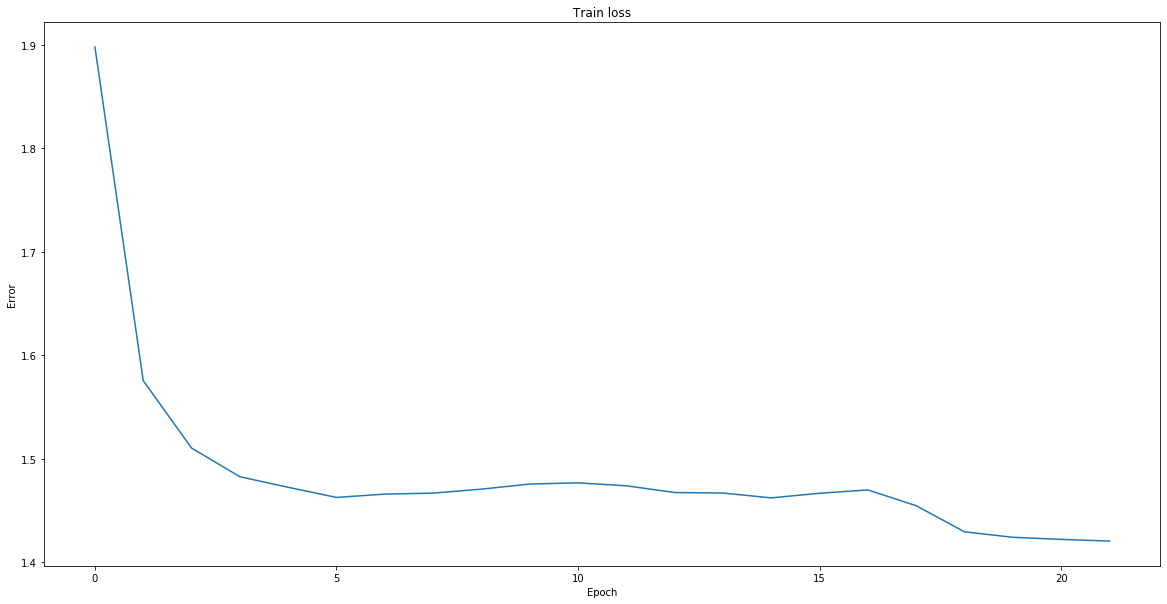

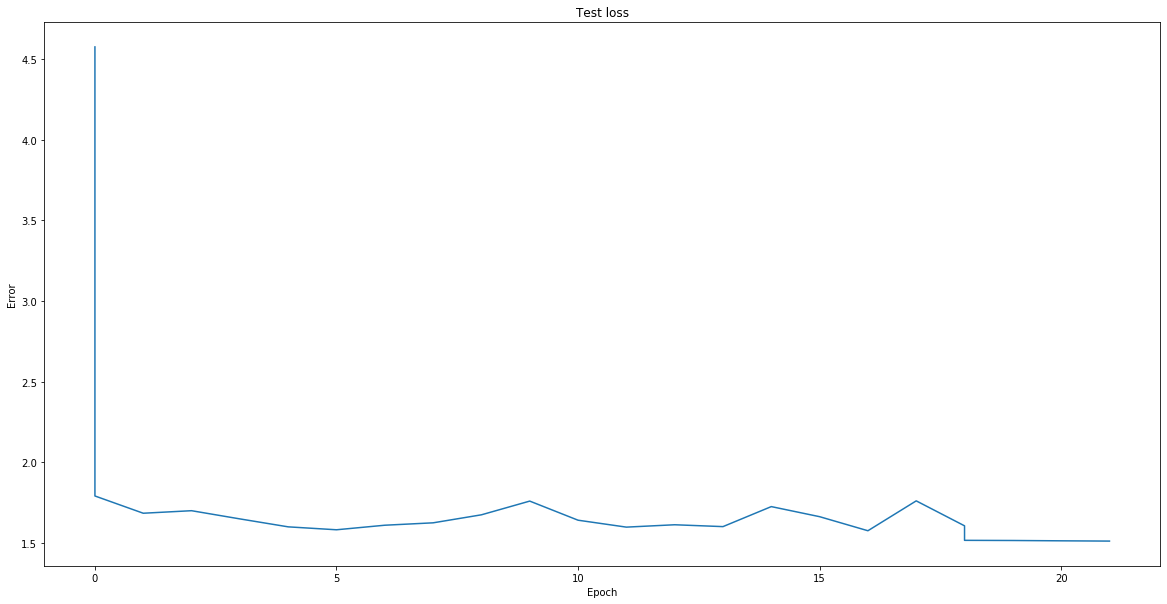

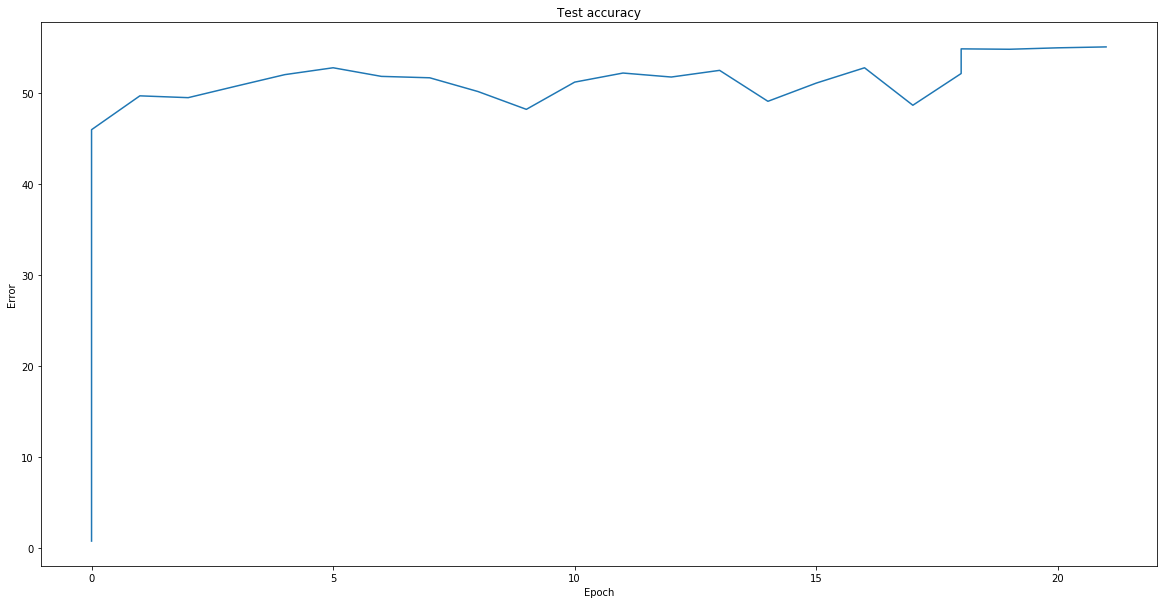

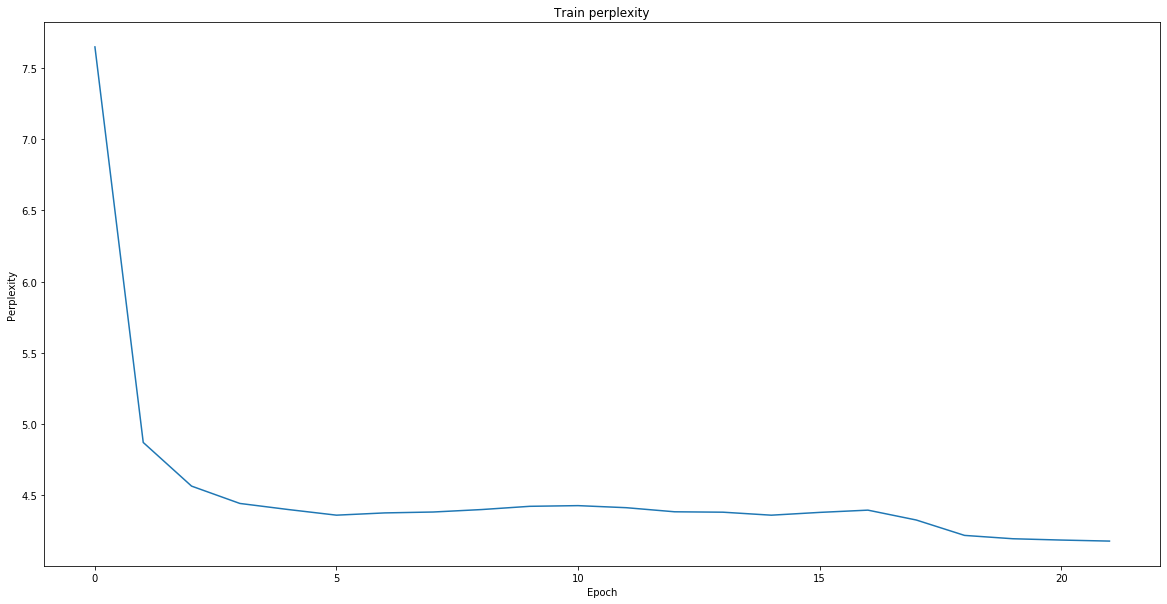

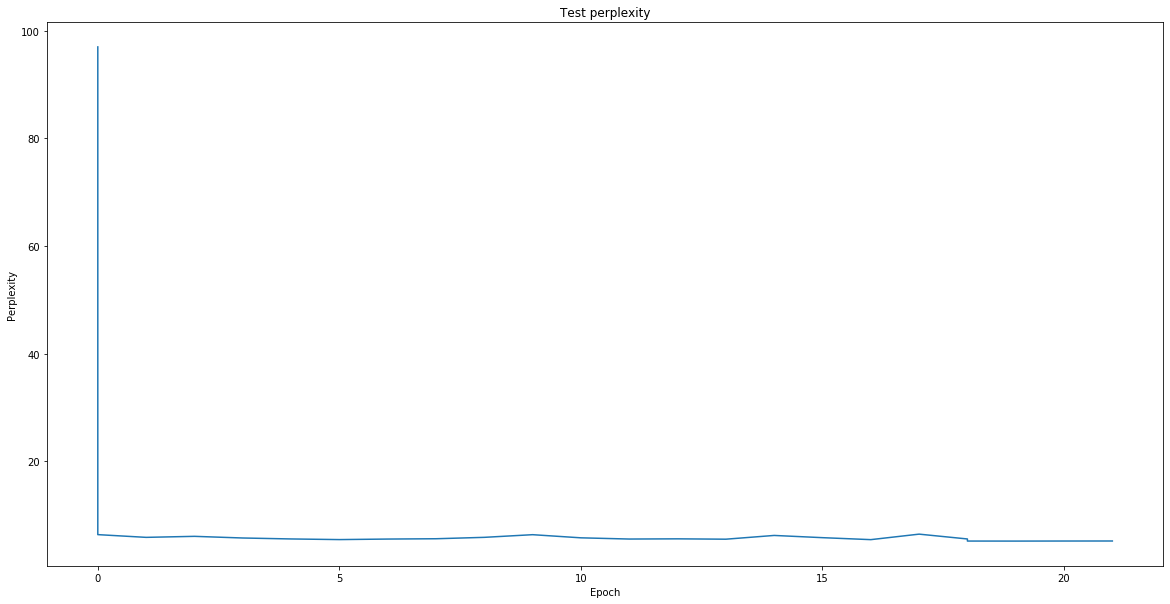

In [0]:
def main(DATA_PATH):
    SEQUENCE_LENGTH = 200
    BATCH_SIZE = 256
    FEATURE_SIZE = 700
    TEST_BATCH_SIZE = 256
    EPOCHS = 50
    LEARNING_RATE = 0.0002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/lstm_log.pkl'


    data_train = GotDataset(DATA_PATH + 'got_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = GotDataset(DATA_PATH + 'got_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = GotLSTMNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_lstm')
    train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))  
    test_perplexities.append((start_epoch, test_perplexity))
    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_perplexity = train_lstm(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test_lstm(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_lstm/%03d.pt' % epoch)
            # seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            # generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            # print('generated max\t\t', generated_sentence)
            # for ii in range(10):
            #     generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
            #     print('generated sample\t', generated_sentence)
            # generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            # print('generated beam\t\t', generated_sentence)
            # print('')
    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_lstm/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model_lstm, vocab_lstm, device_lstm = main(BASE_PATH)

#3.3: Experiments

In [0]:
TEMPERATURE = 0.3
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # raise NotImplementedError
        probability, prev_arr = output.max(-1)
        outputs.append(prev_arr)
        output, hidden = model.inference(prev_arr.long(), hidden, TEMPERATURE)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # raise NotImplementedError
        sample = torch.multinomial(output, 1)[0]
        outputs.append(sample)
        output, hidden = model.inference(sample.long(), hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    # beam = [([], output, hidden, 0)]
    # TODO
    # raise NotImplementedError
    # A. Initialize the beam list with the single existing empty beam
    beams = [([], output, hidden, 0)]
    # B. Repeat for the sequence length:
    for ii in range(sequence_length):
      new_beams = []
      # 1. For each beam in the beam list:
      for beam in beams:
        # a. Sample from the distribution with replacement
        samples = torch.multinomial(beam[1], beam_width, replacement=True)[0]
        # b. Compute its score
        log_prob = torch.log(beam[1][0, samples])
        # c. Pick the top N samples from a beam
        values, indices = torch.topk(log_prob, beam_width)
        # d. For each top N beams
        for ind in indices:
          # i. Compute the next distribution over the output space for that state
          next_out, next_hidden = model.inference(samples[ind].long(), beam[2], TEMPERATURE)
          # ii. Add sample to new beam list
          new_beams.append((beam[0]+[samples[ind]], next_out, next_hidden, log_prob[ind]+beam[-1]))
      # 2. Pick the top N beams
      scores = torch.tensor([ beam[-1] for beam in new_beams])
      values, indices = torch.topk(scores, beam_width)
      beams = [ new_beams[ind] for ind in indices ]
    # C. Return the top beam's chosen values.
    # Shuffle list so that in case of tie, we pick at random
    np.random.shuffle(beams)
    scores =  torch.tensor([ beam[-1] for beam in beams ])
    val, ind = torch.topk(scores, 1)
    outputs = beams[ind][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)
        
        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

In [0]:
def eval_final_model(model, vocab, device):
    seed_words = 'The dragon ate'
    sequence_length = 100

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model_lstm, vocab_lstm, device_lstm)

generated with max	 The dragon atead the stark of the stark of the stark of the  stone of the stark of the stark of the stark of the s
generated with sample	 The dragon atead the first of the steel and closed the stard on the stalls.  The gods was the direwolf stone and s
generated with sample	 The dragon atever the black of the  starts of the black of the great silent ships of the stars. The fire was the l
generated with sample	 The dragon ated the stark of the chance of the steel of the starl of the  dragons and shouted and brought the blac
generated with sample	 The dragon aternated the store the walls of the black  and and her for and stones and still believed the cloak and
generated with sample	 The dragon ateld the real  father to the stone with the dark and suddenly the stark of the stard and shoulders of 
generated with sample	 The dragon atead her back. "He was a lady to the castle of the  man of the door when the steel had been the first 
generated with sample	 The dragon ate

In [0]:
print(final_model_lstm)

GotLSTMNet(
  (encoder): Embedding(96, 700)
  (lstm): LSTM(700, 700, batch_first=True)
  (decoder): Linear(in_features=700, out_features=96, bias=True)
)


# SECTION 4: New Architecture

Things that doesn't work:
*   Increasing the number of features for GRU or LSTM doesnt work
*   LSTM training is slower than GRU.
*   Transformer training is very slow as 5 min of training leads to less that 0.02% in accuracy gained, at 27% accuracy, the gain is substantially smaller at 0.0001% gain.
*   Increasing batch size or sequence length doesn't work.
*   Increasing learning rate doesn't work. It leads to divergence.

# Define network

In [0]:
TEMPERATURE = 0.3

class GotNewNet(nn.Module):
    def __init__(self, vocab_size, feature_size):
        super(GotNewNet, self).__init__()
        self.vocab_size = vocab_size
        self.feature_size = feature_size
        self.encoder = nn.Embedding(self.vocab_size, self.feature_size)
        self.gru = nn.GRU(self.feature_size, self.feature_size, batch_first=True, num_layers=4)
        self.decoder_1 = nn.Linear(self.feature_size, self.feature_size//2)
        self.decoder_2 = nn.Linear(self.feature_size//2, self.vocab_size)
        self.batchnorm_0 = nn.BatchNorm1d(self.feature_size)
        self.batchnorm_1 = nn.BatchNorm1d(self.feature_size)
        self.batchnorm_2 = nn.BatchNorm1d(self.feature_size//2)
        self.relu = nn.ReLU()
        # This shares the encoder and decoder weights as described in lecture.
        # self.decoder.weight = self.encoder.weight
        self.decoder_1.bias.data.zero_()
        self.decoder_2.bias.data.zero_()
        
        self.best_accuracy = -1
    
    def forward(self, x, hidden_state=None):
        batch_size = x.shape[0]
        sequence_length = x.shape[1]
        
        # TODO finish defining the forward pass.
        # You should return the output from the decoder as well as the hidden state given by the gru.
        # raise NotImplementedError
        x = self.encoder(x)
        x = x.view(batch_size*sequence_length, self.feature_size)
        x = self.batchnorm_0(x)
        x = x.view(batch_size, sequence_length, self.feature_size)
        x, hidden_state = self.gru(x, hidden_state)
        x = x.reshape(batch_size*sequence_length, self.feature_size)
        x = self.batchnorm_1(x)
        x = x.reshape(batch_size, sequence_length, self.feature_size)
        x = self.decoder_1(x)
        x = x.reshape(batch_size*sequence_length, self.feature_size//2)
        x = self.batchnorm_2(x)
        x = x.reshape(batch_size, sequence_length, self.feature_size//2)
        x = self.relu(x)
        x = self.decoder_2(x)
        return x, hidden_state

    # This defines the function that gives a probability distribution and implements the temperature computation.
    def inference(self, x, hidden_state=None, temperature=1):
        x = x.view(-1, 1)
        x, hidden_state = self.forward(x, hidden_state)
        x = x.view(1, -1)
        x = x / max(temperature, 1e-20)
        x = F.softmax(x, dim=1)
        return x, hidden_state

    # Predefined loss function
    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction.view(-1, self.vocab_size), label.view(-1), reduction=reduction)
        return loss_val

    # Saves the current model
    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)

    # Saves the best model so far
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if accuracy > self.best_accuracy:
            self.save_model(file_path, num_to_keep)
            self.best_accuracy = accuracy

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)

# 4.2a Training

Using device cuda
num workers: 2
Restoring:
encoder.weight -> 	torch.Size([96, 512]) = 0MB
gru.weight_ih_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l0 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l0 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l0 -> 	torch.Size([1536]) = 0MB
gru.weight_ih_l1 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l1 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l1 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l1 -> 	torch.Size([1536]) = 0MB
gru.weight_ih_l2 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l2 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l2 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l2 -> 	torch.Size([1536]) = 0MB
gru.weight_ih_l3 -> 	torch.Size([1536, 512]) = 3MB
gru.weight_hh_l3 -> 	torch.Size([1536, 512]) = 3MB
gru.bias_ih_l3 -> 	torch.Size([1536]) = 0MB
gru.bias_hh_l3 -> 	torch.Size([1536]) = 0MB
decoder_1.weight -> 	torch.Size([256, 512]) = 0MB
decoder_1.bias -> 	torch.Size([256]) = 0MB
decoder_2.weight -> 	torch.Size([96, 256]) = 0MB
decoder

  0%|          | 0/148 [00:00<?, ?it/s]


Test set: Average loss: 1.3858, Accuracy: 1114952/1894400 (59%), Average perplexity: 6.1000



  1%|          | 1/148 [00:00<00:59,  2.46it/s]

Train Epoch: 55 [0/37888 (0%)]	Loss: 1.219518


  7%|▋         | 11/148 [00:03<00:44,  3.05it/s]

Train Epoch: 55 [2560/37888 (7%)]	Loss: 1.223479


 14%|█▍        | 21/148 [00:06<00:41,  3.06it/s]

Train Epoch: 55 [5120/37888 (14%)]	Loss: 1.211492


 21%|██        | 31/148 [00:10<00:38,  3.07it/s]

Train Epoch: 55 [7680/37888 (20%)]	Loss: 1.230826


 28%|██▊       | 41/148 [00:13<00:35,  3.04it/s]

Train Epoch: 55 [10240/37888 (27%)]	Loss: 1.219170


 34%|███▍      | 51/148 [00:16<00:31,  3.05it/s]

Train Epoch: 55 [12800/37888 (34%)]	Loss: 1.230753


 41%|████      | 61/148 [00:20<00:28,  3.06it/s]

Train Epoch: 55 [15360/37888 (41%)]	Loss: 1.246887


 48%|████▊     | 71/148 [00:23<00:25,  3.02it/s]

Train Epoch: 55 [17920/37888 (47%)]	Loss: 1.229917


 55%|█████▍    | 81/148 [00:26<00:22,  3.04it/s]

Train Epoch: 55 [20480/37888 (54%)]	Loss: 1.229284


 61%|██████▏   | 91/148 [00:29<00:18,  3.04it/s]

Train Epoch: 55 [23040/37888 (61%)]	Loss: 1.222137


 68%|██████▊   | 101/148 [00:33<00:15,  3.03it/s]

Train Epoch: 55 [25600/37888 (68%)]	Loss: 1.232167


 75%|███████▌  | 111/148 [00:36<00:12,  3.05it/s]

Train Epoch: 55 [28160/37888 (74%)]	Loss: 1.233093


 82%|████████▏ | 121/148 [00:39<00:08,  3.06it/s]

Train Epoch: 55 [30720/37888 (81%)]	Loss: 1.232066


 89%|████████▊ | 131/148 [00:43<00:05,  3.01it/s]

Train Epoch: 55 [33280/37888 (88%)]	Loss: 1.216894


 95%|█████████▌| 141/148 [00:46<00:02,  3.02it/s]

Train Epoch: 55 [35840/37888 (95%)]	Loss: 1.231630


100%|██████████| 148/148 [00:48<00:00,  3.06it/s]


Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	t"e  bieep ess soght ah n aede ht  lf toal   rnore ting ato was sonhting tn  t sern on tonnak aareyteed t out the soocte on  oralte   he serne entn  were sainh tith tir  an weemed   he  oodk et r   wn




  0%|          | 0/148 [00:00<?, ?it/s]


Test set: Average loss: 1.3877, Accuracy: 1114499/1894400 (59%), Average perplexity: 6.1476

Saved /gdrive/My Drive/colab_files/homework3/checkpoints_got_new/055.pt



  1%|          | 1/148 [00:00<01:02,  2.34it/s]

Train Epoch: 56 [0/37888 (0%)]	Loss: 1.219153


  7%|▋         | 11/148 [00:03<00:45,  3.00it/s]

Train Epoch: 56 [2560/37888 (7%)]	Loss: 1.223305


 14%|█▍        | 21/148 [00:07<00:41,  3.03it/s]

Train Epoch: 56 [5120/37888 (14%)]	Loss: 1.211364


 21%|██        | 31/148 [00:10<00:38,  3.03it/s]

Train Epoch: 56 [7680/37888 (20%)]	Loss: 1.230690


 28%|██▊       | 41/148 [00:13<00:35,  3.02it/s]

Train Epoch: 56 [10240/37888 (27%)]	Loss: 1.219048


 34%|███▍      | 51/148 [00:16<00:31,  3.04it/s]

Train Epoch: 56 [12800/37888 (34%)]	Loss: 1.230644


 41%|████      | 61/148 [00:20<00:28,  3.03it/s]

Train Epoch: 56 [15360/37888 (41%)]	Loss: 1.246799


 48%|████▊     | 71/148 [00:23<00:25,  3.06it/s]

Train Epoch: 56 [17920/37888 (47%)]	Loss: 1.229838


 55%|█████▍    | 81/148 [00:26<00:22,  3.04it/s]

Train Epoch: 56 [20480/37888 (54%)]	Loss: 1.229226


 61%|██████▏   | 91/148 [00:30<00:18,  3.01it/s]

Train Epoch: 56 [23040/37888 (61%)]	Loss: 1.222067


 68%|██████▊   | 101/148 [00:33<00:15,  3.04it/s]

Train Epoch: 56 [25600/37888 (68%)]	Loss: 1.232107


 75%|███████▌  | 111/148 [00:36<00:12,  3.02it/s]

Train Epoch: 56 [28160/37888 (74%)]	Loss: 1.233047


 82%|████████▏ | 121/148 [00:39<00:08,  3.04it/s]

Train Epoch: 56 [30720/37888 (81%)]	Loss: 1.232030


 89%|████████▊ | 131/148 [00:43<00:05,  3.04it/s]

Train Epoch: 56 [33280/37888 (88%)]	Loss: 1.216858


 95%|█████████▌| 141/148 [00:46<00:02,  3.04it/s]

Train Epoch: 56 [35840/37888 (95%)]	Loss: 1.231593


100%|██████████| 148/148 [00:48<00:00,  3.05it/s]


Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	t"e  bieep ess soght ah n aede ht  lf tral   rnore ting ato was sonhting tn  t sern on tonnak aareyteed t out the soocte on  oralte   he serne entn  were sainh tith tir  an weemed   he  oodk et r   wn




  0%|          | 0/148 [00:00<?, ?it/s]


Test set: Average loss: 1.3878, Accuracy: 1114485/1894400 (59%), Average perplexity: 6.1558



  1%|          | 1/148 [00:00<01:01,  2.40it/s]

Train Epoch: 57 [0/37888 (0%)]	Loss: 1.219286


  7%|▋         | 11/148 [00:03<00:45,  3.02it/s]

Train Epoch: 57 [2560/37888 (7%)]	Loss: 1.223225


 14%|█▍        | 21/148 [00:07<00:42,  3.02it/s]

Train Epoch: 57 [5120/37888 (14%)]	Loss: 1.211303


 21%|██        | 31/148 [00:10<00:38,  3.05it/s]

Train Epoch: 57 [7680/37888 (20%)]	Loss: 1.230592


 28%|██▊       | 41/148 [00:13<00:35,  3.05it/s]

Train Epoch: 57 [10240/37888 (27%)]	Loss: 1.218961


 34%|███▍      | 51/148 [00:16<00:31,  3.04it/s]

Train Epoch: 57 [12800/37888 (34%)]	Loss: 1.230565


 41%|████      | 61/148 [00:20<00:28,  3.04it/s]

Train Epoch: 57 [15360/37888 (41%)]	Loss: 1.246729


 48%|████▊     | 71/148 [00:23<00:25,  3.06it/s]

Train Epoch: 57 [17920/37888 (47%)]	Loss: 1.229764


 55%|█████▍    | 81/148 [00:26<00:21,  3.05it/s]

Train Epoch: 57 [20480/37888 (54%)]	Loss: 1.229171


 61%|██████▏   | 91/148 [00:30<00:18,  3.03it/s]

Train Epoch: 57 [23040/37888 (61%)]	Loss: 1.222026


 68%|██████▊   | 101/148 [00:33<00:15,  3.03it/s]

Train Epoch: 57 [25600/37888 (68%)]	Loss: 1.232074


 75%|███████▌  | 111/148 [00:36<00:12,  3.07it/s]

Train Epoch: 57 [28160/37888 (74%)]	Loss: 1.233021


 82%|████████▏ | 121/148 [00:39<00:08,  3.05it/s]

Train Epoch: 57 [30720/37888 (81%)]	Loss: 1.232010


 89%|████████▊ | 131/148 [00:43<00:05,  3.06it/s]

Train Epoch: 57 [33280/37888 (88%)]	Loss: 1.216835


 95%|█████████▌| 141/148 [00:46<00:02,  3.05it/s]

Train Epoch: 57 [35840/37888 (95%)]	Loss: 1.231579


100%|██████████| 148/148 [00:48<00:00,  3.05it/s]


Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	t"e  bieep ess soght ah n aede ht  lf tral   rnore ting ato was sonhting tn  t sern on tonnak aareyteed t out the soocte on  oralte   he serne entn  were sainh tith tir  an weemed   he  oodk et r   wn




  0%|          | 0/148 [00:00<?, ?it/s]


Test set: Average loss: 1.3879, Accuracy: 1114494/1894400 (59%), Average perplexity: 6.1593



  1%|          | 1/148 [00:00<01:00,  2.41it/s]

Train Epoch: 58 [0/37888 (0%)]	Loss: 1.219340


  7%|▋         | 11/148 [00:03<00:45,  3.03it/s]

Train Epoch: 58 [2560/37888 (7%)]	Loss: 1.223148


 14%|█▍        | 21/148 [00:07<00:42,  3.02it/s]

Train Epoch: 58 [5120/37888 (14%)]	Loss: 1.211232


 21%|██        | 31/148 [00:10<00:38,  3.05it/s]

Train Epoch: 58 [7680/37888 (20%)]	Loss: 1.230512


 28%|██▊       | 41/148 [00:13<00:35,  3.05it/s]

Train Epoch: 58 [10240/37888 (27%)]	Loss: 1.218883


 34%|███▍      | 51/148 [00:16<00:31,  3.04it/s]

Train Epoch: 58 [12800/37888 (34%)]	Loss: 1.230489


 41%|████      | 61/148 [00:20<00:28,  3.05it/s]

Train Epoch: 58 [15360/37888 (41%)]	Loss: 1.246662


 48%|████▊     | 71/148 [00:23<00:25,  3.03it/s]

Train Epoch: 58 [17920/37888 (47%)]	Loss: 1.229698


 55%|█████▍    | 81/148 [00:26<00:21,  3.05it/s]

Train Epoch: 58 [20480/37888 (54%)]	Loss: 1.229121


 61%|██████▏   | 91/148 [00:30<00:18,  3.06it/s]

Train Epoch: 58 [23040/37888 (61%)]	Loss: 1.221983


 68%|██████▊   | 101/148 [00:33<00:15,  3.02it/s]

Train Epoch: 58 [25600/37888 (68%)]	Loss: 1.232034


 75%|███████▌  | 111/148 [00:36<00:12,  3.04it/s]

Train Epoch: 58 [28160/37888 (74%)]	Loss: 1.232992


 82%|████████▏ | 121/148 [00:39<00:08,  3.06it/s]

Train Epoch: 58 [30720/37888 (81%)]	Loss: 1.231988


 89%|████████▊ | 131/148 [00:43<00:05,  3.04it/s]

Train Epoch: 58 [33280/37888 (88%)]	Loss: 1.216810


 95%|█████████▌| 141/148 [00:46<00:02,  3.05it/s]

Train Epoch: 58 [35840/37888 (95%)]	Loss: 1.231561


100%|██████████| 148/148 [00:48<00:00,  3.05it/s]


Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	t"e  bieep ess soght ah n aede ht  lf tral   rnore ting ato was sonhting tn  t sern on tonnak aareyteed t out the soocte on  oralte   he serne entn  were sainh tith tir  an weemed   he  oodk et r   wn




  0%|          | 0/148 [00:00<?, ?it/s]


Test set: Average loss: 1.3879, Accuracy: 1114552/1894400 (59%), Average perplexity: 6.1619

Saved /gdrive/My Drive/colab_files/homework3/checkpoints_got_new/058.pt



  1%|          | 1/148 [00:00<01:00,  2.42it/s]

Train Epoch: 59 [0/37888 (0%)]	Loss: 1.219360


  7%|▋         | 11/148 [00:03<00:45,  3.01it/s]

Train Epoch: 59 [2560/37888 (7%)]	Loss: 1.223083


 14%|█▍        | 21/148 [00:07<00:42,  3.02it/s]

Train Epoch: 59 [5120/37888 (14%)]	Loss: 1.211166


 21%|██        | 31/148 [00:10<00:38,  3.04it/s]

Train Epoch: 59 [7680/37888 (20%)]	Loss: 1.230435


 28%|██▊       | 41/148 [00:13<00:34,  3.06it/s]

Train Epoch: 59 [10240/37888 (27%)]	Loss: 1.218813


 34%|███▍      | 51/148 [00:16<00:31,  3.03it/s]

Train Epoch: 59 [12800/37888 (34%)]	Loss: 1.230419


 41%|████      | 61/148 [00:20<00:28,  3.03it/s]

Train Epoch: 59 [15360/37888 (41%)]	Loss: 1.246598


 48%|████▊     | 71/148 [00:23<00:25,  3.04it/s]

Train Epoch: 59 [17920/37888 (47%)]	Loss: 1.229643


 55%|█████▍    | 81/148 [00:26<00:22,  3.04it/s]

Train Epoch: 59 [20480/37888 (54%)]	Loss: 1.229074


 61%|██████▏   | 91/148 [00:30<00:18,  3.06it/s]

Train Epoch: 59 [23040/37888 (61%)]	Loss: 1.221943


 68%|██████▊   | 101/148 [00:33<00:15,  3.05it/s]

Train Epoch: 59 [25600/37888 (68%)]	Loss: 1.231995


 75%|███████▌  | 111/148 [00:36<00:12,  3.06it/s]

Train Epoch: 59 [28160/37888 (74%)]	Loss: 1.232967


 82%|████████▏ | 121/148 [00:39<00:08,  3.02it/s]

Train Epoch: 59 [30720/37888 (81%)]	Loss: 1.231962


 89%|████████▊ | 131/148 [00:43<00:05,  3.04it/s]

Train Epoch: 59 [33280/37888 (88%)]	Loss: 1.216783


 95%|█████████▌| 141/148 [00:46<00:02,  3.05it/s]

Train Epoch: 59 [35840/37888 (95%)]	Loss: 1.231538


100%|██████████| 148/148 [00:48<00:00,  3.05it/s]


Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	t"e  bieep ess soght ah n aede ht  lf tral   rnore ting ato was sonhting tn  t sern on tonnak aareyteed t out the soocte on  oralte   he serne entn  were sainh tith tir  an weemed   he  oodk et r   wn




  0%|          | 0/148 [00:00<?, ?it/s]


Test set: Average loss: 1.3880, Accuracy: 1114588/1894400 (59%), Average perplexity: 6.1640

Saved /gdrive/My Drive/colab_files/homework3/checkpoints_got_new/059.pt



  1%|          | 1/148 [00:00<01:00,  2.44it/s]

Train Epoch: 60 [0/37888 (0%)]	Loss: 1.219364


  7%|▋         | 11/148 [00:03<00:45,  3.01it/s]

Train Epoch: 60 [2560/37888 (7%)]	Loss: 1.223018


 14%|█▍        | 21/148 [00:07<00:42,  3.02it/s]

Train Epoch: 60 [5120/37888 (14%)]	Loss: 1.211102


 21%|██        | 31/148 [00:10<00:38,  3.05it/s]

Train Epoch: 60 [7680/37888 (20%)]	Loss: 1.230371


 28%|██▊       | 41/148 [00:13<00:35,  3.02it/s]

Train Epoch: 60 [10240/37888 (27%)]	Loss: 1.218748


 34%|███▍      | 51/148 [00:16<00:32,  3.03it/s]

Train Epoch: 60 [12800/37888 (34%)]	Loss: 1.230352


 41%|████      | 61/148 [00:20<00:28,  3.06it/s]

Train Epoch: 60 [15360/37888 (41%)]	Loss: 1.246539


 48%|████▊     | 71/148 [00:23<00:25,  3.04it/s]

Train Epoch: 60 [17920/37888 (47%)]	Loss: 1.229587


 55%|█████▍    | 81/148 [00:26<00:22,  3.04it/s]

Train Epoch: 60 [20480/37888 (54%)]	Loss: 1.229026


 61%|██████▏   | 91/148 [00:30<00:18,  3.03it/s]

Train Epoch: 60 [23040/37888 (61%)]	Loss: 1.221904


 68%|██████▊   | 101/148 [00:33<00:15,  3.05it/s]

Train Epoch: 60 [25600/37888 (68%)]	Loss: 1.231961


 75%|███████▌  | 111/148 [00:36<00:12,  3.03it/s]

Train Epoch: 60 [28160/37888 (74%)]	Loss: 1.232937


 82%|████████▏ | 121/148 [00:39<00:08,  3.02it/s]

Train Epoch: 60 [30720/37888 (81%)]	Loss: 1.231937


 89%|████████▊ | 131/148 [00:43<00:05,  3.04it/s]

Train Epoch: 60 [33280/37888 (88%)]	Loss: 1.216753


 95%|█████████▌| 141/148 [00:46<00:02,  3.05it/s]

Train Epoch: 60 [35840/37888 (95%)]	Loss: 1.231511


100%|██████████| 148/148 [00:48<00:00,  3.05it/s]


Input	  Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  a
GT	 Her sleepless night soon made itself felt. Before long she was fighting off a yawn as Reznak  prattled about the craftsmens guilds. The stonemasons were wroth with her, it seemed. The bricklayers  as
pred	t"e  bieep ess soght ah n aede ht  lf tral   rnore ting ato was sonhting tn  t sern on tonnak aareyteed t out the soocte on  oralte   he serne entn  were sainh tith tir  an weemed   he  oodk et r   wn



Test set: Average loss: 1.3880, Accuracy: 1114564/1894400 (59%), Average perplexity: 6.1671

Saving final model
Saved /gdrive/My Drive/colab_files/homework3/checkpoints_got_new/060.pt



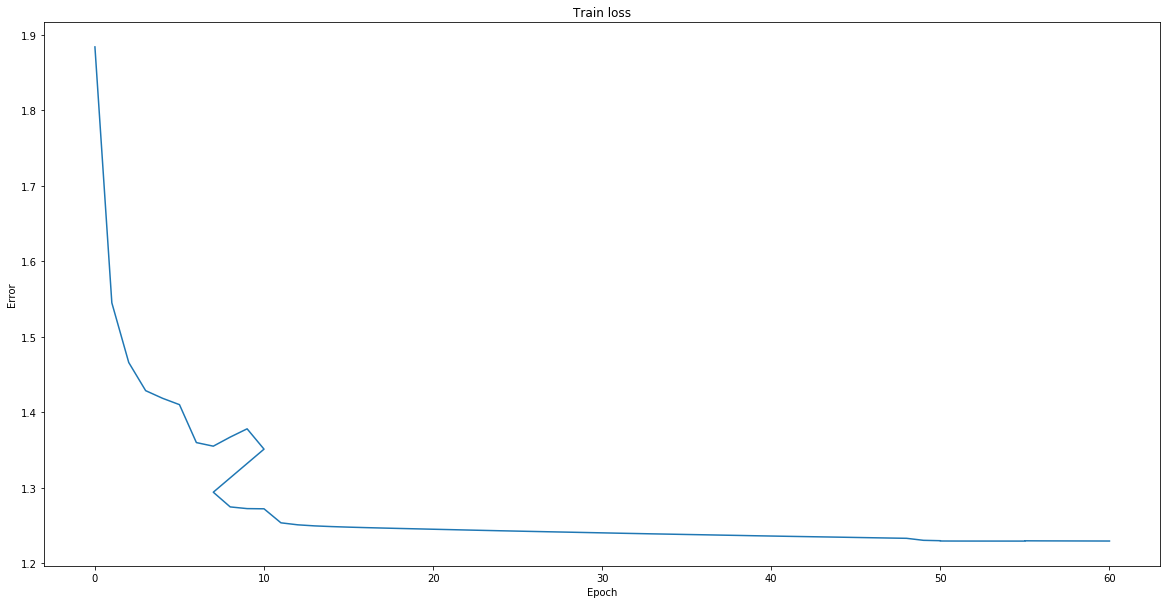

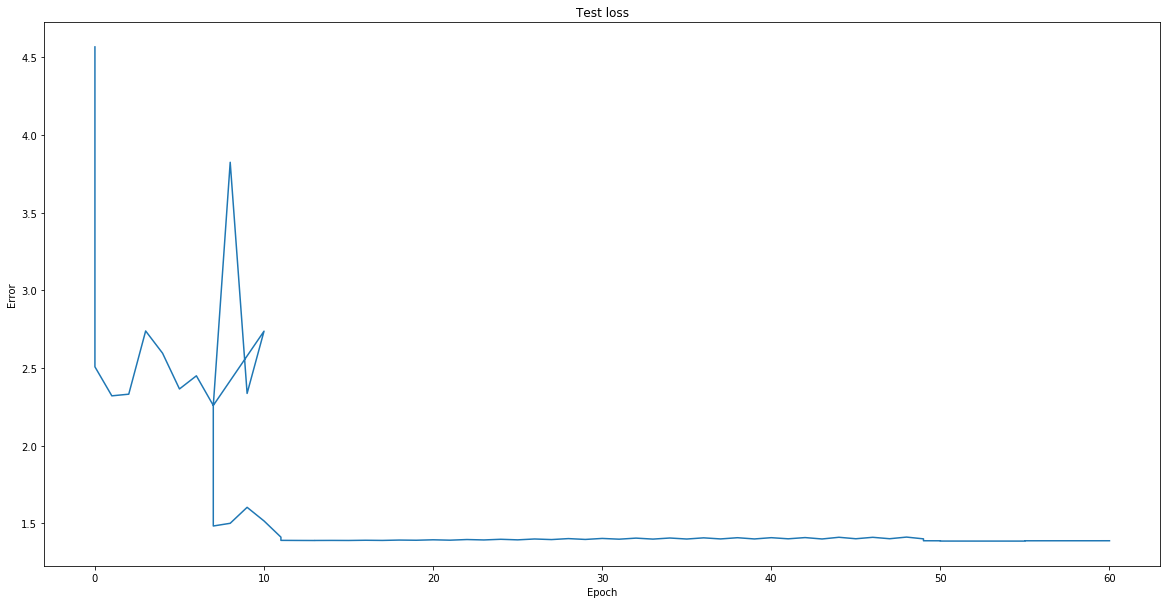

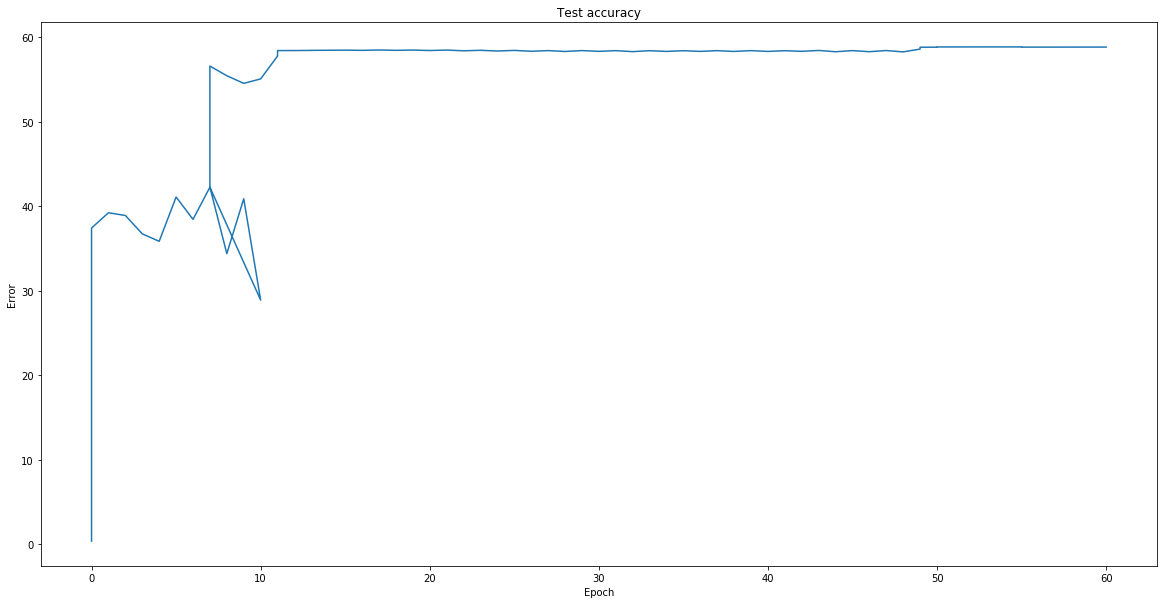

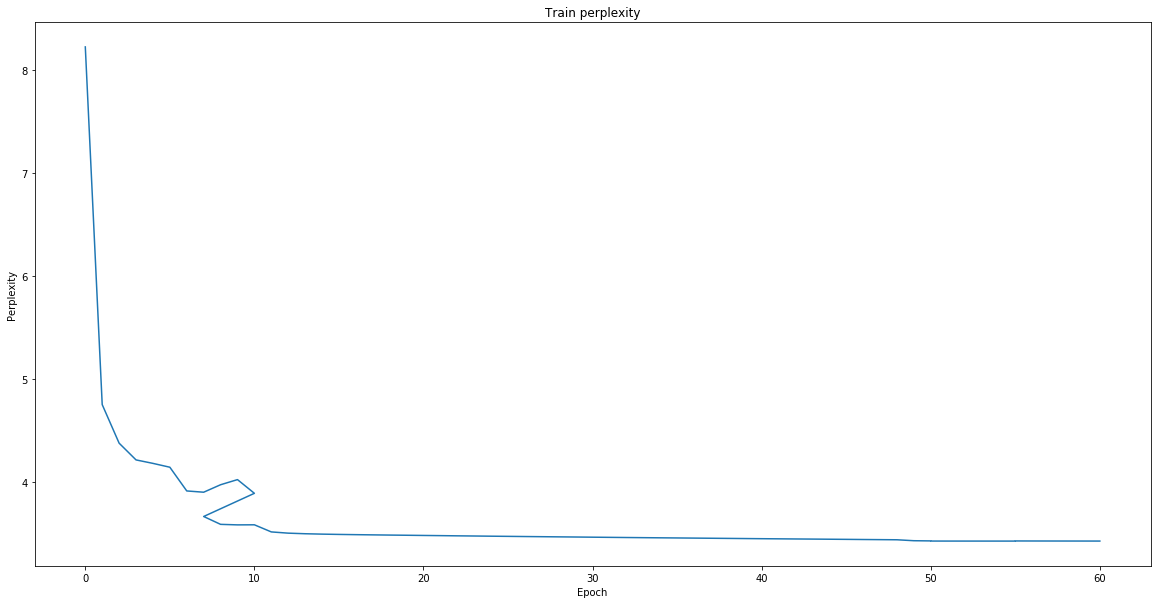

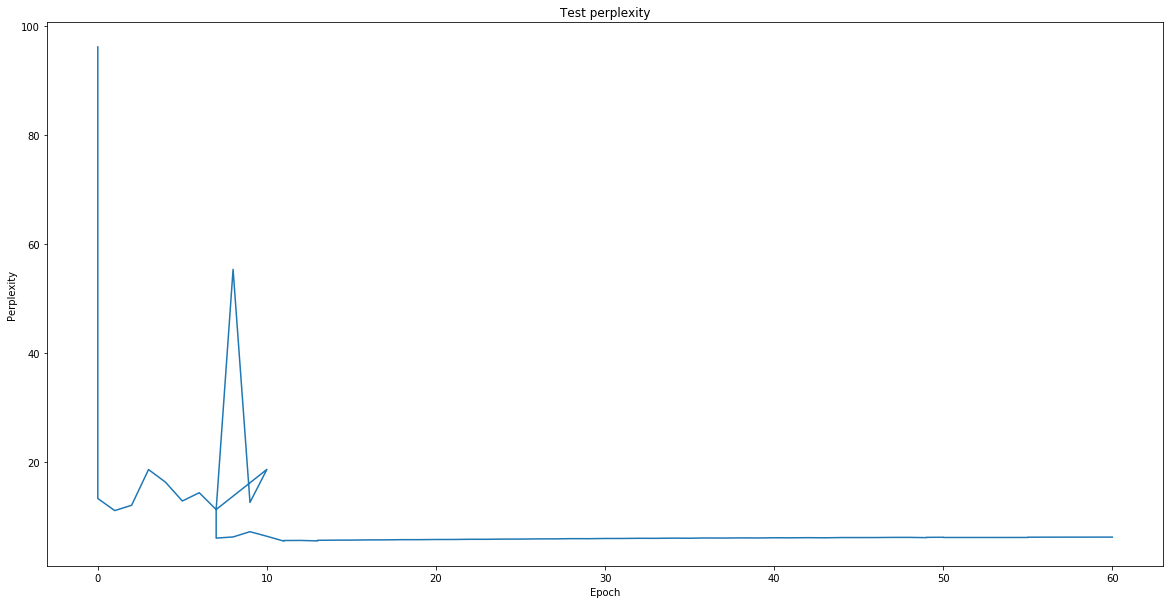

In [17]:
def main(DATA_PATH):
    # SEQUENCE_LENGTH = 100
    SEQUENCE_LENGTH = 200
    BATCH_SIZE = 256
    FEATURE_SIZE = 512
    TEST_BATCH_SIZE = 256
    EPOCHS = 60
    LEARNING_RATE = 0.000002
    WEIGHT_DECAY = 0.0005
    USE_CUDA = True
    PRINT_INTERVAL = 10
    LOG_PATH = DATA_PATH + 'logs/got_new_log.pkl'


    data_train = GotDataset(DATA_PATH + 'got_chars_train.pkl', SEQUENCE_LENGTH, BATCH_SIZE)
    data_test = GotDataset(DATA_PATH + 'got_chars_test.pkl', SEQUENCE_LENGTH, TEST_BATCH_SIZE)
    vocab = data_train.vocab

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                               shuffle=False, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                              shuffle=False, **kwargs)

    model = GotNewNet(data_train.vocab_size(), FEATURE_SIZE).to(device)

    # Adam is an optimizer like SGD but a bit fancier. It tends to work faster and better than SGD.
    # We will talk more about different optimization methods in class.
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    start_epoch = model.load_last_model(DATA_PATH + 'checkpoints_got_new')
    train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], [], []))
    test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)

    test_losses.append((start_epoch, test_loss))
    test_accuracies.append((start_epoch, test_accuracy))  
    test_perplexities.append((start_epoch, test_perplexity))
    try:
        for epoch in range(start_epoch, EPOCHS + 1):
            lr = LEARNING_RATE * np.power(0.25, (int(epoch / 6)))
            train_loss, train_perplexity = train(model, device, optimizer, train_loader, lr, epoch, PRINT_INTERVAL)
            test_loss, test_accuracy, test_perplexity = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            train_perplexities.append((epoch, train_perplexity))
            test_perplexities.append((epoch, test_perplexity))
            test_accuracies.append((epoch, test_accuracy))
            pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities))
            model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints_got_new/%03d.pt' % epoch)
            # seed_words = 'Harry Potter, Voldemort, and Dumbledore walk into a bar. '
            # generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'max')
            # print('generated max\t\t', generated_sentence)
            # for ii in range(10):
            #     generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'sample')
            #     print('generated sample\t', generated_sentence)
            # generated_sentence = generate_language(model, device, seed_words, 200, vocab, 'beam')
            # print('generated beam\t\t', generated_sentence)
            # print('')
    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        model.save_model(DATA_PATH + 'checkpoints_got_new/%03d.pt' % epoch, 0)
        ep, val = zip(*train_losses)
        pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
        ep, val = zip(*test_losses)
        pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
        ep, val = zip(*test_accuracies)
        pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
        ep, val = zip(*train_perplexities)
        pt_util.plot(ep, val, 'Train perplexity', 'Epoch', 'Perplexity')
        ep, val = zip(*test_perplexities)
        pt_util.plot(ep, val, 'Test perplexity', 'Epoch', 'Perplexity')
        return model, vocab, device

final_model_new, vocab_new, device_new = main(BASE_PATH)

# 4.2b Plot

I restarted the training at epoch 7 after overshooting to epoch 11 because the error does not keep going down. So, I restarted at the best model which is at epoch 7 and I need to alter the log file or just stitch the losses and accuracies manually.

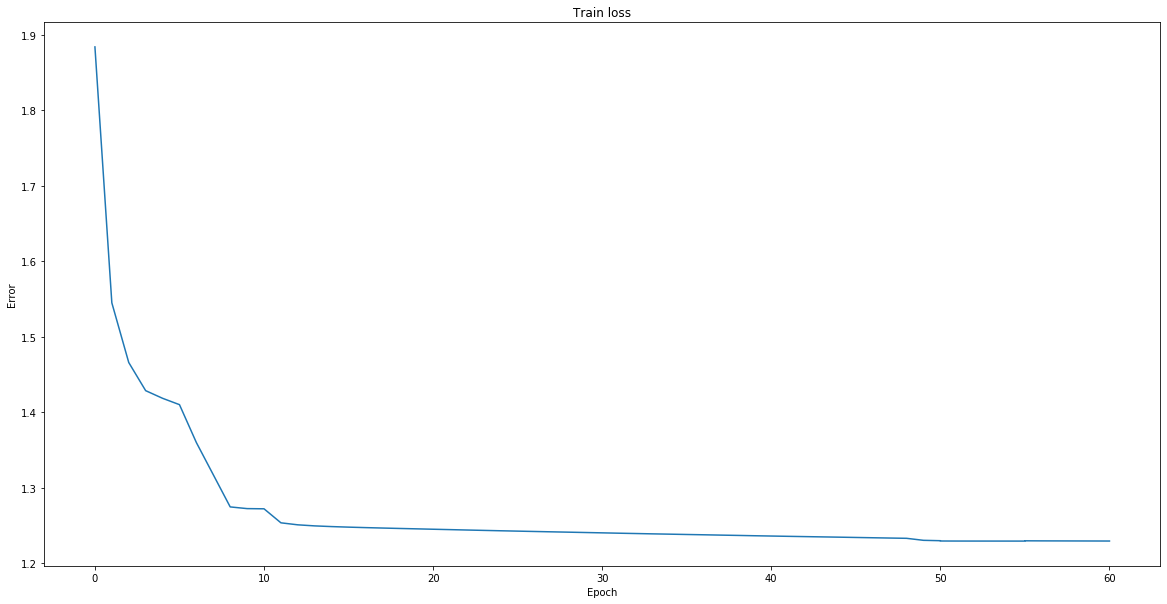

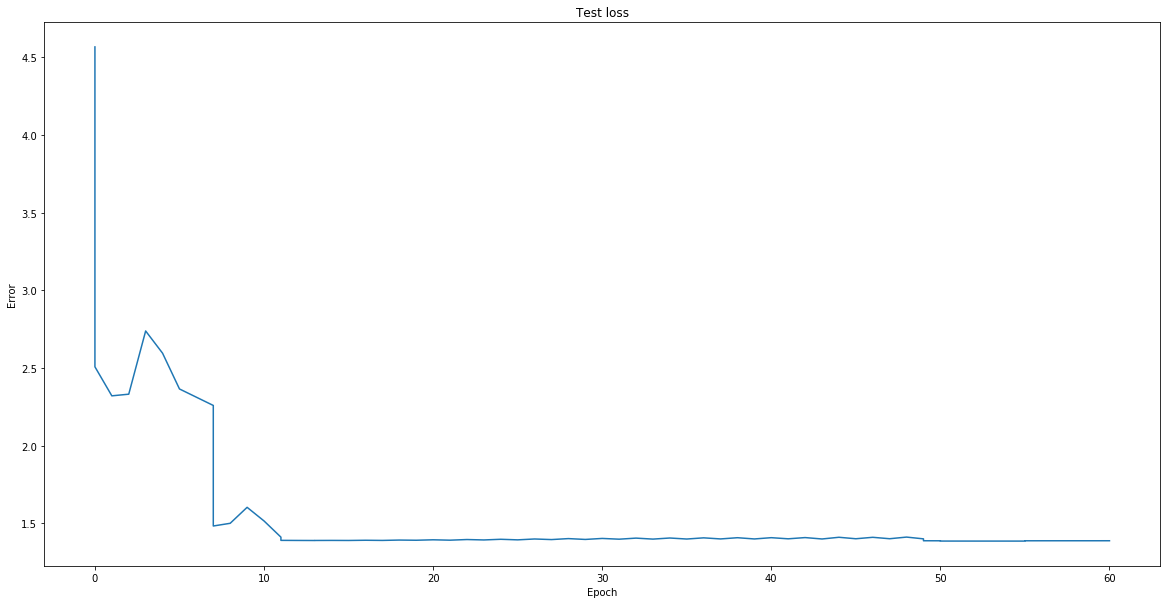

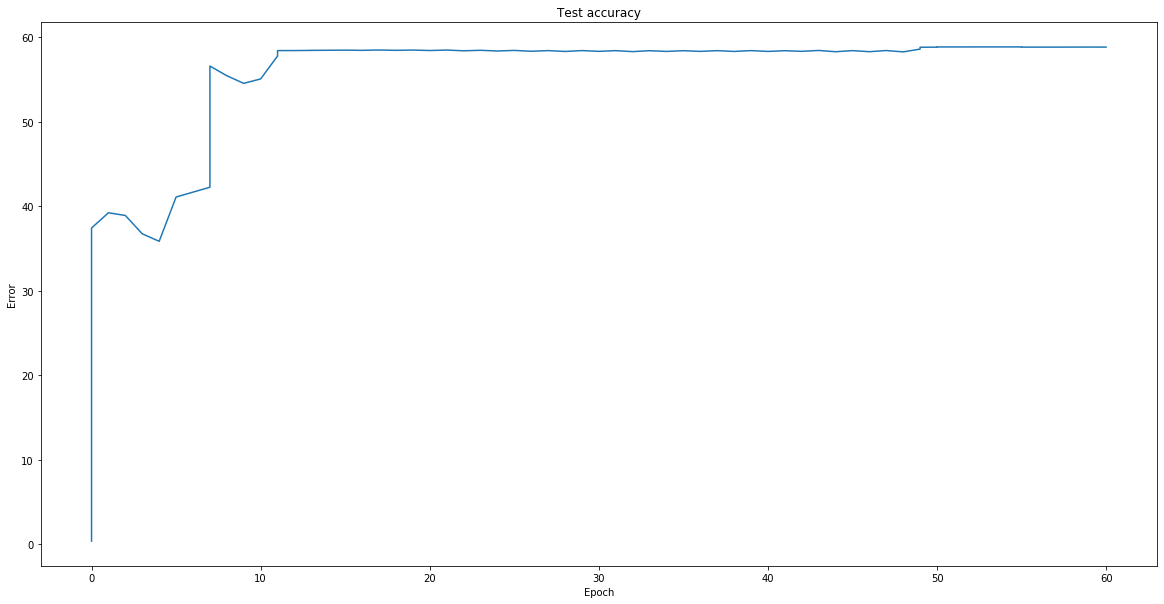

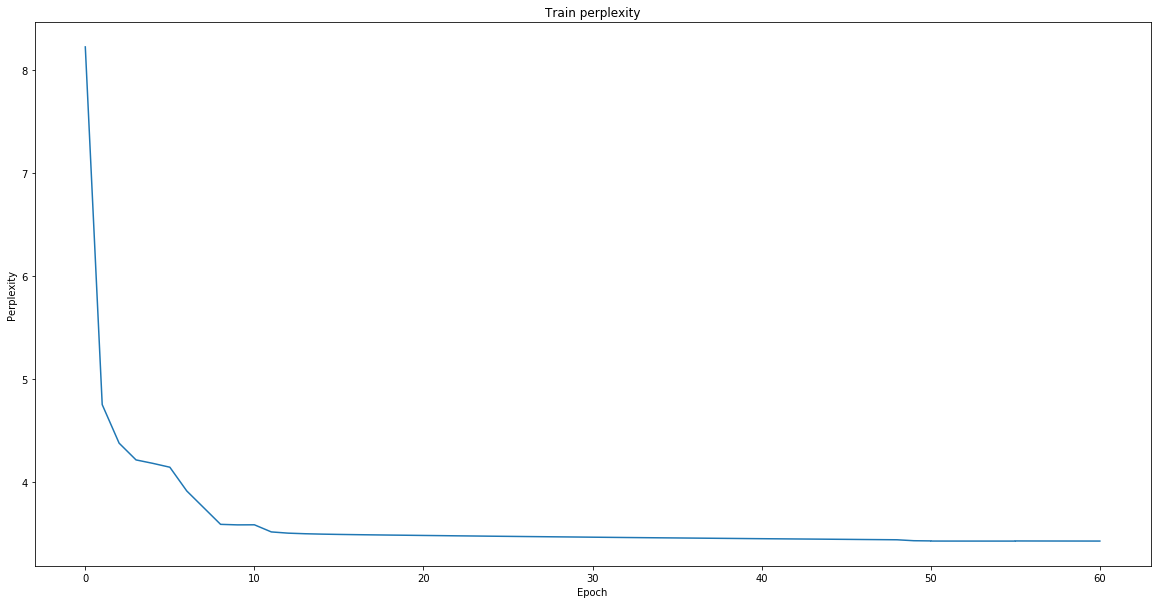

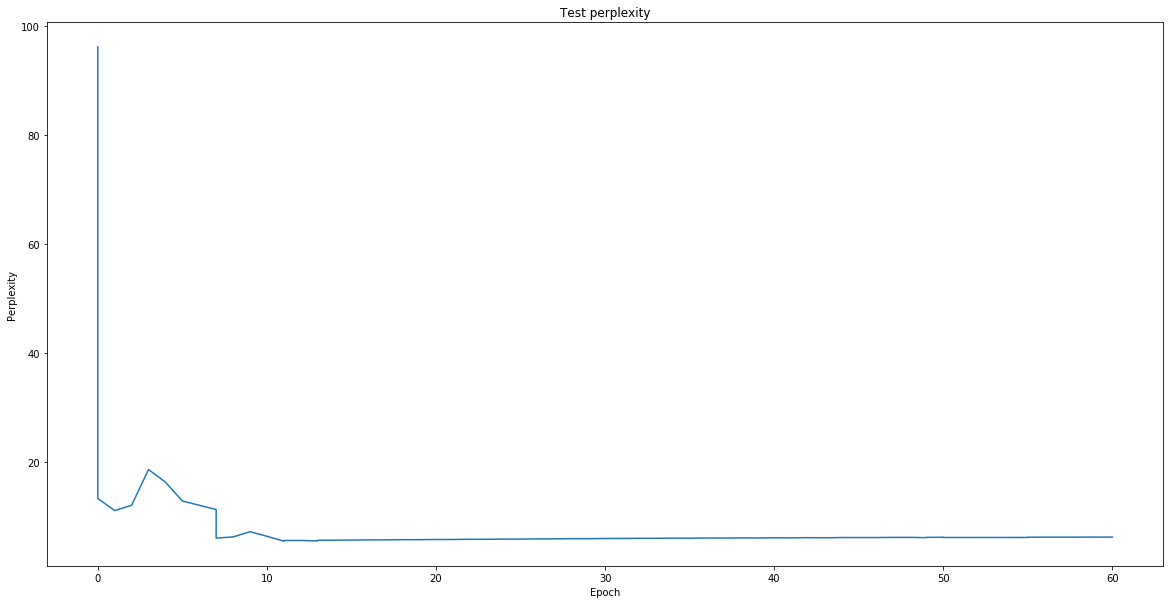

In [30]:
# LOG_PATH = BASE_PATH + 'logs/got_new_log.pkl'

# train_losses, test_losses, test_accuracies, train_perplexities, test_perplexities = pt_util.read_log(LOG_PATH, ([], [], [], [], []))


# ep, val = zip(*train_losses)
# pt_util.plot(ep[:7]+ep[12:], val[:7]+val[12:], 'Train loss', 'Epoch', 'Error')
# ep, val = zip(*test_losses)
# pt_util.plot(ep[:7]+ep[12:], val[:7]+val[12:], 'Test loss', 'Epoch', 'Error')
# ep, val = zip(*test_accuracies)
# pt_util.plot(ep[:7]+ep[12:], val[:7]+val[12:], 'Test accuracy', 'Epoch', 'Error')
# ep, val = zip(*train_perplexities)
# pt_util.plot(ep[:7]+ep[12:], val[:7]+val[12:], 'Train perplexity', 'Epoch', 'Perplexity')
# ep, val = zip(*test_perplexities)
# pt_util.plot(ep[:7]+ep[12:], val[:7]+val[12:], 'Test perplexity', 'Epoch', 'Perplexity')

# 4.3 Experiments

In [0]:
TEMPERATURE = 0.3
BEAM_WIDTH = 10

def max_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # raise NotImplementedError
        probability, prev_arr = output.max(-1)
        outputs.append(prev_arr)
        output, hidden = model.inference(prev_arr.long(), hidden, TEMPERATURE)
    return outputs
    
def sample_sampling_strategy(sequence_length, model, output, hidden, vocab):
    outputs = []
    for ii in range(sequence_length):
        # TODO
        # raise NotImplementedError
        sample = torch.multinomial(output, 1)[0]
        outputs.append(sample)
        output, hidden = model.inference(sample.long(), hidden, TEMPERATURE)
    return outputs

def beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab):
    outputs = []
    # beam = [([], output, hidden, 0)]
    # TODO
    # raise NotImplementedError
    # A. Initialize the beam list with the single existing empty beam
    beams = [([], output, hidden, 0)]
    # B. Repeat for the sequence length:
    for ii in range(sequence_length):
      new_beams = []
      # 1. For each beam in the beam list:
      for beam in beams:
        # a. Sample from the distribution with replacement
        samples = torch.multinomial(beam[1], beam_width, replacement=True)[0]
        # b. Compute its score
        log_prob = torch.log(beam[1][0, samples])
        # c. Pick the top N samples from a beam
        values, indices = torch.topk(log_prob, beam_width)
        # d. For each top N beams
        for ind in indices:
          # i. Compute the next distribution over the output space for that state
          next_out, next_hidden = model.inference(samples[ind].long(), beam[2], TEMPERATURE)
          # ii. Add sample to new beam list
          new_beams.append((beam[0]+[samples[ind]], next_out, next_hidden, log_prob[ind]+beam[-1]))
      # 2. Pick the top N beams
      scores = torch.tensor([ beam[-1] for beam in new_beams])
      values, indices = torch.topk(scores, beam_width)
      beams = [ new_beams[ind] for ind in indices ]
    # C. Return the top beam's chosen values.
    # Shuffle list so that in case of tie, we pick at random
    np.random.shuffle(beams)
    scores =  torch.tensor([ beam[-1] for beam in beams ])
    val, ind = torch.topk(scores, 1)
    outputs = beams[ind][0]
    return outputs


def generate_language(model, device, seed_words, sequence_length, vocab, sampling_strategy='max', beam_width=BEAM_WIDTH):
    model.eval()

    with torch.no_grad():
        seed_words_arr = vocab.words_to_array(seed_words)
        
        # Computes the initial hidden state from the prompt (seed words).
        hidden = None
        for ind in seed_words_arr:
            data = ind.to(device)
            output, hidden = model.inference(data, hidden)
        
        if sampling_strategy == 'max':
            outputs = max_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'sample':
            outputs = sample_sampling_strategy(sequence_length, model, output, hidden, vocab)

        elif sampling_strategy == 'beam':
            outputs = beam_sampling_strategy(sequence_length, beam_width, model, output, hidden, vocab)


        return vocab.array_to_words(seed_words_arr.tolist() + outputs)

In [20]:

def eval_final_model(model, vocab, device):
    seed_words = 'The white dragon ate'
    sequence_length = 100

    generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'max')
    print('generated with max\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'sample')
        print('generated with sample\t', generated_sentence)

    for ii in range(10):
        generated_sentence = generate_language(model, device, seed_words, sequence_length, vocab, 'beam')
        print('generated with beam\t', generated_sentence)

eval_final_model(final_model_new, vocab_new, device_new)

generated with max	 The white dragon ate his head.  "I was a strong to the sea, and the sea of the sea of the way the streets of the sea. Th
generated with sample	 The white dragon ate the battle of the walls of the shadows of the  cold grey arms and strong and strong the shadows and
generated with sample	 The white dragon ate the trees of the boy and the shores of the sea of the  color of the three portcullis. The sea of th
generated with sample	 The white dragon ate, and the last of the way a third that was a great stone  thousand stone while the fire was still an
generated with sample	 The white dragon ate a side, and the boy was still a doublet of many silver and  strong and the captains of the way the 
generated with sample	 The white dragon ate his lips.  The boy was still a sword of the hall of a late with the wall of the bed strong and stro
generated with sample	 The white dragon ate a strange and stood of the steps of the eldest steel of the  stone room and closed the steel of

In [21]:
print(final_model_new)

GotNewNet(
  (encoder): Embedding(96, 512)
  (gru): GRU(512, 512, num_layers=4, batch_first=True)
  (decoder_1): Linear(in_features=512, out_features=256, bias=True)
  (decoder_2): Linear(in_features=256, out_features=96, bias=True)
  (batchnorm_0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
)
